## Install

In [1]:
!apt install xvfb -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.8).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [2]:
%%bash
# pip install gymnasium[mujoco]
# pip install pyvirtualdisplay
# pip install vit-pytorch
pip install rover-arm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import glob

## Init

In [4]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1280, 720))
display.start()

In [5]:
import imageio
from IPython.display import Image, display
from io import BytesIO

# Code for visualizing the episode
from IPython.display import HTML
from base64 import b64encode

class GIFMaker:
    def __init__(self):
        self.reset()

    def reset(self):
        self.images = []
        self.buffer = BytesIO()
  
    def append(self, img):
        n_channels = img.shape[2]
        imgs = []
        for i in range(n_channels // 3):
            imgs.append(img[:,:,i * 3: (i + 1) * 3])
        self.images.append(np.hstack(imgs))

    def display(self, fname = "out", frate = 10, nframes = 200):
        if len(self.images) == 0:
            return
        imageio.mimsave(f'./{fname}.mp4', self.images[:nframes], 'mp4', fps=frate)
        mp4 = open(f'./{fname}.mp4','rb').read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
        html = HTML("""
        <video width=400 controls>
            <source src="%s" type="video/mp4">
        </video>
        """ % data_url)
        display(html)
    def video_out(self, fname = "out", frate = 10, nframes = None):
        if len(self.images) == 0:
            return
        imageio.mimsave(f'./{fname}.mp4', self.images[:nframes], 'mp4', fps=frate)
        mp4 = open(f'./{fname}.mp4','rb').read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
        html = HTML("""
        <video width=400 controls>
            <source src="%s" type="video/mp4">
        </video>
        """ % data_url)
        return html

    def __len__(self):
      return len(self.images)

In [6]:
import torch
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def t(x):
    return torch.from_numpy(np.array(x)).float().to(device)
def n(x):
    return x.cpu().detach().numpy()

cuda


In [7]:
import sys
import torch  
import gym
import numpy as np  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
import cv2
import random
from vit_pytorch.vit_3d import ViT
import gymnasium as gym
import gc, os

In [8]:
# np.interp([0.46088192,  0.43671983,  0.2762557], [-1, 1], [0, n_actions - 1])
# scale = 1
# discretize_actions([0.46088192,  0.43671983,  0.2262557], n_actions, scale)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# def discretize_actions(actions, actions_per_dim, scale):
#     actions = np.array(actions) / scale
#     actions = np.interp(actions, [-1, 1], [0, actions_per_dim - 1])
#     return np.array(actions, dtype = np.int64)

# def continuize_actions(actions, actions_per_dim, scale):
#     actions = np.interp(actions, [0, actions_per_dim - 1], [-1, 1])
#     actions *= scale
#     return np.array(actions)
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")

## Models

### A2C

### Simple MLP

In [10]:
class Actor_Simple(nn.Module):
    def __init__(self, input_channels, n_frames, n_actions, obs_dim):
        super().__init__()

        self.n_actions = n_actions

        self.fc1 = nn.Linear(obs_dim, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, n_actions)

        logstds_param = nn.Parameter(torch.full((n_actions,), -1.))
        self.register_parameter("logstds", logstds_param)

    def forward(self, state_t, obs_t):
        
        o = F.relu(self.fc1(obs_t))
        o = F.relu(self.fc2(o))
        o = F.tanh(self.fc3(o))
        
        means = o
        stds = torch.clamp(self.logstds.exp(), 1e-3, 50)
        return torch.distributions.Normal(means, stds)

    

class Critic_Simple(nn.Module):
    def __init__(self, input_channels, n_frames, n_actions, obs_dim):
        super().__init__()

        self.n_actions = n_actions

        self.fc1 = nn.Linear(obs_dim, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, state_t, obs_t):
        o = F.relu(self.fc1(obs_t))
        o = F.relu(self.fc2(o))
        o = F.relu(self.fc3(o))
        return o


In [11]:
n_actions = env.action_space.shape[0]
actions_per_dim = 20
obs_dim = env.observation_space.sample().shape[0]
input_channels = 4
n_frames = 1


actor_net = Actor_Simple(input_channels, n_frames, n_actions, obs_dim).to(device)
critic_net = Critic_Simple(input_channels, n_frames, n_actions, obs_dim).to(device)

state_t = t(np.ones((2,4,1,1,1)))
obs_t = t(torch.ones(2, obs_dim))
actions_t = t(np.ones((2, n_actions)))
actor_net(state_t, obs_t), critic_net(state_t, obs_t).shape

(Normal(loc: torch.Size([2, 6]), scale: torch.Size([2, 6])),
 torch.Size([2, 1]))

#### Standard 

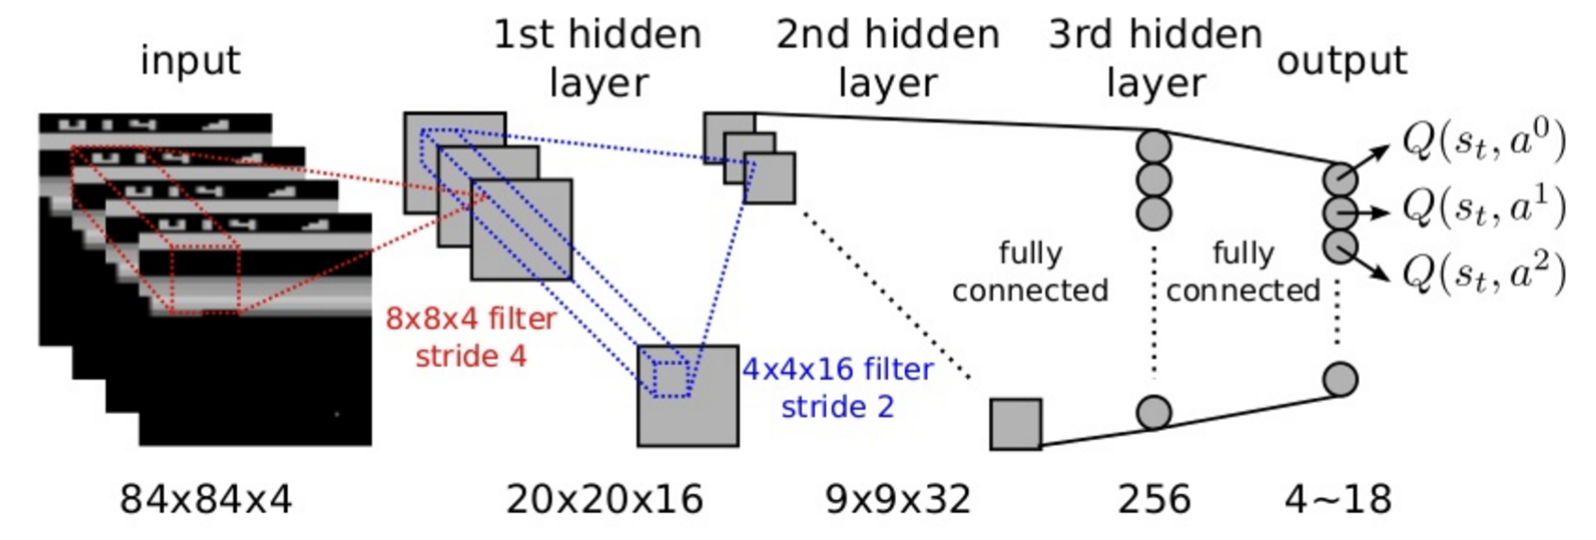

In [12]:
class Actor1(nn.Module):
    def __init__(self, input_channels, N_FRAMES, n_actions):
        super().__init__()

        self.n_actions = n_actions

        self.conv1 = nn.Conv2d(N_FRAMES, 16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        
        self.fc1 = nn.Linear(288 * 9, 256)
        self.fc2 = nn.Linear(256, n_actions)

        logstds_param = nn.Parameter(torch.full((n_actions,), -1.))
        self.register_parameter("logstds", logstds_param)

    def forward(self, state_t):
        x = state_t.squeeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 288 * 9)
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))

        means = x
        stds = torch.clamp(self.logstds.exp(), 1e-3, 50)
        
        return torch.distributions.Normal(means, stds)


class Critic1(nn.Module):
    def __init__(self, input_channels, N_FRAMES, n_actions):
        super().__init__()

        self.n_actions = n_actions

        self.conv1 = nn.Conv2d(N_FRAMES, 16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        self.fc1 = nn.Linear(288 * 9, 256)
        self.fc2 = nn.Linear(256, 1)

        
    def forward(self, state_t):
        x = state_t.squeeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 288 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x



In [13]:
n_actions = env.action_space.shape[0]
obs_dim = env.observation_space.sample().shape[0]
n_frames = 4
input_channels = 1
actor_net = Actor1(input_channels, n_frames, n_actions).to(device)
critic_net = Critic1(input_channels, n_frames, n_actions).to(device)

state_t = t(np.ones((2, 1,4, 84, 84)))
# actions_t = t(np.ones((2, n_actions)))

actor_net(state_t), critic_net(state_t).shape

(Normal(loc: torch.Size([2, 6]), scale: torch.Size([2, 6])),
 torch.Size([2, 1]))

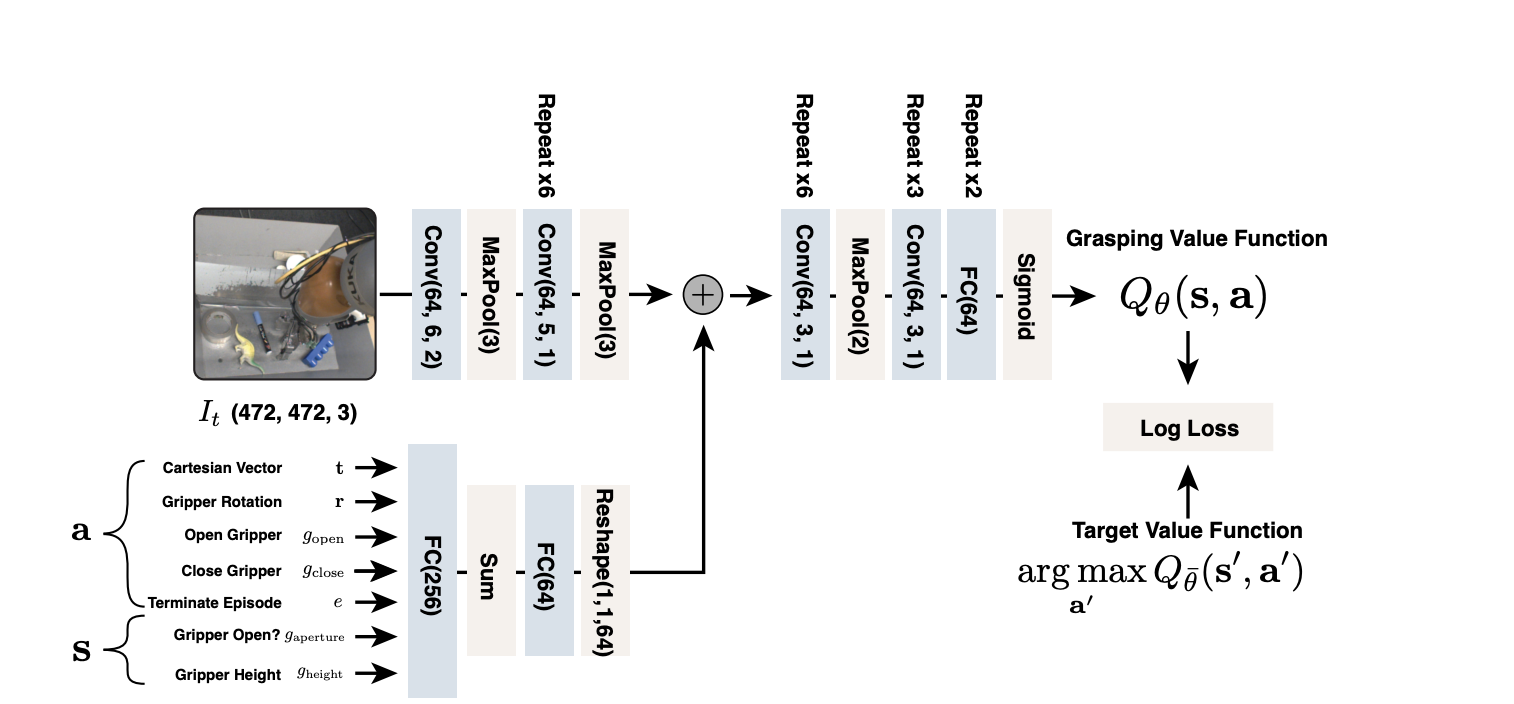

#### Standard - Observation Info Added


In [14]:
class Actor2(nn.Module):
    def __init__(self, input_channels, n_frames, n_actions, obs_dim):
        super().__init__()

        self.n_actions = n_actions

        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=6, stride=2)
        self.max_pool1 = nn.MaxPool2d(3)
        self.conv2 = nn.Sequential( *[nn.Conv2d(64, 64, kernel_size=5, stride=1, padding = 2)] * 2)
        self.max_pool2 = nn.MaxPool2d(3)
        self.conv3 = nn.Sequential( *[nn.Conv2d(64, 64, kernel_size=3, stride=1, padding = 1)] * 2)
        self.max_pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Sequential( *[nn.Conv2d(64, 64, kernel_size=3, stride=1, padding = 1)] * 1)
        
        self.fc1 = nn.Linear(obs_dim, 256)
        self.fc2 = nn.Linear(256, 64)
        
        self.fc3 = nn.Linear(2304, 64)
        self.fc4 = nn.Linear(64, n_actions)

        logstds_param = nn.Parameter(torch.full((n_actions,), -1.))
        self.register_parameter("logstds", logstds_param)

    def forward(self, state_t, obs_t):
        x = state_t.squeeze(2)
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        
        o = F.relu(self.fc1(obs_t))
        o = F.relu(self.fc2(o))
        o = o.view(-1,64,1,1)
        
        x = x + o
        
        x = F.relu(self.conv3(x))
        x = self.max_pool3(x)
        x = F.relu(self.conv4(x))
        
        x = x.view(-1 , 2304)
        x = F.relu(self.fc3(x))
        x = F.tanh(self.fc4(x))
        
        means = x
        stds = torch.clamp(self.logstds.exp(), 1e-3, 50)
        return torch.distributions.Normal(means, stds)

    

class Critic2(nn.Module):
    def __init__(self, input_channels, n_frames, n_actions, obs_dim):
        super().__init__()

        self.n_actions = n_actions

        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=6, stride=2)
        self.max_pool1 = nn.MaxPool2d(3)
        self.conv2 = nn.Sequential( *[nn.Conv2d(64, 64, kernel_size=5, stride=1, padding = 2)] * 2)
        self.max_pool2 = nn.MaxPool2d(3)
        self.conv3 = nn.Sequential( *[nn.Conv2d(64, 64, kernel_size=3, stride=1, padding = 1)] * 2)
        self.max_pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Sequential( *[nn.Conv2d(64, 64, kernel_size=3, stride=1, padding = 1)] * 1)
        
        self.fc1 = nn.Linear(obs_dim, 256)
        self.fc2 = nn.Linear(256, 64)

        self.fc3 = nn.Linear(2304, 64) 
        self.fc4 = nn.Linear(64, 1)

    def forward(self, state_t, obs_t):
        x = state_t.squeeze(2)
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        
        o = F.relu(self.fc1(obs_t))
        o = F.relu(self.fc2(o))
        o = o.view(-1,64,1,1)
        
        
        x = x + o
        
        x = F.relu(self.conv3(x))
        x = self.max_pool3(x)
        x = F.relu(self.conv4(x))
        
        x = x.view(-1 , 2304)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x


In [15]:
n_actions = env.action_space.shape[0]
actions_per_dim = 20
obs_dim = env.observation_space.sample().shape[0]
input_channels = 6


actor_net = Actor2(input_channels, n_frames, n_actions, obs_dim).to(device)
critic_net = Critic2(input_channels, n_frames, n_actions, obs_dim).to(device)

state_t = t(np.ones((2,6,1,224,224)))
obs_t = t(torch.ones(2, obs_dim))
actions_t = t(np.ones((2, n_actions)))
actor_net(state_t, obs_t), critic_net(state_t, obs_t).shape

(Normal(loc: torch.Size([2, 6]), scale: torch.Size([2, 6])),
 torch.Size([2, 1]))

#### Standard - Observation Info Concatenated

In [16]:
class Actor3(nn.Module):
    def __init__(self, input_channels, n_frames, n_actions, obs_dim):
        super().__init__()

        self.n_actions = n_actions
        self.input_channels = input_channels
        self.n_frames = n_frames

        self.conv1 = nn.Conv2d(input_channels * n_frames, 64, kernel_size=6, stride=2)
        self.max_pool1 = nn.MaxPool2d(3)
        self.conv2 = nn.Sequential( *[nn.Conv2d(64, 64, kernel_size=5, stride=1, padding = 2)] * 1)
        self.max_pool2 = nn.MaxPool2d(3)
        self.conv3 = nn.Sequential( *[nn.Conv2d(64, 64, kernel_size=3, stride=1, padding = 1)] * 1)
        self.max_pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Sequential( *[nn.Conv2d(64, 64, kernel_size=3, stride=1, padding = 1)] * 1)
        
        self.fc1 = nn.Linear(obs_dim, 256)
        self.fc2 = nn.Linear(256, 64)

        self.fc1 = nn.Linear(obs_dim, 256)
        self.fc2 = nn.Linear(256, 64)

        self.fc3 = nn.Linear(576, 64)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, n_actions)

        logstds_param = nn.Parameter(torch.full((n_actions,), -1.))
        self.register_parameter("logstds", logstds_param)

    def forward(self, state_t, obs_t):
        x = state_t.reshape(-1,self.input_channels * self.n_frames, 128, 128)
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.max_pool3(x)
        x = F.relu(self.conv4(x))
        

        x = x.view(-1 , 576)
        x = F.relu(self.fc3(x))

        o = F.relu(self.fc1(obs_t))
        o = F.relu(self.fc2(o))
        o = o.view(-1,64)

        x = torch.concatenate((x, o), dim = -1)
        
        x = F.relu(self.fc4(x))
        x = F.tanh(self.fc5(x))
        
        means = x
        stds = torch.clamp(self.logstds.exp(), 1e-3, 50)
        
        return torch.distributions.Normal(means, stds)


class Critic3(nn.Module):
    def __init__(self, input_channels, n_frames, n_actions, obs_dim):
        super().__init__()

        self.actions_per_dim = actions_per_dim
        self.n_actions = n_actions
        self.input_channels = input_channels
        self.n_frames = n_frames

        self.conv1 = nn.Conv2d(input_channels * n_frames, 64, kernel_size=6, stride=2)
        self.max_pool1 = nn.MaxPool2d(3)
        self.conv2 = nn.Sequential( *[nn.Conv2d(64, 64, kernel_size=5, stride=1, padding = 2)] * 1)
        self.max_pool2 = nn.MaxPool2d(3)
        self.conv3 = nn.Sequential( *[nn.Conv2d(64, 64, kernel_size=3, stride=1, padding = 1)] * 1)
        self.max_pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Sequential( *[nn.Conv2d(64, 64, kernel_size=3, stride=1, padding = 1)] * 1)
        
        self.fc1 = nn.Linear(obs_dim, 256)
        self.fc2 = nn.Linear(256, 64)

        self.fc1 = nn.Linear(obs_dim, 256)
        self.fc2 = nn.Linear(256, 64)

        self.fc3 = nn.Linear(576, 64)

        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)

        
        

    def forward(self, state_t, obs_t):
        x = state_t.reshape(-1, self.input_channels * self.n_frames, 128, 128)
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        
        x = F.relu(self.conv3(x))
        x = self.max_pool3(x)
        x = F.relu(self.conv4(x))
        

        x = x.view(-1 , 576)
        x = F.relu(self.fc3(x))

        o = F.relu(self.fc1(obs_t))
        o = F.relu(self.fc2(o))
        o = o.view(-1,64)

        x = torch.concatenate((x, o), dim = -1)
        
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return x

    
    

In [17]:
n_actions = env.action_space.shape[0]
actions_per_dim = 20
obs_dim = env.observation_space.shape[0]
input_channels = 6
n_frames = 8
actor_net = Actor3(input_channels, n_frames, n_actions, obs_dim).to(device)
critic_net = Critic3(input_channels, n_frames, n_actions, obs_dim).to(device)

state_t = t(np.ones((2,6,8,128,128)))
obs_t = t(torch.ones(2, obs_dim))
actions_t = t(np.ones((2, n_actions)))
actor_net(state_t, obs_t).sample().shape, critic_net(state_t, obs_t).shape

(torch.Size([2, 6]), torch.Size([2, 1]))

#### 3D Vision Transformers

In [18]:
class Actor_ViT_1(nn.Module):
    def __init__(self, input_channels, n_frames, n_actions):
        super().__init__()

        self.n_actions = n_actions
        self.n_frames = n_frames

        self.vit = ViT(
            image_size = 128,          # image size
            frames = n_frames,         # number of frames
            image_patch_size = 16,     # image patch size
            frame_patch_size = 2,      # frame patch size
            num_classes = 1000,
            dim = 1024,
            depth = 6,
            heads = 8,
            mlp_dim = 2048,
            dropout = 0.1,
            emb_dropout = 0.1,
            channels = input_channels
        )
        self.fc1 = nn.Linear(1000, n_actions)

        logstds_param = nn.Parameter(torch.full((n_actions,), -1.))
        self.register_parameter("logstds", logstds_param)


    def forward(self, state_t):
        x = self.vit(state_t)
        x = F.tanh(self.fc1(x))
        
        means = x
        stds = torch.clamp(self.logstds.exp(), 1e-3, 50)
        return torch.distributions.Normal(means, stds)


class Critic_ViT_1(nn.Module):
    def __init__(self, input_channels, n_frames, n_actions):
        super().__init__()

        self.n_actions = n_actions
        self.n_frames = n_frames

        self.vit = ViT(
            image_size = 128,          # image size
            frames = n_frames,         # number of frames
            image_patch_size = 16,     # image patch size
            frame_patch_size = 2,      # frame patch size
            num_classes = 1000,
            dim = 1024,
            depth = 6,
            heads = 8,
            mlp_dim = 2048,
            dropout = 0.1,
            emb_dropout = 0.1,
            channels = input_channels
        )
        self.fc1 = nn.Linear(1000, 1)


    def forward(self, state_t):
        x = self.vit(state_t)
        x = F.relu(self.fc1(x))
        return x
    

In [19]:
# N_FRAMES = 16
# n_actions = env.action_space.shape[0]
# actions_per_dim = 20
# obs_dim = env.observation_space.sample().shape[0]

# model = Model_DQN_ViT_1(input_channels, N_FRAMES, n_actions, actions_per_dim).to(device)

# state_t = t(np.ones((2,3, 16, 64, 64)))

# model(state_t).shape, model.get_action(n(state_t[0]))

#### 3D Vision Transformers - Observation Info **Concatenated**

In [20]:
class Actor_ViT_2(nn.Module):
    def __init__(self, input_channels, n_frames, n_actions, obs_dim):
        super().__init__()

        self.n_actions = n_actions
        self.n_frames = n_frames

        self.vit = ViT(
            image_size = 128,          # image size
            frames = n_frames,         # number of frames
            image_patch_size = 16,     # image patch size
            frame_patch_size = 2,      # frame patch size
            num_classes = 1000,
            dim = 1024,
            depth = 6,
            heads = 8,
            mlp_dim = 2048,
            dropout = 0.1,
            emb_dropout = 0.1,
            channels = input_channels
        )
        self.fc1 = nn.Linear(1000, 64)

        self.fc2 = nn.Linear(obs_dim, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, n_actions)

        logstds_param = nn.Parameter(torch.full((n_actions,), -1.))
        self.register_parameter("logstds", logstds_param)

        

    def forward(self, state_t, obs_t):
        x = self.vit(state_t)
        x = F.relu(self.fc1(x))

        o = F.relu(self.fc2(obs_t))
        o = F.relu(self.fc3(o))
        o = o.view(-1,64)

        x = torch.concatenate((x, o), dim = -1)
        
        x = F.relu(self.fc4(x))
        x = F.tanh(self.fc5(x))
        means = x
        stds = torch.clamp(self.logstds.exp(), 1e-3, 50)
        
        return torch.distributions.Normal(means, stds)

        
class Critic_ViT_2(nn.Module):
    def __init__(self, input_channels, n_frames, n_actions, obs_dim):
        super().__init__()

        self.n_actions = n_actions
        self.n_frames = n_frames

        self.vit = ViT(
            image_size = 128,          # image size
            frames = n_frames,         # number of frames
            image_patch_size = 16,     # image patch size
            frame_patch_size = 2,      # frame patch size
            num_classes = 1000,
            dim = 1024,
            depth = 6,
            heads = 8,
            mlp_dim = 2048,
            dropout = 0.1,
            emb_dropout = 0.1,
            channels = input_channels
        )
        self.fc1 = nn.Linear(1000, 64)

        self.fc2 = nn.Linear(obs_dim, 256)
        self.fc3 = nn.Linear(256, 64)

        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)

        


    def forward(self, state_t, obs_t):
        x = self.vit(state_t)
        x = F.relu(self.fc1(x))

        o = F.relu(self.fc2(obs_t))
        o = F.relu(self.fc3(o))
        o = o.view(-1,64)

        x = torch.concatenate((x, o), dim = -1)
        
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        return x
        

In [21]:
n_actions = env.action_space.shape[0]
actions_per_dim = 20
obs_dim = env.observation_space.sample().shape[0]
n_frames = 10
input_channels = 6


actor_net = Actor_ViT_2(input_channels, n_frames, n_actions, obs_dim).to(device)
critic_net = Critic_ViT_2(input_channels, n_frames, n_actions, obs_dim).to(device)

state_t = t(np.ones((2,6,10,128,128)))
obs_t = t(torch.ones(2, obs_dim))
actions_t = t(np.ones((2, n_actions)))
actor_net(state_t, obs_t), critic_net(state_t, obs_t).shape

(Normal(loc: torch.Size([2, 6]), scale: torch.Size([2, 6])),
 torch.Size([2, 1]))

## Environments

In [22]:
def run_sample(env, max_steps = 100, fname = "out", frate = 10, nframes = None, is_rover_env = False):
    g = GIFMaker() # visualization
    _, info = env.reset()
    observation = env.render() # use visual input this time!
    for i in range(max_steps):
        action = env.action_space.sample()
        _, reward, terminated, truncated, info = env.step(action)
        if is_rover_env:
            observation = env.render(224, 224)
        else:
            observation = env.render()
        g.append(observation) # save one frame for GIF
        if terminated or truncated:
            _, info = env.reset()
            break
    g.video_out(fname , frate , nframes) # show GIF animation
    return g

In [23]:
# env

## Training

In [24]:
def clip_grad_norm_(module, max_grad_norm):
        nn.utils.clip_grad_norm_([p for g in module.param_groups for p in g["params"]], max_grad_norm)

In [25]:
# !unzip /content/expert_buffer.zip -d /content/

Archive:  /content/expert_buffer.zip
   creating: /content/replay_buffer/
  inflating: /content/replay_buffer/889407371223.npy  
  inflating: /content/replay_buffer/889407371237.npy  
  inflating: /content/replay_buffer/20.npy  
replace /content/__MACOSX/replay_buffer/._20.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [65]:
class Trainer():
    def __init__(self, model_actor, model_critic, env, n_frames, img_shape, is_rover_env, device,
                load_model = False, BATCH_SIZE = 512, REPLAY_BUFFER_SIZE = 5000):
        self.n_frames = n_frames
        self.env = env
        self.model_actor = model_actor
        self.model_critic = model_critic
        self.n_actions = env.action_space.shape[0]
        self.obs_dim = env.observation_space.shape[0]
        self.model_path = f"A2C/{self.model_actor.__name__}/model.h5"
        
        self.max_grad_norm = 0.5
        self.entropy_beta = 0

        self.img_shape = img_shape
        self.device = device
        self.is_rover_env = is_rover_env
        self.BATCH_SIZE = BATCH_SIZE
        self.models_obs_req = {
            # Actor1 : 0,
            # Actor2: 1,
            # Actor3: 1,
            # Actor_ViT_1: 0,
            # Actor_ViT_2: 1,
            Actor_Simple : 1
        }
        os.makedirs(f'./A2C/{self.model_actor.__name__}', exist_ok=True)
        env.reset()
        self.input_channels = env.render().shape[2]
        self.episode_rewards = []
        self.initialize_models()
        if load_model: self.load_models(self.model_path)
        self.replay_buffer = self.initialize_replay_buffer(REPLAY_BUFFER_SIZE)
        self.load_expert_buffer()

        
    def initialize_models(self):
        n_frames = self.n_frames

        if self.models_obs_req[self.model_actor]:            
            self.actor = self.model_actor(self.input_channels, self.n_frames, self.n_actions, self.obs_dim).to(self.device)
            # self.target_actor = self.model_actor(self.input_channels, self.n_frames, self.n_actions, self.obs_dim).to(self.device)
            
            self.critic = self.model_critic(self.input_channels, self.n_frames, self.n_actions, self.obs_dim).to(self.device)
            self.target_critic = self.model_critic(self.input_channels, self.n_frames, self.n_actions, self.obs_dim).to(self.device)
        else:
            self.actor = self.model_actor(self.input_channels, self.n_frames, self.n_actions).to(self.device)
            # self.target_actor = self.model_actor(self.input_channels, self.n_frames, self.n_actions).to(self.device)
            
            self.critic = self.model_critic(self.input_channels, self.n_frames, self.n_actions).to(self.device)
            self.target_critic = self.model_critic(self.input_channels, self.n_frames, self.n_actions).to(self.device)

        # self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic.load_state_dict(self.critic.state_dict())
        
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr= 5e-4 )
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr= 5e-4 )


    def load_expert_buffer(self):
        data = []
        for path in sorted(glob.glob('/content/expert_buffer/*npy')):
            replay_buffer = np.load(path, allow_pickle=True)
            assert replay_buffer[-1][4] == 1.0
            for sample in replay_buffer:
                data.append(sample)
        self.expert_buffer = data


    def initialize_replay_buffer(self, REPLAY_BUFFER_SIZE):

        img_shape = self.img_shape

        replay_buffer = deque(maxlen = REPLAY_BUFFER_SIZE)
        state = deque(maxlen = self.n_frames)
        for i in range(self.n_frames): 
            state.append(np.zeros(img_shape, dtype = np.uint8))
        
        ep = 0
        obs, info = env.reset()
        for step in range(self.BATCH_SIZE * 2):
            action = env.action_space.sample()
            prev_obs = obs.copy()
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            if self.is_rover_env:
                render_shape = [img_shape[0],img_shape[1]]
            else:
                render_shape = []
            img = env.render(*render_shape)     
            if not self.is_rover_env:
                img = cv2.resize(img, (img_shape[0],img_shape[1]))
            if img_shape[2] == 1:
                img = cv2.cvtColor(img[:,:,:3], cv2.COLOR_RGB2GRAY)
                img = np.expand_dims(img, axis=-1)
            prev_state = state.copy()
            state.append(img)
        
            # assert np.sum(prev_state[-1] -  state[-1]) != 0
            # assert np.sum(prev_obs -  obs) != 0

            replay_buffer.append((np.moveaxis(prev_state, -1, 0), prev_obs, action, reward, terminated, np.moveaxis(state, -1, 0), obs))
            
            if done:
                ep += 1
                _, info = env.reset()
                for i in range(self.n_frames):
                    state.append(np.zeros(img_shape, dtype = np.uint8))
        return replay_buffer


        
    def train(self, EPISODES = 1, GAMMA = 0.99, ALPHA = 0.01, MAX_STEPS_PER_EPISODE = 100, DISPLAY_FRAMES = 300):
        N_FRAMES = self.n_frames
        BATCH_SIZE = self.BATCH_SIZE

        REWARD_BUFFER_SIZE = 1
        TARGET_UPDATE_FREQUENCY = 100
        RECORDED_EPISODES = 20
        
        # Environment Constants
        env = self.env

        actor, actor_optimizer = self.actor, self.actor_optimizer
        critic, target_critic, critic_optimizer = self.critic, self.target_critic, self.critic_optimizer
        replay_buffer = self.replay_buffer
        
        self.g = GIFMaker() # visualization
        obs, info = env.reset()
        episode_reward = 0

        state = deque(maxlen = N_FRAMES)
        img_shape = self.img_shape
        models_obs_req = self.models_obs_req

        for ep in range(EPISODES):
            done = False
            rewards = []
            for i in range(N_FRAMES): 
                state.append(np.zeros(img_shape, dtype = np.uint8))
            step = 0
            gc_collect()
            while not done:
                step += 1
                state_t = t(np.moveaxis(np.array(state), -1, 0)).unsqueeze(0)
                obs_t = t(obs).unsqueeze(0)
                if models_obs_req[self.model_actor]:
                    dists = actor(state_t, obs_t)
                else:
                    dists = actor(state_t)
                
                action = (n(dists.sample().squeeze(0)))
                action = np.clip(action, self.env.action_space.low.min(), env.action_space.high.max())

                prev_obs = obs.copy()
                obs, reward, terminated, truncated, info = env.step(action)
                
                if self.is_rover_env:
                    render_shape = [img_shape[0],img_shape[1]]
                else:
                    render_shape = []
                img_org = env.render(*render_shape)
                self.g.append(img_org)
                if not self.is_rover_env:
                    img = cv2.resize(img_org, (img_shape[0],img_shape[1]))
                else:
                    img = img_org.copy()
                if img_shape[2] == 1:
                    img = cv2.cvtColor(img[:,:,:3], cv2.COLOR_RGB2GRAY)
                    img = np.expand_dims(img, axis=-1)
                prev_state = state.copy()
                state.append(img)

                episode_reward += reward
                done = terminated or truncated
                if step > MAX_STEPS_PER_EPISODE :
                    done = 1
                if step % 10 ==0 :
                    print(f"{step = }, {episode_reward = }")
                
                prev_state_n = np.moveaxis(np.array(prev_state), -1, 0)
                state_n = np.moveaxis(np.array(state), -1, 0)
                replay_buffer.append((prev_state_n, prev_obs, action, reward, terminated, state_n, obs))
                
                sampled_transitions = random.sample(replay_buffer,BATCH_SIZE // 4) + random.sample(self.expert_buffer,(BATCH_SIZE * 3) // 4)


                states, obses, actions, rewards, dones, new_states, new_obses = [[t[i] for t in sampled_transitions] for i in range(7)]
                states, new_states = t(1), t(1)
                s1 = torch.as_tensor(states, dtype = torch.float32 ).to(device)
                r1 = torch.as_tensor(np.array(rewards), dtype = torch.float32 ).unsqueeze(-1).to(device)
                s2 = torch.as_tensor(new_states, dtype = torch.float32 ).to(device)
                a1 =  torch.as_tensor(np.array(actions), dtype = torch.float32).to(device)
                dones_t = torch.as_tensor(np.array(dones), dtype = torch.int64 ).unsqueeze(-1).to(device)
                # print(actions_t)
                # print(states_t.shape, actions_t.shape, new_states_t.shape)
                if models_obs_req[self.model_actor]:
                    o1 = torch.as_tensor(np.array(obses), dtype = torch.float32 ).to(device)
                    o2 = torch.as_tensor(np.array(new_obses), dtype = torch.float32 ).to(device)
                    # print(obses_t.shape, new_obses_t.shape)

                
                if models_obs_req[self.model_actor]:
                    norm_dists = actor(s1, o1)
                    td_target = r1 + GAMMA * target_critic(s2, o2) * (1 - dones_t)
                    value = critic(s1, o1)
                else:
                    norm_dists = actor(s1)
                    td_target = r1 + GAMMA * target_critic(s2) * (1 - dones_t)
                    value = critic(s1)
                
                advantage = td_target - value

                logs_probs = norm_dists.log_prob(a1)
                entropy = norm_dists.entropy().mean()
                actor_loss = (-logs_probs*advantage.detach()).mean() - entropy * self.entropy_beta
                actor_optimizer.zero_grad()
                actor_loss.backward()

                clip_grad_norm_(actor_optimizer, self.max_grad_norm)
                actor_optimizer.step()

                # compute critic loss, and update the critic
                critic_loss = F.mse_loss(td_target, value)
                critic_optimizer.zero_grad()
                critic_loss.backward()
                clip_grad_norm_(critic_optimizer, self.max_grad_norm)
                critic_optimizer.step()
               
                # Loading Target network with Q network 
                if step % TARGET_UPDATE_FREQUENCY == 0:
                    self.target_critic.load_state_dict(self.critic.state_dict())
                
                
                
            observation, info = env.reset()
            self.episode_rewards.append(episode_reward)
            episode_reward = 0

            self.g.display(f"A2C/{self.model_actor.__name__}/ep{ep}", nframes=DISPLAY_FRAMES)
            
            if ep % REWARD_BUFFER_SIZE == 0:
                self.save_models(self.model_path)
                avg_episode_reward = np.mean(self.episode_rewards[-REWARD_BUFFER_SIZE:])
                print(f"Episode {ep}, reward {avg_episode_reward}")
                if EPISODES - ep < RECORDED_EPISODES:
                    self.g.video_out(f"A2C/{self.model_actor.__name__}/ep{ep}")
                self.g.reset()
            np.save(f"A2C/{self.model_actor.__name__}/a2c_rewards_rover_arm_1_{ep}.npy", self.episode_rewards)
            

        self.g.display() # show GIF animation
        return (self.episode_rewards, self.g)
    
    def save_models(self, path):
        torch.save({
            'actor_state_dict': self.actor.state_dict(),
            'critic_state_dict': self.critic.state_dict(),
            'target_critic_state_dict': self.target_critic.state_dict(),
            'actor_optimizer_state_dict': self.actor_optimizer.state_dict(),
            'critic_optimizer_state_dict': self.critic_optimizer.state_dict(),
            }, path)
        
    def load_models(self, path):
        checkpoint = torch.load(path)
        self.actor.load_state_dict(checkpoint['actor_state_dict'])
        self.critic.load_state_dict(checkpoint['critic_state_dict'])
        self.target_critic.load_state_dict(checkpoint['target_critic_state_dict'])
        self.actor_optimizer.load_state_dict(checkpoint['actor_optimizer_state_dict'])
        self.critic_optimizer.load_state_dict(checkpoint['critic_optimizer_state_dict'])
        print("models loaded")


    def close(self):
        self.env.close()


In [66]:
def gc_collect():
    try: del trainer
    except: pass
    try: del g
    except: pass
    gc.collect()
gc_collect()

In [67]:
# action = np.array([env.action_space.sample()])
# trainer.get_exploration_action(action)
# action.shape

In [29]:
# action = t([env.action_space.sample()])
# print(action)
# trainer.get_exploration_action(action, 0.1)
# trainer = Trainer(Model_DQN_2, env, 1, 20, (472,472,3), 0, device)
# trainer = Trainer(Model_DQN_3, env, 1, 20, (472,472,3), 0, device)
# trainer = Trainer(Model_DQN_ViT_1, env, 16, 20, (128,128,3), 0, device)
# trainer = Trainer(Model_DQN_ViT_2, env, 16, 20, (128,128,3), 0, device)

### Half Cheetah

In [30]:
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
# g = run_sample(env)
a2c_rewards_half_cheetah = {}
EPISODES, STEPS = 5, 20

In [31]:
# gc_collect()

# trainer = Trainer(Actor1, Critic1, env, 4, (84,84,1), 0, device, "A2C/Actor1_half_cheetah.h5", load_model = 0)

# episode_rewards, g = trainer.train(EPISODES, MAX_STEPS_PER_EPISODE = STEPS)

# a2c_rewards_half_cheetah[Actor1] = episode_rewards
# np.save("A2C/rewards_half_cheetah[A2C_1]).npy", a2c_rewards_half_cheetah[Actor1])

In [32]:
# gc_collect()
 
# trainer = Trainer(Actor2, Critic2, env, 1, (224,224,3), 0, device)
# episode_rewards, g = trainer.train(EPISODES, MAX_STEPS_PER_EPISODE = STEPS)

# a2c_rewards_half_cheetah[Actor2] = episode_rewards
# np.save("A2C/rewards_half_cheetah[A2C_2]).npy", a2c_rewards_half_cheetah[Actor2])

In [33]:
# gc_collect()

# trainer = Trainer(Actor3, Critic3, env, 8, (128,128,3), 0, device)
# episode_rewards, g = trainer.train(EPISODES, MAX_STEPS_PER_EPISODE = STEPS)

# a2c_rewards_half_cheetah[Actor3] = episode_rewards
# np.save("A2C/rewards_half_cheetah[Actor3]).npy", a2c_rewards_half_cheetah[Actor3])

In [34]:
# gc_collect()
# trainer = Trainer(Actor_ViT_1, Critic_ViT_1, env, 8, (128,128,3), 0, device)
# episode_rewards, g = trainer.train(EPISODES, MAX_STEPS_PER_EPISODE = STEPS)

# a2c_rewards_half_cheetah[Actor_ViT_1] = episode_rewards
# np.save("A2C/rewards_half_cheetah[Actor_ViT_1]).npy", a2c_rewards_half_cheetah[Actor_ViT_1])

In [35]:
# gc_collect()

# trainer = Trainer(Actor_ViT_2, Critic_ViT_2, env, 8, (128,128,3), 0, device)
# episode_rewards, g = trainer.train(EPISODES, MAX_STEPS_PER_EPISODE = STEPS)

# a2c_rewards_half_cheetah[Actor_ViT_2] = episode_rewards
# np.save("A2C/rewards_half_cheetah[Actor_ViT_2]).npy", a2c_rewards_half_cheetah[Actor_ViT_2])

### Pusher

In [36]:
# import gymnasium as gym
# env = gym.make("Pusher-v4", render_mode="rgb_array")
# run_sample(env)

# dqn_rewards_pusher = {}

### Rover-Arm - Task1 

In [51]:
import rover_arm
env = gym.make('rover-arm-pick-v1', render_mode = 'rgb_array')
# g = run_sample(env, is_rover_env=True)
EPISODES, STEPS = 200, 2000
a2c_rewards_rover_arm_1 = {}

In [38]:
# env.observation_space.sample()

In [39]:
# gc_collect()

# trainer = Trainer(Actor3, Critic3, env, 6, (128,128,6), 1, device, "A2C/rover_arm_actor1.h5", 0)
# episode_rewards, g = trainer.train(EPISODES, MAX_STEPS_PER_EPISODE = STEPS)

# a2c_rewards_rover_arm_1[Actor3] = episode_rewards
# np.save("A2C/a2c_rewards_rover_arm_1[Actor3]).npy", a2c_rewards_rover_arm_1[Actor3])

In [40]:
# gc_collect()

# trainer = Trainer(Actor_ViT_2, Critic_ViT_2, env, 6, (128,128,6), 1, device)
# episode_rewards, g = trainer.train(EPISODES, MAX_STEPS_PER_EPISODE = STEPS)

# a2c_rewards_rover_arm_1[Actor_ViT_2] = episode_rewards
# np.save("A2C/a2c_rewards_rover_arm_1[Actor_ViT_2]).npy", a2c_rewards_rover_arm_1[Actor_ViT_2])

In [41]:
# gc_collect()
# trainer = Trainer(Actor_ViT_1, Critic_ViT_1, env, 8, (128,128,6), 0, device)
# episode_rewards, g = trainer.train(EPISODES, MAX_STEPS_PER_EPISODE = STEPS)

# a2c_rewards_rover_arm_1[Actor_ViT_1] = episode_rewards
# np.save("A2C/a2c_rewards_rover_arm_1[Actor_ViT_1]).npy", a2c_rewards_rover_arm_1[Actor_ViT_1])

In [42]:
# gc_collect()

# trainer = Trainer(Actor2, Critic2, env, 1, (224,224,6), 0, device)
# episode_rewards, g = trainer.train(EPISODES, MAX_STEPS_PER_EPISODE = STEPS)

# a2c_rewards_rover_arm_1[Actor2] = episode_rewards
# np.save("A2C/a2c_rewards_rover_arm_1[Actor2]).npy", a2c_rewards_rover_arm_1[Actor2])

In [43]:
# gc_collect()

# trainer = Trainer(Actor1, Critic1, env, 4, (84,84,1), 0, device)

# episode_rewards, g = trainer.train(EPISODES, MAX_STEPS_PER_EPISODE = STEPS)

# a2c_rewards_rover_arm_1[Actor1] = episode_rewards
# np.save("A2C/a2c_rewards_rover_arm_1[Actor1]).npy", a2c_rewards_rover_arm_1[Actor1])

In [ ]:
gc_collect()

trainer = Trainer(Actor_Simple, Critic_Simple, env, 1, (1,1,6), 1, device)

episode_rewards, g = trainer.train(EPISODES, MAX_STEPS_PER_EPISODE = STEPS)

a2c_rewards_rover_arm_1[Actor_Simple] = episode_rewards
np.save("A2C/a2c_rewards_rover_arm_1[Actor_Simple]).npy", a2c_rewards_rover_arm_1[Actor_Simple])

step = 10, episode_reward = -0.0006171968022603113
step = 20, episode_reward = 0.0008141340935588298
step = 30, episode_reward = 0.007550853472419653
step = 40, episode_reward = 0.004226108146512934
step = 50, episode_reward = 0.0037433904089579904
step = 60, episode_reward = 0.0013395270139996349
step = 70, episode_reward = 0.0013418072672565548
step = 80, episode_reward = -4.5915243571355356e-05
step = 90, episode_reward = -0.0011724224799983488
step = 100, episode_reward = -0.004328966731405902
step = 110, episode_reward = -0.006334581979915631
step = 120, episode_reward = -0.009895530497791623
step = 130, episode_reward = -0.013230806451630845
step = 140, episode_reward = -0.015534776409802293
step = 150, episode_reward = -0.02077825152688977
step = 160, episode_reward = -0.025418541479633502
step = 170, episode_reward = -0.030364508623119322
step = 180, episode_reward = -0.035018640978973475
step = 190, episode_reward = -0.039982063790350554
step = 200, episode_reward = -0.0449641

/usr/local/lib/python3.9/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


Episode 0, reward -0.007305614123498005
step = 10, episode_reward = 0.0029919642389575705
step = 20, episode_reward = 0.005919433215468978
step = 30, episode_reward = 0.0026119497247765
step = 40, episode_reward = -0.0009259309151879471
step = 50, episode_reward = -0.0017018330650267531
step = 60, episode_reward = -0.0013614891878835022
step = 70, episode_reward = -0.0002166119129489718
step = 80, episode_reward = 0.0017195500123721565
step = 90, episode_reward = 0.003392803236480552
step = 100, episode_reward = 0.006613067839537257
step = 110, episode_reward = 0.0111834070763775
step = 120, episode_reward = 0.015513584945547953
step = 130, episode_reward = 0.02058067760195214
step = 140, episode_reward = 0.02623710135591468
step = 150, episode_reward = 0.031381513993254784
step = 160, episode_reward = 0.03658718273090307
step = 170, episode_reward = 0.04174615973372891
step = 180, episode_reward = 0.04709463808021972
step = 190, episode_reward = 0.05236436254156219
step = 200, episode

step = 2000, episode_reward = 0.1263175127817431


Episode 1, reward 0.12655120088892147
step = 10, episode_reward = 0.0009234490095844843
step = 20, episode_reward = 0.0021239491440233097
step = 30, episode_reward = -0.0047864239891218605
step = 40, episode_reward = -0.013531729743535982
step = 50, episode_reward = -0.01653346359676346
step = 60, episode_reward = -0.019622942860043145
step = 70, episode_reward = -0.02290077749457718
step = 80, episode_reward = -0.024684631828810154
step = 90, episode_reward = -0.024983970410229418
step = 100, episode_reward = -0.02503308878168078
step = 110, episode_reward = -0.02594038173709419
step = 120, episode_reward = -0.026534203889982063
step = 130, episode_reward = -0.02675306749778122
step = 140, episode_reward = -0.026372965408685008
step = 150, episode_reward = -0.025986118424332107
step = 160, episode_reward = -0.025916068208105308
step = 170, episode_reward = -0.025811518047899988
step = 180, episode_reward = -0.025270588169889127
step = 190, episode_reward = -0.02557277457954018
step = 

step = 2000, episode_reward = -0.005203406519868588


Episode 2, reward -0.005334580344362634
step = 10, episode_reward = 0.002379707803553471
step = 20, episode_reward = 0.00565375400497152
step = 30, episode_reward = 0.0008732361786272454
step = 40, episode_reward = -0.005724977058130924
step = 50, episode_reward = -0.008604375853431281
step = 60, episode_reward = -0.01270292674593361
step = 70, episode_reward = -0.015751930058233797
step = 80, episode_reward = -0.019198127436834567
step = 90, episode_reward = -0.021806092534907253
step = 100, episode_reward = -0.02381392658770569
step = 110, episode_reward = -0.02490216604229347
step = 120, episode_reward = -0.02575257094073945
step = 130, episode_reward = -0.025085930764223982
step = 140, episode_reward = -0.02538603641576241
step = 150, episode_reward = -0.02549514377614922
step = 160, episode_reward = -0.023345498931498534
step = 170, episode_reward = -0.02223077717738181
step = 180, episode_reward = -0.02111096300387206
step = 190, episode_reward = -0.020560344113824378
step = 200,

step = 2000, episode_reward = -0.07000614313984348


Episode 3, reward -0.06985611270052115
step = 10, episode_reward = -0.004485181997963739
step = 20, episode_reward = -0.009661599046159638
step = 30, episode_reward = -0.013171113613810346
step = 40, episode_reward = -0.0242085730335802
step = 50, episode_reward = -0.030867573980036117
step = 60, episode_reward = -0.03715393238119676
step = 70, episode_reward = -0.043141601525728684
step = 80, episode_reward = -0.048386184647825
step = 90, episode_reward = -0.05071358847658711
step = 100, episode_reward = -0.0515993498017823
step = 110, episode_reward = -0.05337954919896769
step = 120, episode_reward = -0.05498314708858586
step = 130, episode_reward = -0.0582831303024746
step = 140, episode_reward = -0.061110697166541356
step = 150, episode_reward = -0.06162898229108147
step = 160, episode_reward = -0.0598807233356757
step = 170, episode_reward = -0.057264262401507754
step = 180, episode_reward = -0.055572837483097895
step = 190, episode_reward = -0.05419125278584705
step = 200, episod

step = 2000, episode_reward = 0.006069584072800045


Episode 4, reward 0.006069584072800045
step = 10, episode_reward = 0.00011798518957072956
step = 20, episode_reward = -0.0018611665131904598
step = 30, episode_reward = -0.012348018080801154
step = 40, episode_reward = -0.023056109041987228
step = 50, episode_reward = -0.028997630441901918
step = 60, episode_reward = -0.033775258784904734
step = 70, episode_reward = -0.037969832979913416
step = 80, episode_reward = -0.04061231132104795
step = 90, episode_reward = -0.04193944500962196
step = 100, episode_reward = -0.041548237601275434
step = 110, episode_reward = -0.03963334515501413
step = 120, episode_reward = -0.03690210100592087
step = 130, episode_reward = -0.033385380389520644
step = 140, episode_reward = -0.029142482849671802
step = 150, episode_reward = -0.025015095995264223
step = 160, episode_reward = -0.020804898131711984
step = 170, episode_reward = -0.0162103789712279
step = 180, episode_reward = -0.01078083691573384
step = 190, episode_reward = -0.005084767180240283
step =

step = 2000, episode_reward = 0.016987182910493656


Episode 5, reward 0.017238114345840435
step = 10, episode_reward = -0.00794295596849095
step = 20, episode_reward = -0.01816495613186166
step = 30, episode_reward = -0.02600366057550531
step = 40, episode_reward = -0.024966588573474852
step = 50, episode_reward = -0.02785250897001537
step = 60, episode_reward = -0.02757660610978458
step = 70, episode_reward = -0.03396501619534434
step = 80, episode_reward = -0.03997655043517379
step = 90, episode_reward = -0.04473073206215167
step = 100, episode_reward = -0.047593835279671017
step = 110, episode_reward = -0.050489288781402894
step = 120, episode_reward = -0.0520329248080113
step = 130, episode_reward = -0.05278487534622947
step = 140, episode_reward = -0.053362914730390565
step = 150, episode_reward = -0.05395914014892511
step = 160, episode_reward = -0.05365656782021481
step = 170, episode_reward = -0.053540085839616246
step = 180, episode_reward = -0.051404428027435965
step = 190, episode_reward = -0.04766555700001998
step = 200, epi

step = 2000, episode_reward = 0.003237628024097812


Episode 6, reward 0.003237628024097812
step = 10, episode_reward = 0.003924540540463046
step = 20, episode_reward = 0.01022761915889324
step = 30, episode_reward = 0.002698757697317738
step = 40, episode_reward = -0.005953363471646764
step = 50, episode_reward = -0.0037552802406333337
step = 60, episode_reward = -0.00010563577920851106
step = 70, episode_reward = 0.0020509043648000783
step = 80, episode_reward = 0.0026096793842685278
step = 90, episode_reward = 0.0005600088714092583
step = 100, episode_reward = -0.0067817775282478215
step = 110, episode_reward = -0.014411669238424105
step = 120, episode_reward = -0.021800279460453677
step = 130, episode_reward = -0.028714061138205405
step = 140, episode_reward = -0.03513093830198864
step = 150, episode_reward = -0.04089601068563577
step = 160, episode_reward = -0.04629374054081742
step = 170, episode_reward = -0.050990782695583305
step = 180, episode_reward = -0.05482329829548159
step = 190, episode_reward = -0.05836543040576203
step =

step = 1680, episode_reward = -0.3429818270268832


Episode 7, reward -1.3429818270268832
step = 10, episode_reward = 0.004312369280385114
step = 20, episode_reward = 0.010241078615872099
step = 30, episode_reward = 0.0025179722423244112
step = 40, episode_reward = -0.00723622501000801
step = 50, episode_reward = -0.004448662368385455
step = 60, episode_reward = -9.378615343770419e-05
step = 70, episode_reward = 0.003070246164454008
step = 80, episode_reward = 0.0046302270922574445
step = 90, episode_reward = 0.0036338420360154783
step = 100, episode_reward = -0.004360473509335737
step = 110, episode_reward = -0.013086680993394282
step = 120, episode_reward = -0.021798448300355003
step = 130, episode_reward = -0.03051396919318017
step = 140, episode_reward = -0.03901972221381103
step = 150, episode_reward = -0.04717006064692029
step = 160, episode_reward = -0.055742712066427474
step = 170, episode_reward = -0.06416494272265844
step = 180, episode_reward = -0.07293714598717388
step = 190, episode_reward = -0.08212626511596707
step = 200,

step = 2000, episode_reward = -0.2052039071416256


Episode 8, reward -0.20496773497287893
step = 10, episode_reward = 0.004383815998473495
step = 20, episode_reward = 0.009142239790939834
step = 30, episode_reward = 0.0015744856381811412
step = 40, episode_reward = -0.006747907333964327
step = 50, episode_reward = -0.0069542970906067095
step = 60, episode_reward = -0.00830090160305733
step = 70, episode_reward = -0.009556937525398712
step = 80, episode_reward = -0.01024113378915803
step = 90, episode_reward = -0.010010657811101036
step = 100, episode_reward = -0.0091125123106909
step = 110, episode_reward = -0.008156091214238636
step = 120, episode_reward = -0.006426644027658845
step = 130, episode_reward = -0.004009548754378766
step = 140, episode_reward = -0.002549304837483562
step = 150, episode_reward = -0.0005851275624713598
step = 160, episode_reward = 0.0014619180115176549
step = 170, episode_reward = 0.0024455952959072827
step = 180, episode_reward = 0.0028911941533883824
step = 190, episode_reward = 0.0033284356922936025
step 

step = 2000, episode_reward = 0.07681014030257725


Episode 9, reward 0.07534630774761963
step = 10, episode_reward = -0.00318851405678644
step = 20, episode_reward = -0.007866394056465933
step = 30, episode_reward = -0.016526589252978705
step = 40, episode_reward = -0.02777348541429209
step = 50, episode_reward = -0.03573469473294449
step = 60, episode_reward = -0.04294965519053455
step = 70, episode_reward = -0.04802595245217254
step = 80, episode_reward = -0.05045542542973454
step = 90, episode_reward = -0.04995250365377007
step = 100, episode_reward = -0.0475984037814961
step = 110, episode_reward = -0.042016195048520305
step = 120, episode_reward = -0.03624974441116059
step = 130, episode_reward = -0.03311209308686564
step = 140, episode_reward = -0.03209919004380664
step = 150, episode_reward = -0.03431912747342351
step = 160, episode_reward = -0.03378389356147295
step = 170, episode_reward = -0.029373139560095858
step = 180, episode_reward = -0.025285518536010493
step = 190, episode_reward = -0.02523395175745849
step = 200, episo

step = 2000, episode_reward = 0.018338543762688904


Episode 10, reward 0.018550096436285683
step = 10, episode_reward = 0.0034206855784631508
step = 20, episode_reward = 0.0106866929568532
step = 30, episode_reward = 0.008876492653413982
step = 40, episode_reward = 0.006634695319198167
step = 50, episode_reward = 0.007475339766626339
step = 60, episode_reward = 0.00781223714623808
step = 70, episode_reward = 0.008258446076285977
step = 80, episode_reward = 0.008796615543212342
step = 90, episode_reward = 0.009753555856285543
step = 100, episode_reward = 0.01176292991519176
step = 110, episode_reward = 0.0128714557370308
step = 120, episode_reward = 0.01484130653021966
step = 130, episode_reward = 0.01564788234247734
step = 140, episode_reward = 0.017081382703734046
step = 150, episode_reward = 0.01844544083002508
step = 160, episode_reward = 0.020490181975389318
step = 170, episode_reward = 0.02307746523901389
step = 180, episode_reward = 0.02555988928115021
step = 190, episode_reward = 0.02757009645882105
step = 200, episode_reward = 0

step = 2000, episode_reward = 0.199891200589184


Episode 11, reward 0.199891200589184
step = 10, episode_reward = 0.0011631411128771112
step = 20, episode_reward = -0.000733136989007846
step = 30, episode_reward = -0.01141110287332383
step = 40, episode_reward = -0.020316892089172825
step = 50, episode_reward = -0.024170927885321655
step = 60, episode_reward = -0.02690134554625861
step = 70, episode_reward = -0.029157343248780936
step = 80, episode_reward = -0.03216035373632595
step = 90, episode_reward = -0.035261951219437586
step = 100, episode_reward = -0.03859738938108968
step = 110, episode_reward = -0.041081621625914076
step = 120, episode_reward = -0.04175500086247486
step = 130, episode_reward = -0.04175500086247486
step = 140, episode_reward = -0.04175500086247486
step = 150, episode_reward = -0.04293585989133425
step = 160, episode_reward = -0.04400782677469677
step = 170, episode_reward = -0.04400782677469677
step = 180, episode_reward = -0.04292852152342488
step = 190, episode_reward = -0.040560618579582236
step = 200, ep

step = 2000, episode_reward = -0.10120361386588389


Episode 12, reward -0.1014840317366735
step = 10, episode_reward = -0.0017663764029602293
step = 20, episode_reward = -0.0022372100120783083
step = 30, episode_reward = -0.0005100479461821572
step = 40, episode_reward = 0.004581155196064512
step = 50, episode_reward = 0.009663607035423908
step = 60, episode_reward = 0.015869121015107963
step = 70, episode_reward = 0.021780139916368298
step = 80, episode_reward = 0.028013772590448793
step = 90, episode_reward = 0.028449870051639316
step = 100, episode_reward = 0.02583341874639997
step = 110, episode_reward = 0.023254293454877253
step = 120, episode_reward = 0.021639850353060278
step = 130, episode_reward = 0.020479297452422017
step = 140, episode_reward = 0.018914959575065907
step = 150, episode_reward = 0.01699141162058852
step = 160, episode_reward = 0.01460603993345211
step = 170, episode_reward = 0.013351609870469891
step = 180, episode_reward = 0.012280584778216322
step = 190, episode_reward = 0.011885193710336969
step = 200, episo

step = 2000, episode_reward = 0.03945521766659109


Episode 13, reward 0.03990903953259581
step = 10, episode_reward = -0.0001255028856336618
step = 20, episode_reward = -0.005314562167720795
step = 30, episode_reward = -0.015018314864740303
step = 40, episode_reward = -0.026603990714927517
step = 50, episode_reward = -0.03249755465154213
step = 60, episode_reward = -0.0381488477534722
step = 70, episode_reward = -0.04247773707253847
step = 80, episode_reward = -0.04503834961371939
step = 90, episode_reward = -0.046297625264610946
step = 100, episode_reward = -0.046459970978319935
step = 110, episode_reward = -0.0461393515947742
step = 120, episode_reward = -0.045177200837875325
step = 130, episode_reward = -0.04349795456686136
step = 140, episode_reward = -0.04161049404961467
step = 150, episode_reward = -0.04053602927862665
step = 160, episode_reward = -0.03983744686593509
step = 170, episode_reward = -0.03833437643664968
step = 180, episode_reward = -0.03585017846542399
step = 190, episode_reward = -0.03417075295113305
step = 200, ep

step = 2000, episode_reward = -0.0806563463504435


Episode 14, reward -0.08037940317431207
step = 10, episode_reward = 0.005162315816912963
step = 20, episode_reward = 0.012474790613779756
step = 30, episode_reward = 0.010764608662274484
step = 40, episode_reward = 0.008178181537383027
step = 50, episode_reward = 0.009270345114591117
step = 60, episode_reward = 0.009375020289884663
step = 70, episode_reward = 0.010009582056804247
step = 80, episode_reward = 0.010165482851245269
step = 90, episode_reward = 0.01027678719980605
step = 100, episode_reward = 0.010486629724889191
step = 110, episode_reward = 0.01063055484328211
step = 120, episode_reward = 0.011247529996603702
step = 130, episode_reward = 0.012058472652403254
step = 140, episode_reward = 0.013256664685064319
step = 150, episode_reward = 0.014498721128012572
step = 160, episode_reward = 0.01724252537659722
step = 170, episode_reward = 0.019711980371635244
step = 180, episode_reward = 0.023500725346435613
step = 190, episode_reward = 0.0274120736961036
step = 200, episode_rewa

step = 2000, episode_reward = 0.07575719427016828


Episode 15, reward 0.07575719427016828
step = 10, episode_reward = 0.0016106738664242754
step = 20, episode_reward = -0.0001738924476924087
step = 30, episode_reward = 0.0012448843783405329
step = 40, episode_reward = -0.004454454165858933
step = 50, episode_reward = -0.0067666308962733065
step = 60, episode_reward = -0.008143810919211262
step = 70, episode_reward = -0.008435995346070662
step = 80, episode_reward = -0.008435995346070662
step = 90, episode_reward = -0.007469899390963612
step = 100, episode_reward = -0.005306755990010813
step = 110, episode_reward = -0.0022734938876470367
step = 120, episode_reward = 0.000979479481538221
step = 130, episode_reward = 0.0041608804706052055
step = 140, episode_reward = 0.006822566388548134
step = 150, episode_reward = 0.010084494785301254
step = 160, episode_reward = 0.013749421285388138
step = 170, episode_reward = 0.016771729440410995
step = 180, episode_reward = 0.01959736670814511
step = 190, episode_reward = 0.023158206564207653
step =

step = 2000, episode_reward = -0.3828906689564089


Episode 16, reward -0.3822068634031753
step = 10, episode_reward = 0.0037583233941546387
step = 20, episode_reward = 0.006280174732268144
step = 30, episode_reward = -0.0046653411636480785
step = 40, episode_reward = -0.013339140120457685
step = 50, episode_reward = -0.016411671140881535
step = 60, episode_reward = -0.020849264905828828
step = 70, episode_reward = -0.024355105951885222
step = 80, episode_reward = -0.027393165632901673
step = 90, episode_reward = -0.030116678489801003
step = 100, episode_reward = -0.030870867535379258
step = 110, episode_reward = -0.029349047315137967
step = 120, episode_reward = -0.025274264833937153
step = 130, episode_reward = -0.020272953891958313
step = 140, episode_reward = -0.014177034318306988
step = 150, episode_reward = -0.006283747700747977
step = 160, episode_reward = 0.002749032177253091
step = 170, episode_reward = 0.011739429847653542
step = 180, episode_reward = 0.021778913861863144
step = 190, episode_reward = 0.03243716150168078
step =

Episode 17, reward -1.4228521294463237
step = 10, episode_reward = -0.00017566443376365874
step = 20, episode_reward = -0.00470763426410413
step = 30, episode_reward = -0.016334465893972465
step = 40, episode_reward = -0.028084579075687097
step = 50, episode_reward = -0.03479420625275077
step = 60, episode_reward = -0.03990865964932136
step = 70, episode_reward = -0.043694577990797345
step = 80, episode_reward = -0.04600980466583545
step = 90, episode_reward = -0.04694169740652329
step = 100, episode_reward = -0.046422737442924474
step = 110, episode_reward = -0.044671614909247336
step = 120, episode_reward = -0.04200677106624205
step = 130, episode_reward = -0.03994058072847361
step = 140, episode_reward = -0.04014727632843586
step = 150, episode_reward = -0.03988664081210339
step = 160, episode_reward = -0.038771342763615865
step = 170, episode_reward = -0.037482326577635984
step = 180, episode_reward = -0.035253832468388584
step = 190, episode_reward = -0.03227696602564927
step = 20

step = 2000, episode_reward = -0.06702173601035678


Episode 18, reward -0.06618228607222311
step = 10, episode_reward = 0.0041510383478261526
step = 20, episode_reward = 0.005578530480982388
step = 30, episode_reward = 0.0007933968105942282
step = 40, episode_reward = -0.002829381431173479
step = 50, episode_reward = -0.0018130195041847056
step = 60, episode_reward = 0.0010419001367535916
step = 70, episode_reward = 0.005363408972084062
step = 80, episode_reward = 0.010737344222732039
step = 90, episode_reward = 0.016493599005590432
step = 100, episode_reward = 0.02274564905408537
step = 110, episode_reward = 0.028670349330187382
step = 120, episode_reward = 0.03403314709203868
step = 130, episode_reward = 0.038478992085412354
step = 140, episode_reward = 0.04271306897763031
step = 150, episode_reward = 0.046575063395410926
step = 160, episode_reward = 0.0486976658596462
step = 170, episode_reward = 0.04945866674757243
step = 180, episode_reward = 0.04933185792726492
step = 190, episode_reward = 0.04921835748523217
step = 200, episode_r

step = 2000, episode_reward = 0.061171403677338754


Episode 19, reward 0.061171403677338754
step = 10, episode_reward = 0.0037462381459173522
step = 20, episode_reward = 0.0062740178859717905
step = 30, episode_reward = 0.0004209704870633826
step = 40, episode_reward = -0.006007505450447815
step = 50, episode_reward = -0.0061304908620177095
step = 60, episode_reward = -0.005685429380241471
step = 70, episode_reward = -0.00594937007050241
step = 80, episode_reward = -0.006858700448632598
step = 90, episode_reward = -0.008715860998888164
step = 100, episode_reward = -0.011294177210855764
step = 110, episode_reward = -0.013808282781518329
step = 120, episode_reward = -0.01573270796412276
step = 130, episode_reward = -0.01668856852639509
step = 140, episode_reward = -0.016912774376413305
step = 150, episode_reward = -0.01668362918933612
step = 160, episode_reward = -0.015243079781169984
step = 170, episode_reward = -0.012434897449870487
step = 180, episode_reward = -0.009027672516453462
step = 190, episode_reward = -0.0049820025798646295
st

step = 2000, episode_reward = 0.04023969439628154


Episode 20, reward 0.04023969439628154
step = 10, episode_reward = 0.003600016106251541
step = 20, episode_reward = 0.005804638855836055
step = 30, episode_reward = 0.0009933983739185712
step = 40, episode_reward = -0.0022356070627730937
step = 50, episode_reward = -0.0008622001570830245
step = 60, episode_reward = 0.002178822351814204
step = 70, episode_reward = 0.007180547392845638
step = 80, episode_reward = 0.0138540682837719
step = 90, episode_reward = 0.021348977706796796
step = 100, episode_reward = 0.0294223250782024
step = 110, episode_reward = 0.03785391519680478
step = 120, episode_reward = 0.04641512683459401
step = 130, episode_reward = 0.05470770278731987
step = 140, episode_reward = 0.062250658204964976
step = 150, episode_reward = 0.06910109675823065
step = 160, episode_reward = 0.07516009383902365
step = 170, episode_reward = 0.08053915241537878
step = 180, episode_reward = 0.08571940563997045
step = 190, episode_reward = 0.09054496355027086
step = 200, episode_reward 

step = 2000, episode_reward = 0.06409773395466492


Episode 21, reward 0.06409773395466492
step = 10, episode_reward = 0.002556674417433169
step = 20, episode_reward = 0.004042295974572857
step = 30, episode_reward = 0.006064990053559482
step = 40, episode_reward = -0.0027002475205695937
step = 50, episode_reward = -0.008005618491093203
step = 60, episode_reward = -0.012753852676324715
step = 70, episode_reward = -0.01743675324626402
step = 80, episode_reward = -0.02128066095838024
step = 90, episode_reward = -0.023814175692269266
step = 100, episode_reward = -0.024852425684555566
step = 110, episode_reward = -0.024744711095983123
step = 120, episode_reward = -0.0233402884312045
step = 130, episode_reward = -0.02141526385608987
step = 140, episode_reward = -0.01932800993403495
step = 150, episode_reward = -0.016837470791191803
step = 160, episode_reward = -0.013433280014983137
step = 170, episode_reward = -0.009210951672249881
step = 180, episode_reward = -0.005037102498170412
step = 190, episode_reward = -0.0013198310920803727
step = 2

step = 2000, episode_reward = -0.19371290928904064


Episode 22, reward -0.1938885712164385
step = 10, episode_reward = 0.003857178982598167
step = 20, episode_reward = 0.006940986867814917
step = 30, episode_reward = 0.00332279607403153
step = 40, episode_reward = 0.0014298243075595062
step = 50, episode_reward = 0.004500728363387143
step = 60, episode_reward = 0.009421851797948638
step = 70, episode_reward = 0.013027921090175195
step = 80, episode_reward = 0.009690226315285815
step = 90, episode_reward = 0.007898785725581628
step = 100, episode_reward = 0.008015816443625038
step = 110, episode_reward = 0.01006967418855624
step = 120, episode_reward = 0.013745430994715375
step = 130, episode_reward = 0.018852661449950896
step = 140, episode_reward = 0.025223091427552025
step = 150, episode_reward = 0.032567183759832426
step = 160, episode_reward = 0.04071253095601623
step = 170, episode_reward = 0.049495669139535334
step = 180, episode_reward = 0.05883042116483244
step = 190, episode_reward = 0.0686350561990794
step = 200, episode_rewar

step = 2000, episode_reward = -0.3175994608950798


Episode 23, reward -0.3173213328141027
step = 10, episode_reward = 0.004347284861561251
step = 20, episode_reward = 0.008289534927299861
step = 30, episode_reward = 0.007365016537800765
step = 40, episode_reward = 0.006485034807299046
step = 50, episode_reward = 0.00974509047681243
step = 60, episode_reward = 0.014242765858136643
step = 70, episode_reward = 0.019360289546167822
step = 80, episode_reward = 0.024717304036901713
step = 90, episode_reward = 0.03037373564636933
step = 100, episode_reward = 0.034943222278117046
step = 110, episode_reward = 0.04163953976009258
step = 120, episode_reward = 0.04931753768497039
step = 130, episode_reward = 0.05528388712018666
step = 140, episode_reward = 0.06106924563694232
step = 150, episode_reward = 0.06811906581120311
step = 160, episode_reward = 0.07658783095087592
step = 170, episode_reward = 0.08554867834820425
step = 180, episode_reward = 0.09383684636131022
step = 190, episode_reward = 0.10207211289642584
step = 200, episode_reward = 0.

step = 2000, episode_reward = 0.12277884487136953


Episode 24, reward 0.12277884487136953
step = 10, episode_reward = 0.004105406201056803
step = 20, episode_reward = 0.008838778862916445
step = 30, episode_reward = 0.006792952915463584
step = 40, episode_reward = 0.005588456136530718
step = 50, episode_reward = 0.008969696385773968
step = 60, episode_reward = 0.013624234507954209
step = 70, episode_reward = 0.019637101753102966
step = 80, episode_reward = 0.026634057863848284
step = 90, episode_reward = 0.03417026620862468
step = 100, episode_reward = 0.04211018475670904
step = 110, episode_reward = 0.04978059584919941
step = 120, episode_reward = 0.057382853311620935
step = 130, episode_reward = 0.06466346132479805
step = 140, episode_reward = 0.07167881757544535
step = 150, episode_reward = 0.07856649816365617
step = 160, episode_reward = 0.08471551682017278
step = 170, episode_reward = 0.09007464524282434
step = 180, episode_reward = 0.09474997186562314
step = 190, episode_reward = 0.09863374093500205
step = 200, episode_reward = 0

step = 2000, episode_reward = 0.1518878811703855


Episode 25, reward 0.1515936785070045
step = 10, episode_reward = 0.0032733892311987756
step = 20, episode_reward = 0.006438274496977262
step = 30, episode_reward = 0.006408038666662522
step = 40, episode_reward = 0.0060809434395964704
step = 50, episode_reward = 0.008924966499215406
step = 60, episode_reward = 0.012422141519607102
step = 70, episode_reward = 0.016540543613856654
step = 80, episode_reward = 0.02069517503448287
step = 90, episode_reward = 0.02277505588212665
step = 100, episode_reward = 0.02385215152208654
step = 110, episode_reward = 0.025153056237121118
step = 120, episode_reward = 0.028101162166060765
step = 130, episode_reward = 0.03150691084405856
step = 140, episode_reward = 0.03416624976514978
step = 150, episode_reward = 0.03623595159129688
step = 160, episode_reward = 0.03868071863593062
step = 170, episode_reward = 0.040471447679672604
step = 180, episode_reward = 0.042201047878291674
step = 190, episode_reward = 0.04359206933465575
step = 200, episode_reward 

step = 2000, episode_reward = -0.42209837326936384


Episode 26, reward -0.4218658285368519
step = 10, episode_reward = 0.004246318967995983
step = 20, episode_reward = 0.007730143085759741
step = 30, episode_reward = 0.0007556995461348297
step = 40, episode_reward = -0.00395822810245739
step = 50, episode_reward = -0.0034456544229977634
step = 60, episode_reward = -0.004173271608922081
step = 70, episode_reward = -0.006314850792473262
step = 80, episode_reward = -0.008942257791916255
step = 90, episode_reward = -0.011483380480200669
step = 100, episode_reward = -0.013403409017517333
step = 110, episode_reward = -0.014734264653285811
step = 120, episode_reward = -0.015069964771079587
step = 130, episode_reward = -0.014966042510485784
step = 140, episode_reward = -0.014129160388270464
step = 150, episode_reward = -0.01207652028852991
step = 160, episode_reward = -0.009444997734807078
step = 170, episode_reward = -0.006833016342713514
step = 180, episode_reward = -0.004977229439334315
step = 190, episode_reward = -0.0037653099346618393
ste

step = 2000, episode_reward = -0.003811601509263818


Episode 27, reward -0.0036375565539147727
step = 10, episode_reward = 0.004678441599254291
step = 20, episode_reward = 0.00017631355921659566
step = 30, episode_reward = -0.007706106358577802
step = 40, episode_reward = -0.01918112608854379
step = 50, episode_reward = -0.023773801327065122
step = 60, episode_reward = -0.028961951886998367
step = 70, episode_reward = -0.03278120066629862
step = 80, episode_reward = -0.03390888359697408
step = 90, episode_reward = -0.0347009186805192
step = 100, episode_reward = -0.03629872707220564
step = 110, episode_reward = -0.03865819663108654
step = 120, episode_reward = -0.039966477085805585
step = 130, episode_reward = -0.042799679686720084
step = 140, episode_reward = -0.04430990345014192
step = 150, episode_reward = -0.045101850774643945
step = 160, episode_reward = -0.04725848436267039
step = 170, episode_reward = -0.04890266268105917
step = 180, episode_reward = -0.05000504428296758
step = 190, episode_reward = -0.05000504428296758
step = 200

step = 2000, episode_reward = -0.03867276687750204


Episode 28, reward -0.03818712655924493
step = 10, episode_reward = 0.002704562714275133
step = 20, episode_reward = 0.005770641491078723
step = 30, episode_reward = -0.0009995348286957002
step = 40, episode_reward = -0.005903063905688054
step = 50, episode_reward = -0.005637930997116055
step = 60, episode_reward = -0.006506911674028109
step = 70, episode_reward = -0.010448500435702036
step = 80, episode_reward = -0.014944249927344638
step = 90, episode_reward = -0.016057279680510055
step = 100, episode_reward = -0.014662793700726583
step = 110, episode_reward = -0.014953708787456959
step = 120, episode_reward = -0.017262212164900915
step = 130, episode_reward = -0.019386787514238144
step = 140, episode_reward = -0.019442147777464492
step = 150, episode_reward = -0.018420203689118512
step = 160, episode_reward = -0.016846159874843367
step = 170, episode_reward = -0.015832625726157658
step = 180, episode_reward = -0.015832625726157658
step = 190, episode_reward = -0.01571388055536127
st

step = 2000, episode_reward = 0.060689702318961765


Episode 29, reward 0.06081075272175794
step = 10, episode_reward = 0.00039440360207219634
step = 20, episode_reward = 0.002854986196330142
step = 30, episode_reward = 0.0035765849493380464
step = 40, episode_reward = -0.000960270990443032
step = 50, episode_reward = 0.006346094208529132
step = 60, episode_reward = 0.01440237953024012
step = 70, episode_reward = 0.02238020028329983
step = 80, episode_reward = 0.02238020028329983
step = 90, episode_reward = 0.021665540017479987
step = 100, episode_reward = 0.01885150521220533
step = 110, episode_reward = 0.013779910358808609
step = 120, episode_reward = 0.008557751522576118
step = 130, episode_reward = 0.0045643500213560445
step = 140, episode_reward = -0.0005955355832525885
step = 150, episode_reward = -0.004507113021663357
step = 160, episode_reward = -0.008556249864813499
step = 170, episode_reward = -0.011828887320892599
step = 180, episode_reward = -0.012471207881596868
step = 190, episode_reward = -0.011517561705453483
step = 200, 

step = 2000, episode_reward = 0.03783500477625784


Episode 30, reward 0.03747707192988732
step = 10, episode_reward = 0
step = 20, episode_reward = -0.0010247782622040957
step = 30, episode_reward = -0.008121784753563321
step = 40, episode_reward = -0.012445547929054593
step = 50, episode_reward = -0.007285862101268918
step = 60, episode_reward = 0.0025021429319575894
step = 70, episode_reward = 0.01507086573821351
step = 80, episode_reward = 0.028494479470833573
step = 90, episode_reward = 0.04263567594444227
step = 100, episode_reward = 0.05610877486297316
step = 110, episode_reward = 0.06402249443532683
step = 120, episode_reward = 0.06877246092751732
step = 130, episode_reward = 0.07330924200017862
step = 140, episode_reward = 0.07766751564375012
step = 150, episode_reward = 0.08172814992784104
step = 160, episode_reward = 0.08519447358969408
step = 170, episode_reward = 0.08795699571412643
step = 180, episode_reward = 0.08951532216277795
step = 190, episode_reward = 0.08813595399006631
step = 200, episode_reward = 0.08514364658679

step = 2000, episode_reward = 0.11852196366534738


Episode 31, reward 0.11831748120473748
step = 10, episode_reward = 0.00019695024109556147
step = 20, episode_reward = 0.0003230961658340359
step = 30, episode_reward = 0.0007907019859843406
step = 40, episode_reward = -0.002325659120321219
step = 50, episode_reward = 0.001120549451504341
step = 60, episode_reward = 0.004777691664324171
step = 70, episode_reward = 0.015788996772807654
step = 80, episode_reward = 0.028827113315531127
step = 90, episode_reward = 0.035643101628154476
step = 100, episode_reward = 0.041446622738608635
step = 110, episode_reward = 0.04728645758185473
step = 120, episode_reward = 0.052807101447622684
step = 130, episode_reward = 0.05778159361523978
step = 140, episode_reward = 0.06257484354962523
step = 150, episode_reward = 0.06772190102902274
step = 160, episode_reward = 0.07369242235915074
step = 170, episode_reward = 0.08406735486433875
step = 180, episode_reward = 0.09284990059961096
step = 190, episode_reward = 0.10036897094965985
step = 200, episode_rew

step = 2000, episode_reward = -0.027041294773276527


Episode 32, reward -0.027041294773276527
step = 10, episode_reward = 0.003972099797747031
step = 20, episode_reward = 0.0077878329113608554
step = 30, episode_reward = -0.0006292630514537064
step = 40, episode_reward = -0.0072047027431425
step = 50, episode_reward = -0.007318530773354965
step = 60, episode_reward = -0.00897039620347918
step = 70, episode_reward = -0.0105468943625121
step = 80, episode_reward = -0.011835101900506058
step = 90, episode_reward = -0.012450377390181571
step = 100, episode_reward = -0.012705469001090153
step = 110, episode_reward = -0.012705469001090153
step = 120, episode_reward = -0.0123045228431444
step = 130, episode_reward = -0.010759316383945694
step = 140, episode_reward = -0.008270136686873984
step = 150, episode_reward = -0.004884490330646907
step = 160, episode_reward = -0.00055111568079238
step = 170, episode_reward = 0.004410221938148662
step = 180, episode_reward = 0.010035951729442895
step = 190, episode_reward = 0.016531557090178308
step = 200

step = 2000, episode_reward = 0.2060860248625944


Episode 33, reward 0.20589312961758507
step = 10, episode_reward = 0.001986307437705309
step = 20, episode_reward = 0.0060565740317937294
step = 30, episode_reward = 0.012432932676898632
step = 40, episode_reward = 0.021925862161730925
step = 50, episode_reward = 0.027498270487169307
step = 60, episode_reward = 0.03381389828635155
step = 70, episode_reward = 0.0399716847610682
step = 80, episode_reward = 0.04573267764016633
step = 90, episode_reward = 0.05106341141687706
step = 100, episode_reward = 0.05602845776828174
step = 110, episode_reward = 0.060571191819827765
step = 120, episode_reward = 0.06759875407409664
step = 130, episode_reward = 0.07538916076480864
step = 140, episode_reward = 0.08336738480460125
step = 150, episode_reward = 0.09054828330369334
step = 160, episode_reward = 0.09721194638337677
step = 170, episode_reward = 0.09993624425840886
step = 180, episode_reward = 0.0946068285643173
step = 190, episode_reward = 0.08439512736197152
step = 200, episode_reward = 0.077

step = 2000, episode_reward = 0.10477798055940346


Episode 34, reward 0.10517374147361551
step = 10, episode_reward = 0.003759251703500041
step = 20, episode_reward = 0.0024388465911286657
step = 30, episode_reward = -0.004511550442680604
step = 40, episode_reward = -0.014365879356771034
step = 50, episode_reward = -0.01830626472212969
step = 60, episode_reward = -0.02161977966834421
step = 70, episode_reward = -0.02339338207614987
step = 80, episode_reward = -0.02329667212678454
step = 90, episode_reward = -0.0231906297880136
step = 100, episode_reward = -0.023324735362850787
step = 110, episode_reward = -0.022249887098823532
step = 120, episode_reward = -0.020861677079941715
step = 130, episode_reward = -0.019006849461881452
step = 140, episode_reward = -0.016711387888326937
step = 150, episode_reward = -0.015651770305702584
step = 160, episode_reward = -0.01493708626669758
step = 170, episode_reward = -0.014155248478490288
step = 180, episode_reward = -0.012543593932232365
step = 190, episode_reward = -0.012288989974184523
step = 20

step = 2000, episode_reward = -0.0501415994789339


Episode 35, reward -0.05047323883689055
step = 10, episode_reward = 0.004332213063413803
step = 20, episode_reward = 0.008820145304790517
step = 30, episode_reward = 0.0005220664158817497
step = 40, episode_reward = -0.005704157876071782
step = 50, episode_reward = -0.005895840208478713
step = 60, episode_reward = -0.0059866078731479555
step = 70, episode_reward = -0.007833652061866316
step = 80, episode_reward = -0.008946485428134001
step = 90, episode_reward = -0.010083048902739191
step = 100, episode_reward = -0.0113230954079481
step = 110, episode_reward = -0.01255460776012595
step = 120, episode_reward = -0.012686842087469927
step = 130, episode_reward = -0.012305901644280809
step = 140, episode_reward = -0.012066638668855573
step = 150, episode_reward = -0.0114370652978203
step = 160, episode_reward = -0.010804669197027125
step = 170, episode_reward = -0.00975692246305152
step = 180, episode_reward = -0.008312740529816686
step = 190, episode_reward = -0.006082734341432436
step = 

step = 2000, episode_reward = 0.2576138302325015


Episode 36, reward 0.25748414292572586
step = 10, episode_reward = -0.00033244724560512547
step = 20, episode_reward = -0.000482136068326404
step = 30, episode_reward = 0.0005649913771757441
step = 40, episode_reward = -0.0017950887777026057
step = 50, episode_reward = 0.0018091377024202087
step = 60, episode_reward = 0.008744327815689863
step = 70, episode_reward = 0.010457484268062936
step = 80, episode_reward = 0.0036005758383045455
step = 90, episode_reward = -0.003317265221301756
step = 100, episode_reward = -0.009392442397583578
step = 110, episode_reward = -0.014048220743288365
step = 120, episode_reward = -0.018026266367287345
step = 130, episode_reward = -0.02175476852565921
step = 140, episode_reward = -0.025300205193090865
step = 150, episode_reward = -0.02957457487741051
step = 160, episode_reward = -0.035006704900573206
step = 170, episode_reward = -0.04121434066034682
step = 180, episode_reward = -0.0471707573810397
step = 190, episode_reward = -0.052721621118187185
step 

step = 2000, episode_reward = 0.11983677102758758


Episode 37, reward 0.11966520313027483
step = 10, episode_reward = 0.001772729585560723
step = 20, episode_reward = 0.00613939342836539
step = 30, episode_reward = 0.016252850438786628
step = 40, episode_reward = 0.024192379520696194
step = 50, episode_reward = 0.02660958063185983
step = 60, episode_reward = 0.026035437710041544
step = 70, episode_reward = 0.023265624925392088
step = 80, episode_reward = 0.02029413385313924
step = 90, episode_reward = 0.0218830449976546
step = 100, episode_reward = 0.024833657888333575
step = 110, episode_reward = 0.025597868686767583
step = 120, episode_reward = 0.024203191293052692
step = 130, episode_reward = 0.02064559820119404
step = 140, episode_reward = 0.019006207722572693
step = 150, episode_reward = 0.02095875821840868
step = 160, episode_reward = 0.02307149276289844
step = 170, episode_reward = 0.022606719816962603
step = 180, episode_reward = 0.019906049696592838
step = 190, episode_reward = 0.017154142915213475
step = 200, episode_reward =

step = 2000, episode_reward = -0.022377010750585125


Episode 38, reward -0.022377010750585125
step = 10, episode_reward = 0.0014337446172719424
step = 20, episode_reward = 0.001966396333672743
step = 30, episode_reward = 0.007022848169665535
step = 40, episode_reward = 0.006388278997209446
step = 50, episode_reward = 0.00707696137414257
step = 60, episode_reward = 0.003041684828468243
step = 70, episode_reward = -0.002671695030882305
step = 80, episode_reward = -0.0062796619788432215
step = 90, episode_reward = -0.0062796619788432215
step = 100, episode_reward = -0.006623881487596439
step = 110, episode_reward = -0.004710694145652151
step = 120, episode_reward = -0.0011450677281341147
step = 130, episode_reward = 0.0015705082333894106
step = 140, episode_reward = 0.0008627787759990114
step = 150, episode_reward = 0.0017581049254164303
step = 160, episode_reward = -0.003472558908646724
step = 170, episode_reward = -0.009884093706786525
step = 180, episode_reward = -0.01702734979987434
step = 190, episode_reward = -0.018879658089872783
ste

step = 2000, episode_reward = -0.033014195405937356


Episode 39, reward -0.033014195405937356
step = 10, episode_reward = -0.002583301722877445
step = 20, episode_reward = -0.0026090781073860917
step = 30, episode_reward = -0.0007010959293413242
step = 40, episode_reward = 0.006108661594246482
step = 50, episode_reward = 0.011195260743744715
step = 60, episode_reward = 0.017730150387442654
step = 70, episode_reward = 0.02446518916552018
step = 80, episode_reward = 0.03042991579896898
step = 90, episode_reward = 0.03467619606549766
step = 100, episode_reward = 0.038239071860997766
step = 110, episode_reward = 0.04285941775402617
step = 120, episode_reward = 0.048025683395366024
step = 130, episode_reward = 0.05271811868344947
step = 140, episode_reward = 0.05965965275510854
step = 150, episode_reward = 0.06857378370420475
step = 160, episode_reward = 0.07918321752350496
step = 170, episode_reward = 0.08848431961807533
step = 180, episode_reward = 0.09928855631282599
step = 190, episode_reward = 0.10955484131547089
step = 200, episode_rewa

step = 2000, episode_reward = 0.17807197294679206


Episode 40, reward 0.1778958394781478
step = 10, episode_reward = 0.0025060139925197596
step = 20, episode_reward = 0.010196512690668997
step = 30, episode_reward = 0.0232198505119287
step = 40, episode_reward = 0.029656429899500816
step = 50, episode_reward = 0.040408358919482655
step = 60, episode_reward = 0.04647885839121516
step = 70, episode_reward = 0.05237549671674832
step = 80, episode_reward = 0.05816587527511071
step = 90, episode_reward = 0.06457831820818756
step = 100, episode_reward = 0.07226000952996019
step = 110, episode_reward = 0.07847880330083286
step = 120, episode_reward = 0.08482001675394508
step = 130, episode_reward = 0.09044145295300485
step = 140, episode_reward = 0.09207764763011941
step = 150, episode_reward = 0.09249911987920921
step = 160, episode_reward = 0.09155277781458829
step = 170, episode_reward = 0.08918902416906518
step = 180, episode_reward = 0.08746305118510314
step = 190, episode_reward = 0.08913601226314641
step = 200, episode_reward = 0.09176

step = 2000, episode_reward = 0.20246084586119054


Episode 41, reward 0.2030850679499557
step = 10, episode_reward = 0.003539472082669959
step = 20, episode_reward = 0.006650740880162619
step = 30, episode_reward = -0.0002360345990713433
step = 40, episode_reward = -0.006990333905476433
step = 50, episode_reward = -0.009312570991057612
step = 60, episode_reward = -0.01174359453883074
step = 70, episode_reward = -0.015073008539304834
step = 80, episode_reward = -0.016795692623999138
step = 90, episode_reward = -0.0188535282647635
step = 100, episode_reward = -0.02076921387400228
step = 110, episode_reward = -0.021429614798273648
step = 120, episode_reward = -0.02365006576892047
step = 130, episode_reward = -0.025912551384804368
step = 140, episode_reward = -0.026601751542372296
step = 150, episode_reward = -0.026494758523562076
step = 160, episode_reward = -0.026338323850975613
step = 170, episode_reward = -0.025618000841434018
step = 180, episode_reward = -0.02543982459426587
step = 190, episode_reward = -0.024929908418050997
step = 20

step = 2000, episode_reward = 0.17943184611824536


Episode 42, reward 0.17943184611824536
step = 10, episode_reward = 0.004666768198737109
step = 20, episode_reward = 0.0034102142862984346
step = 30, episode_reward = -0.012236798937802973
step = 40, episode_reward = -0.02683910142660358
step = 50, episode_reward = -0.03630749393427351
step = 60, episode_reward = -0.0447635356768105
step = 70, episode_reward = -0.05420890028839131
step = 80, episode_reward = -0.06246598805446052
step = 90, episode_reward = -0.06910437765568213
step = 100, episode_reward = -0.07483993730907036
step = 110, episode_reward = -0.07975507678428825
step = 120, episode_reward = -0.08172617401597371
step = 130, episode_reward = -0.08105858191790875
step = 140, episode_reward = -0.07986135078208784
step = 150, episode_reward = -0.07773372358084162
step = 160, episode_reward = -0.07551362072917096
step = 170, episode_reward = -0.07299608343258931
step = 180, episode_reward = -0.07092571733456489
step = 190, episode_reward = -0.06878091168888817
step = 200, episode

step = 2000, episode_reward = -0.18468206123136427


Episode 43, reward -0.1847968073860347
step = 10, episode_reward = 0.007009526128601657
step = 20, episode_reward = 0.009593251590657857
step = 30, episode_reward = 0.008979384454799398
step = 40, episode_reward = 0.005142955912823714
step = 50, episode_reward = 0.005619202690148298
step = 60, episode_reward = 0.007709671025651508
step = 70, episode_reward = 0.009881161955728043
step = 80, episode_reward = 0.011475849041009652
step = 90, episode_reward = 0.012775031545549001
step = 100, episode_reward = 0.013435763579446262
step = 110, episode_reward = 0.014076589511654022
step = 120, episode_reward = 0.014744485142462708
step = 130, episode_reward = 0.01625676522073258
step = 140, episode_reward = 0.019360516157872192
step = 150, episode_reward = 0.021732190537639307
step = 160, episode_reward = 0.022577939420762697
step = 170, episode_reward = 0.022908904720158114
step = 180, episode_reward = 0.02281520740220397
step = 190, episode_reward = 0.022368543965345714
step = 200, episode_re

step = 2000, episode_reward = -0.012412033142594285


Episode 44, reward -0.012667272310847737
step = 10, episode_reward = 0.003051298986400466
step = 20, episode_reward = 0.003710976586542136
step = 30, episode_reward = 0.0038952780299575866
step = 40, episode_reward = 0.0008317650304623484
step = 50, episode_reward = 0.002109870594203293
step = 60, episode_reward = 0.0019983833522755883
step = 70, episode_reward = 0.0009106104031246769
step = 80, episode_reward = 0.00045254906757809065
step = 90, episode_reward = 0.0001128482382127492
step = 100, episode_reward = -0.0007857900852967383
step = 110, episode_reward = -0.0003488617755010071
step = 120, episode_reward = -0.00020753674773203896
step = 130, episode_reward = 0.000841742338699637
step = 140, episode_reward = 0.001382912504180368
step = 150, episode_reward = 0.0035793876470317193
step = 160, episode_reward = 0.005882967782744644
step = 170, episode_reward = 0.008337235230038643
step = 180, episode_reward = 0.010877220778156133
step = 190, episode_reward = 0.012814766459179058
ste

step = 2000, episode_reward = 0.22314806798355213


Episode 45, reward 0.22314806798355213
step = 10, episode_reward = -0.0005610959994583609
step = 20, episode_reward = -0.0030318628182453705
step = 30, episode_reward = -0.014313331730431145
step = 40, episode_reward = -0.021146926200903332
step = 50, episode_reward = -0.02183544040616122
step = 60, episode_reward = -0.02183544040616122
step = 70, episode_reward = -0.024195171931923668
step = 80, episode_reward = -0.027277478854609606
step = 90, episode_reward = -0.0283249824709631
step = 100, episode_reward = -0.028048562131903022
step = 110, episode_reward = -0.026046706462518693
step = 120, episode_reward = -0.025403125817158395
step = 130, episode_reward = -0.025157043297472204
step = 140, episode_reward = -0.02204720274686319
step = 150, episode_reward = -0.018934027503678532
step = 160, episode_reward = -0.016759137013057156
step = 170, episode_reward = -0.014588696119446678
step = 180, episode_reward = -0.01175799934968268
step = 190, episode_reward = -0.0075742340381907865
step

step = 2000, episode_reward = 0.23694703184849014


Episode 46, reward 0.23694703184849014
step = 10, episode_reward = 0.003723832109848518
step = 20, episode_reward = 0.005198152082866203
step = 30, episode_reward = 0.001497385804393282
step = 40, episode_reward = -0.0027361419040629375
step = 50, episode_reward = -0.0003876481486992502
step = 60, episode_reward = 0.000684796452976995
step = 70, episode_reward = 0.00015906376675873125
step = 80, episode_reward = 0.00015906376675873125
step = 90, episode_reward = 0.0003057349838201899
step = 100, episode_reward = 0.0003057349838201899
step = 110, episode_reward = 0.0003057349838201899
step = 120, episode_reward = 0.0005538332870179479
step = 130, episode_reward = 0.0004168900653769808
step = 140, episode_reward = 0.0004168900653769808
step = 150, episode_reward = 0.0004168900653769808
step = 160, episode_reward = 0.0004168900653769808
step = 170, episode_reward = 0.0004168900653769808
step = 180, episode_reward = 0.0010456949060204852
step = 190, episode_reward = 0.0010456949060204852
s

step = 2000, episode_reward = 0.05046594629723682


Episode 47, reward 0.05132997396077095
step = 10, episode_reward = 0.003324709485238192
step = 20, episode_reward = 0.0034942204744632084
step = 30, episode_reward = 0.004905261298256436
step = 40, episode_reward = 0.0018189486567203009
step = 50, episode_reward = 0.0013455103991339642
step = 60, episode_reward = 0.0005741765429473351
step = 70, episode_reward = 0.0002894834144453679
step = 80, episode_reward = 0.0007665718030714858
step = 90, episode_reward = 0.0012731032860746915
step = 100, episode_reward = 0.0012731032860746915
step = 110, episode_reward = 0.0009306433328647607
step = 120, episode_reward = 0.0008052717827547401
step = 130, episode_reward = 0.0014697930936328507
step = 140, episode_reward = 0.00213560331886691
step = 150, episode_reward = 0.0018361130057623102
step = 160, episode_reward = 0.0018361130057623102
step = 170, episode_reward = 0.0022339781907616397
step = 180, episode_reward = 0.0027478695651637457
step = 190, episode_reward = 0.002673648238997766
step =

step = 2000, episode_reward = 0.056834436843707065


Episode 48, reward 0.056834436843707065
step = 10, episode_reward = 0.00479393967448708
step = 20, episode_reward = 0.013334897690254036
step = 30, episode_reward = 0.018118076608174077
step = 40, episode_reward = 0.018927360526390317
step = 50, episode_reward = 0.03112478832420351
step = 60, episode_reward = 0.04473504523693837
step = 70, episode_reward = 0.0581401689558611
step = 80, episode_reward = 0.07062863293610874
step = 90, episode_reward = 0.07644937336178434
step = 100, episode_reward = 0.08043674020596926
step = 110, episode_reward = 0.08420308937863276
step = 120, episode_reward = 0.08786278968331725
step = 130, episode_reward = 0.09161337536658082
step = 140, episode_reward = 0.09550818393329022
step = 150, episode_reward = 0.09991039260266428
step = 160, episode_reward = 0.10487027303259801
step = 170, episode_reward = 0.11003768875344308
step = 180, episode_reward = 0.11640305034085524
step = 190, episode_reward = 0.11988430636696974
step = 200, episode_reward = 0.12139

step = 2000, episode_reward = 0.33198488081904576


Episode 49, reward 0.33198488081904576
step = 10, episode_reward = 0.003691395756649513
step = 20, episode_reward = 0.006930271407202493
step = 30, episode_reward = 0.005161835323898492
step = 40, episode_reward = -0.0013486931160891166
step = 50, episode_reward = -0.003409812500906694
step = 60, episode_reward = -0.003880696739838845
step = 70, episode_reward = -0.0026349417194335
step = 80, episode_reward = -0.0005820966327732625
step = 90, episode_reward = -0.0016785946862396424
step = 100, episode_reward = -0.003671909771375056
step = 110, episode_reward = -0.003295624111080927
step = 120, episode_reward = -0.0013829005800626757
step = 130, episode_reward = 0.0018148854987693704
step = 140, episode_reward = 0.0009284420085392162
step = 150, episode_reward = 7.746840336964137e-05
step = 160, episode_reward = 0.0014431479473043585
step = 170, episode_reward = 0.003907889203185131
step = 180, episode_reward = 0.00643521615666016
step = 190, episode_reward = 0.005556564582196193
step =

step = 2000, episode_reward = 0.005372830804436622


Episode 50, reward 0.005372830804436622
step = 10, episode_reward = 0.0036362565743356112
step = 20, episode_reward = 0.0042716310142632075
step = 30, episode_reward = 0.0027175421797409408
step = 40, episode_reward = -0.0015345625432837365
step = 50, episode_reward = -0.0001258734939876064
step = 60, episode_reward = 0.0008331256994456124
step = 70, episode_reward = -0.0008509316735342068
step = 80, episode_reward = -0.00217595151120767
step = 90, episode_reward = -0.003955756045201637
step = 100, episode_reward = -0.004823317529367861
step = 110, episode_reward = -0.00565813836447009
step = 120, episode_reward = -0.007674270995836952
step = 130, episode_reward = -0.008669672728844712
step = 140, episode_reward = -0.008976895130908148
step = 150, episode_reward = -0.009632721506395388
step = 160, episode_reward = -0.010696310841478592
step = 170, episode_reward = -0.011013954279122032
step = 180, episode_reward = -0.010731682014385471
step = 190, episode_reward = -0.011240750982056232

step = 2000, episode_reward = 0.062211854543614206


Episode 51, reward 0.06197696935730213
step = 10, episode_reward = -0.0026042194579772773
step = 20, episode_reward = -0.007611416380466133
step = 30, episode_reward = -0.00868572146569339
step = 40, episode_reward = -0.006656013063990453
step = 50, episode_reward = -0.01051098870704016
step = 60, episode_reward = -0.01425523901072256
step = 70, episode_reward = -0.01732010025440969
step = 80, episode_reward = -0.01920902388316304
step = 90, episode_reward = -0.019313585472637017
step = 100, episode_reward = -0.018719331800378304
step = 110, episode_reward = -0.018719331800378304
step = 120, episode_reward = -0.019218910535948316
step = 130, episode_reward = -0.01911637238534728
step = 140, episode_reward = -0.01701553243964017
step = 150, episode_reward = -0.014064003441113639
step = 160, episode_reward = -0.012213917625654824
step = 170, episode_reward = -0.011255857787576762
step = 180, episode_reward = -0.009102076729825862
step = 190, episode_reward = -0.006666286164834705
step = 

step = 2000, episode_reward = 0.1120249635228911


Episode 52, reward 0.11170069655884804
step = 10, episode_reward = 0.003705683429563456
step = 20, episode_reward = 0.0056123386089020335
step = 30, episode_reward = 0.0020666105447671407
step = 40, episode_reward = -0.0008722139946184049
step = 50, episode_reward = 0.0020853687624561817
step = 60, episode_reward = 0.0011774503983364647
step = 70, episode_reward = -0.00140987947228207
step = 80, episode_reward = -0.0013161622018346593
step = 90, episode_reward = -0.0004527128058673511
step = 100, episode_reward = -0.0019033513888875703
step = 110, episode_reward = -0.004258077493487554
step = 120, episode_reward = -0.004263716408964759
step = 130, episode_reward = -0.004145608341815175
step = 140, episode_reward = -0.0058389071305627715
step = 150, episode_reward = -0.004235989150785555
step = 160, episode_reward = -0.004870488761470232
step = 170, episode_reward = -0.006744895531860134
step = 180, episode_reward = -0.007173471778173751
step = 190, episode_reward = -0.00711667472629888

step = 2000, episode_reward = 0.06399878376373555


Episode 53, reward 0.06482881773825952
step = 10, episode_reward = 0.004757238252225315
step = 20, episode_reward = 0.005582715587014874
step = 30, episode_reward = 0.0018556821190173643
step = 40, episode_reward = -0.001366356542348855
step = 50, episode_reward = 0.00020940471111539208
step = 60, episode_reward = 0.001277998407113813
step = 70, episode_reward = 7.047796718876847e-05
step = 80, episode_reward = -0.0012961201907929062
step = 90, episode_reward = -0.0022824768065126642
step = 100, episode_reward = -0.003403163584786125
step = 110, episode_reward = -0.003817988416451481
step = 120, episode_reward = -0.003817988416451481
step = 130, episode_reward = -0.0035757676612267163
step = 140, episode_reward = -0.0019671775061085263
step = 150, episode_reward = -0.000356023403285517
step = 160, episode_reward = 0.0028725836357156136
step = 170, episode_reward = 0.006909709390829382
step = 180, episode_reward = 0.011177601050304936
step = 190, episode_reward = 0.01576035192103684
ste

step = 2000, episode_reward = 0.2352260706115799


Episode 54, reward 0.2352260706115799
step = 10, episode_reward = 0.0013448507601510756
step = 20, episode_reward = 0.0011682994093638686
step = 30, episode_reward = -0.009452131975669104
step = 40, episode_reward = -0.01695751056781426
step = 50, episode_reward = -0.01792765907461812
step = 60, episode_reward = -0.01859134436353653
step = 70, episode_reward = -0.02190733703035629
step = 80, episode_reward = -0.026205613596974188
step = 90, episode_reward = -0.028074413053518932
step = 100, episode_reward = -0.028074413053518932
step = 110, episode_reward = -0.02925166338281341
step = 120, episode_reward = -0.03029936546387354
step = 130, episode_reward = -0.03029936546387354
step = 140, episode_reward = -0.03029936546387354
step = 150, episode_reward = -0.025273121587785132
step = 160, episode_reward = -0.01698320976889994
step = 170, episode_reward = -0.006612695492771333
step = 180, episode_reward = 0.005302376349956597
step = 190, episode_reward = 0.018350340043828767
step = 200, e

step = 2000, episode_reward = 0.2133956060804734


Episode 55, reward 0.21363848951615716
step = 10, episode_reward = 0.00412134856761211
step = 20, episode_reward = 0.004522469970221923
step = 30, episode_reward = 0.005223542831890426
step = 40, episode_reward = 0.002802470979935811
step = 50, episode_reward = 0.006475043167521004
step = 60, episode_reward = 0.011038401371535065
step = 70, episode_reward = 0.011519570988173817
step = 80, episode_reward = 0.011519570988173817
step = 90, episode_reward = 0.011519570988173817
step = 100, episode_reward = 0.011416548733463806
step = 110, episode_reward = 0.011416548733463806
step = 120, episode_reward = 0.011416548733463806
step = 130, episode_reward = 0.011643442613633804
step = 140, episode_reward = 0.013349152797934239
step = 150, episode_reward = 0.015727619536813085
step = 160, episode_reward = 0.018887135495888257
step = 170, episode_reward = 0.021130842891856252
step = 180, episode_reward = 0.02430009809862407
step = 190, episode_reward = 0.027658776072261516
step = 200, episode_re

step = 2000, episode_reward = 0.29222777532570116


Episode 56, reward 0.29222777532570116
step = 10, episode_reward = 0.002691241934848831
step = 20, episode_reward = 0.00975862486636718
step = 30, episode_reward = 0.01326956530163939
step = 40, episode_reward = 0.016029652480994232
step = 50, episode_reward = 0.027205755022345925
step = 60, episode_reward = 0.039981157088857744
step = 70, episode_reward = 0.05326851665270844
step = 80, episode_reward = 0.06587576212580228
step = 90, episode_reward = 0.07538283122395834
step = 100, episode_reward = 0.07938457740681819
step = 110, episode_reward = 0.08308198766967746
step = 120, episode_reward = 0.08669668597908217
step = 130, episode_reward = 0.09034635875944563
step = 140, episode_reward = 0.09416236509297322
step = 150, episode_reward = 0.09866966604051385
step = 160, episode_reward = 0.10482163247779011
step = 170, episode_reward = 0.11302398109877528
step = 180, episode_reward = 0.12487902991081425
step = 190, episode_reward = 0.13298589132654112
step = 200, episode_reward = 0.1348

step = 2000, episode_reward = 0.22912346598331282


Episode 57, reward 0.22912346598331282
step = 10, episode_reward = 0.001458300362305956
step = 20, episode_reward = 0.001458300362305956
step = 30, episode_reward = 0.0035169186246730103
step = 40, episode_reward = 4.1305031348776384e-05
step = 50, episode_reward = 4.1305031348776384e-05
step = 60, episode_reward = -0.0002047219040045204
step = 70, episode_reward = -0.0002047219040045204
step = 80, episode_reward = -0.0002047219040045204
step = 90, episode_reward = -0.0002047219040045204
step = 100, episode_reward = -0.0002047219040045204
step = 110, episode_reward = -0.0002047219040045204
step = 120, episode_reward = -0.0002047219040045204
step = 130, episode_reward = -0.000446656360851058
step = 140, episode_reward = -0.0007866896261901566
step = 150, episode_reward = -0.0007866896261901566
step = 160, episode_reward = -0.0010353957433329784
step = 170, episode_reward = -0.0010353957433329784
step = 180, episode_reward = -0.0010353957433329784
step = 190, episode_reward = -0.00103539

step = 2000, episode_reward = 0.00445200533870511


Episode 58, reward 0.00429241103846074
step = 10, episode_reward = -0.00020582249456380932
step = 20, episode_reward = 0.0020588836537356434
step = 30, episode_reward = 0.0014863680417061733
step = 40, episode_reward = 0.0024060748134993697
step = 50, episode_reward = 0.00726455879709741
step = 60, episode_reward = 0.015533135388987186
step = 70, episode_reward = 0.02860951506201893
step = 80, episode_reward = 0.04279519841925672
step = 90, episode_reward = 0.05668803434149357
step = 100, episode_reward = 0.06974226114701093
step = 110, episode_reward = 0.08146664093233906
step = 120, episode_reward = 0.09152196110582295
step = 130, episode_reward = 0.09863701763368156
step = 140, episode_reward = 0.1029124111271264
step = 150, episode_reward = 0.10759107154140354
step = 160, episode_reward = 0.11235458850166237
step = 170, episode_reward = 0.11679473936872367
step = 180, episode_reward = 0.12089063821255298
step = 190, episode_reward = 0.12873278894102783
step = 200, episode_reward = 

step = 2000, episode_reward = -0.1910909576649163


Episode 59, reward -0.1909232887050819
step = 10, episode_reward = 0.003299148679803654
step = 20, episode_reward = 0.004392245851655268
step = 30, episode_reward = 0.004716810091303388
step = 40, episode_reward = 0.00210185991310317
step = 50, episode_reward = 0.006767556077021004
step = 60, episode_reward = 0.0064755460054519995
step = 70, episode_reward = 0.0075132456840802725
step = 80, episode_reward = 0.00867191719363285
step = 90, episode_reward = 0.008549708777701354
step = 100, episode_reward = 0.01083448825538228
step = 110, episode_reward = 0.010963383147554788
step = 120, episode_reward = 0.011780176754332617
step = 130, episode_reward = 0.012965007303486153
step = 140, episode_reward = 0.013572991382886418
step = 150, episode_reward = 0.014126616990312103
step = 160, episode_reward = 0.014742236552836498
step = 170, episode_reward = 0.014967206982144182
step = 180, episode_reward = 0.015943187189542903
step = 190, episode_reward = 0.01623385653207053
step = 200, episode_re

step = 2000, episode_reward = 0.05165461989433471


Episode 60, reward 0.05147355562541242
step = 10, episode_reward = 0.0017881386444473623
step = 20, episode_reward = 0.0020270257781986375
step = 30, episode_reward = -0.0008789480597605958
step = 40, episode_reward = -0.006308194327971437
step = 50, episode_reward = -0.008116974087343671
step = 60, episode_reward = -0.00913702508287542
step = 70, episode_reward = -0.00913702508287542
step = 80, episode_reward = -0.009519400133584354
step = 90, episode_reward = -0.010045670164755636
step = 100, episode_reward = -0.009386077945918975
step = 110, episode_reward = -0.008940455659475214
step = 120, episode_reward = -0.008740463984060885
step = 130, episode_reward = -0.007904927870558298
step = 140, episode_reward = -0.007461181278763228
step = 150, episode_reward = -0.0062590052756008605
step = 160, episode_reward = -0.006019180463125351
step = 170, episode_reward = -0.005904803895460487
step = 180, episode_reward = -0.005664106711212207
step = 190, episode_reward = -0.005048034857523341
s

step = 2000, episode_reward = 0.0293405865099969


Episode 61, reward 0.02910608620819424
step = 10, episode_reward = 0.00616112760494078
step = 20, episode_reward = 0.014521883212481065
step = 30, episode_reward = 0.014982829506234847
step = 40, episode_reward = 0.011750593774750169
step = 50, episode_reward = 0.009889629053012335
step = 60, episode_reward = 0.007792650229737904
step = 70, episode_reward = 0.0053058505135025
step = 80, episode_reward = 0.005872027750076431
step = 90, episode_reward = 0.01186795600948335
step = 100, episode_reward = 0.011844676011908148
step = 110, episode_reward = 0.011340114006915798
step = 120, episode_reward = 0.011810659657760736
step = 130, episode_reward = 0.012238079961972846
step = 140, episode_reward = 0.012578536022896316
step = 150, episode_reward = 0.014266751151603464
step = 160, episode_reward = 0.013018001301092472
step = 170, episode_reward = 0.014494820651847493
step = 180, episode_reward = 0.01503347989025838
step = 190, episode_reward = 0.015276753792418024
step = 200, episode_rewar

step = 2000, episode_reward = -0.020233471130695905


Episode 62, reward -0.020233471130695905
step = 10, episode_reward = 0.0003246135601520303
step = 20, episode_reward = 0.0033959080338442304
step = 30, episode_reward = 0.004261761966709893
step = 40, episode_reward = 0.0017717549539529459
step = 50, episode_reward = -0.005235374821332038
step = 60, episode_reward = -0.011569010627275176
step = 70, episode_reward = -0.01651369811346317
step = 80, episode_reward = -0.01997758535350581
step = 90, episode_reward = -0.02236615408593592
step = 100, episode_reward = -0.024282335613515425
step = 110, episode_reward = -0.02613341550630577
step = 120, episode_reward = -0.028419714563398986
step = 130, episode_reward = -0.031044483873321982
step = 140, episode_reward = -0.034371453259224555
step = 150, episode_reward = -0.03866411253003112
step = 160, episode_reward = -0.044090143022769646
step = 170, episode_reward = -0.05066860914791024
step = 180, episode_reward = -0.05808131998929033
step = 190, episode_reward = -0.0658298910084198
step = 20

step = 2000, episode_reward = 0.017911534475055065


Episode 63, reward 0.017911534475055065
step = 10, episode_reward = 0
step = 20, episode_reward = 0
step = 30, episode_reward = -0.008267042454109383
step = 40, episode_reward = -0.014374854466807212
step = 50, episode_reward = -0.016613507239273906
step = 60, episode_reward = -0.014849220072837175
step = 70, episode_reward = -0.01024613253413038
step = 80, episode_reward = -0.004906963092336858
step = 90, episode_reward = 0.001395633262255358
step = 100, episode_reward = 0.014725173986137277
step = 110, episode_reward = 0.02915438739087149
step = 120, episode_reward = 0.04367741929885658
step = 130, episode_reward = 0.05787548533040343
step = 140, episode_reward = 0.07143324355421704
step = 150, episode_reward = 0.0844886468398338
step = 160, episode_reward = 0.09686687899177776
step = 170, episode_reward = 0.10853804034224514
step = 180, episode_reward = 0.11390124300167344
step = 190, episode_reward = 0.11697775652717611
step = 200, episode_reward = 0.11913809447894654
step = 210, e

step = 2000, episode_reward = 0.33711034903301546


Episode 64, reward 0.33711034903301546
step = 10, episode_reward = 0.003906156124698323
step = 20, episode_reward = 0.007448537577715328
step = 30, episode_reward = -0.000994455708055972
step = 40, episode_reward = -0.00622163767863936
step = 50, episode_reward = -0.008273329249219582
step = 60, episode_reward = -0.009374676006530759
step = 70, episode_reward = -0.006275623238277949
step = 80, episode_reward = -0.004033878921588413
step = 90, episode_reward = -0.0033883927916209177
step = 100, episode_reward = -0.0017705587634698537
step = 110, episode_reward = 0.0015204657210414173
step = 120, episode_reward = 0.0038869341348540345
step = 130, episode_reward = 0.006311959736215637
step = 140, episode_reward = 0.0021414685091062963
step = 150, episode_reward = -0.0032969605377443437
step = 160, episode_reward = -0.006012084683133164
step = 170, episode_reward = -0.0069470094928878205
step = 180, episode_reward = -0.0029123925471641137
step = 190, episode_reward = 0.004150422060486933
s

step = 2000, episode_reward = 0.14301353999501162


Episode 65, reward 0.14301353999501162
step = 10, episode_reward = 0.003758862651784795
step = 20, episode_reward = 0.003889799961492527
step = 30, episode_reward = 0.0025238540661723205
step = 40, episode_reward = -0.0006981995768161331
step = 50, episode_reward = 0.0013181330808849062
step = 60, episode_reward = 0.0037114491215717808
step = 70, episode_reward = 0.0020302917133903447
step = 80, episode_reward = 0.001141438323546745
step = 90, episode_reward = 0.0007808400632835137
step = 100, episode_reward = 0.0007808400632835137
step = 110, episode_reward = 0.0007808400632835137
step = 120, episode_reward = 0.0007808400632835137
step = 130, episode_reward = 0.0012580596546994977
step = 140, episode_reward = 0.0013873980698749595
step = 150, episode_reward = 0.002406173861709346
step = 160, episode_reward = 0.004149748694220077
step = 170, episode_reward = 0.00614005992534745
step = 180, episode_reward = 0.009004143474933748
step = 190, episode_reward = 0.012371503834835332
step = 20

step = 2000, episode_reward = 0.035310840230537044


Episode 66, reward 0.03551518979762092
step = 10, episode_reward = 0.0030341685045286193
step = 20, episode_reward = 0.010795765113976806
step = 30, episode_reward = 0.009297446010681372
step = 40, episode_reward = 0.0054961038775774565
step = 50, episode_reward = 0.007207041451186657
step = 60, episode_reward = 0.0034516234261417
step = 70, episode_reward = 0.00011479157008764023
step = 80, episode_reward = 0.003244477423282733
step = 90, episode_reward = 0.0043915417656312655
step = 100, episode_reward = 0.002907661100052489
step = 110, episode_reward = 0.0021100984218047013
step = 120, episode_reward = 0.0018672166773041
step = 130, episode_reward = 0.0023132161232566045
step = 140, episode_reward = 0.007097225556618956
step = 150, episode_reward = 0.005959821182568656
step = 160, episode_reward = 0.004214866584369989
step = 170, episode_reward = 0.0012953322705044244
step = 180, episode_reward = 0.002227198231172228
step = 190, episode_reward = 0.0034721119493764416
step = 200, epi

step = 2000, episode_reward = -0.11007161493732132


Episode 67, reward -0.11007161493732132
step = 10, episode_reward = 0.0038520705597643924
step = 20, episode_reward = 0.0052684299695773765
step = 30, episode_reward = 0.004946456621033704
step = 40, episode_reward = 0.0041582804391845675
step = 50, episode_reward = 0.006338942864741079
step = 60, episode_reward = 0.011580487300415868
step = 70, episode_reward = 0.015445589241855826
step = 80, episode_reward = 0.015445589241855826
step = 90, episode_reward = 0.015197855298697332
step = 100, episode_reward = 0.01392414363134288
step = 110, episode_reward = 0.013464022430296521
step = 120, episode_reward = 0.013464022430296521
step = 130, episode_reward = 0.013084577836742262
step = 140, episode_reward = 0.012458904989539908
step = 150, episode_reward = 0.012172591786574592
step = 160, episode_reward = 0.012060452594267915
step = 170, episode_reward = 0.008430833573105893
step = 180, episode_reward = 0.002144674812019091
step = 190, episode_reward = -0.004883137544278001
step = 200, epis

step = 2000, episode_reward = -0.02418231744788318


Episode 68, reward -0.024533889502904735
step = 10, episode_reward = 0.00013759951574853768
step = 20, episode_reward = 0.003676718497539547
step = 30, episode_reward = 0.01709388413137506
step = 40, episode_reward = 0.019096133798842722
step = 50, episode_reward = 0.01796090521840842
step = 60, episode_reward = 0.015588554678010284
step = 70, episode_reward = 0.012546463604718927
step = 80, episode_reward = 0.010811012584468127
step = 90, episode_reward = 0.011332260567662806
step = 100, episode_reward = 0.00962687971168093
step = 110, episode_reward = 0.007117717695201713
step = 120, episode_reward = 0.005813028150378657
step = 130, episode_reward = 0.006209368116448054
step = 140, episode_reward = 0.008051416908243247
step = 150, episode_reward = 0.008363557362426338
step = 160, episode_reward = 0.00755735079294486
step = 170, episode_reward = 0.007670481605156282
step = 180, episode_reward = 0.0066190019159851204
step = 190, episode_reward = 0.004746591120297858
step = 200, episode

step = 2000, episode_reward = 0.0609158431965986


Episode 69, reward 0.0609158431965986
step = 10, episode_reward = 0.002418471091220578
step = 20, episode_reward = -0.0014012774889162584
step = 30, episode_reward = -0.00762153827083919
step = 40, episode_reward = -0.005393324768323435
step = 50, episode_reward = -0.005178760604658508
step = 60, episode_reward = -0.0009025125268055021
step = 70, episode_reward = 0.0038817955950243804
step = 80, episode_reward = 0.003797172006500246
step = 90, episode_reward = 0.0019369821562923348
step = 100, episode_reward = 0.0005607773680486613
step = 110, episode_reward = 0.0032212325123869364
step = 120, episode_reward = 0.00826909366233009
step = 130, episode_reward = 0.007837794838822186
step = 140, episode_reward = 0.0044708316467942525
step = 150, episode_reward = 0.004741844393310139
step = 160, episode_reward = 0.006213534197442359
step = 170, episode_reward = 0.01145175894203206
step = 180, episode_reward = 0.012184601254909354
step = 190, episode_reward = 0.009437117468298558
step = 200, 

step = 2000, episode_reward = 0.010938363334449735


Episode 70, reward 0.01078366801073814
step = 10, episode_reward = 0.006558040916527124
step = 20, episode_reward = 0.01774153793959951
step = 30, episode_reward = 0.020428950363285445
step = 40, episode_reward = 0.02080628932233531
step = 50, episode_reward = 0.026332258137792802
step = 60, episode_reward = 0.036842810273553996
step = 70, episode_reward = 0.050725618393457766
step = 80, episode_reward = 0.06408338333107952
step = 90, episode_reward = 0.07654511743397328
step = 100, episode_reward = 0.08743569029204039
step = 110, episode_reward = 0.09665004982230642
step = 120, episode_reward = 0.10475531955890316
step = 130, episode_reward = 0.11074985714774106
step = 140, episode_reward = 0.11634976364265669
step = 150, episode_reward = 0.11851939149747572
step = 160, episode_reward = 0.11953502942577825
step = 170, episode_reward = 0.12017020290217742
step = 180, episode_reward = 0.12017020290217742
step = 190, episode_reward = 0.12017020290217742
step = 200, episode_reward = 0.120

step = 2000, episode_reward = 0.24434000709220452


Episode 71, reward 0.24334858668859008
step = 10, episode_reward = 0.002182432140419158
step = 20, episode_reward = 0.002962516543173466
step = 30, episode_reward = -0.0026107381416464875
step = 40, episode_reward = -0.007874701294745313
step = 50, episode_reward = -0.0087850546413378
step = 60, episode_reward = -0.0087850546413378
step = 70, episode_reward = -0.0087850546413378
step = 80, episode_reward = -0.008069160502876847
step = 90, episode_reward = -0.006342338279085109
step = 100, episode_reward = -0.0034389546189624756
step = 110, episode_reward = -0.001068169363237795
step = 120, episode_reward = 0.0010326201480211404
step = 130, episode_reward = 0.0027431794863768764
step = 140, episode_reward = 0.0045472015800664504
step = 150, episode_reward = 0.006890250797794682
step = 160, episode_reward = 0.009208986503372818
step = 170, episode_reward = 0.011526986860684362
step = 180, episode_reward = 0.01354874000165407
step = 190, episode_reward = 0.015837445345527834
step = 200, e

step = 2000, episode_reward = -0.01726223798265606


Episode 72, reward -0.017543201806978867
step = 10, episode_reward = 0.0029411688648903643
step = 20, episode_reward = 0.013384485195529297
step = 30, episode_reward = 0.01852063983764929
step = 40, episode_reward = 0.02402314261316231
step = 50, episode_reward = 0.03463492742238852
step = 60, episode_reward = 0.04837548066279853
step = 70, episode_reward = 0.061014618087345776
step = 80, episode_reward = 0.07040473904391216
step = 90, episode_reward = 0.07481306899994672
step = 100, episode_reward = 0.07879846475681904
step = 110, episode_reward = 0.08236939880759744
step = 120, episode_reward = 0.0860331207317833
step = 130, episode_reward = 0.0982636247933376
step = 140, episode_reward = 0.10498129754897248
step = 150, episode_reward = 0.10544318728921442
step = 160, episode_reward = 0.10544318728921442
step = 170, episode_reward = 0.10611913280966434
step = 180, episode_reward = 0.1038161128663985
step = 190, episode_reward = 0.10007219605464177
step = 200, episode_reward = 0.09845

step = 2000, episode_reward = 0.1947628934760397


Episode 73, reward 0.19497287342334693
step = 10, episode_reward = 0.0036624340552874114
step = 20, episode_reward = 0.00669579997202725
step = 30, episode_reward = -0.00024070954024872713
step = 40, episode_reward = -0.005323657262681242
step = 50, episode_reward = -0.0076737931178411465
step = 60, episode_reward = -0.010121030320047396
step = 70, episode_reward = -0.012111836808720728
step = 80, episode_reward = -0.013275629345145932
step = 90, episode_reward = -0.01370858429892542
step = 100, episode_reward = -0.013711164682219137
step = 110, episode_reward = -0.013711164682219137
step = 120, episode_reward = -0.013296792275936439
step = 130, episode_reward = -0.013296792275936439
step = 140, episode_reward = -0.013188808200314785
step = 150, episode_reward = -0.012963784587460838
step = 160, episode_reward = -0.012465598138030666
step = 170, episode_reward = -0.011477250786460447
step = 180, episode_reward = -0.009804099063824923
step = 190, episode_reward = -0.00752575567836639
st

step = 2000, episode_reward = 0.1996600389859822


Episode 74, reward 0.1996600389859822
step = 10, episode_reward = 0.002229968571101851
step = 20, episode_reward = 0.008040230291291294
step = 30, episode_reward = 0.023696814430086227
step = 40, episode_reward = 0.030326461787202087
step = 50, episode_reward = 0.03593209093243733
step = 60, episode_reward = 0.03198333643707779
step = 70, episode_reward = 0.027889978943139042
step = 80, episode_reward = 0.024499491751386743
step = 90, episode_reward = 0.022359667433699527
step = 100, episode_reward = 0.020930318995850242
step = 110, episode_reward = 0.020832756894078232
step = 120, episode_reward = 0.021980662270490493
step = 130, episode_reward = 0.015399333087952194
step = 140, episode_reward = 0.00839846355331974
step = 150, episode_reward = 0.002451108754840018
step = 160, episode_reward = -0.0037221213925251176
step = 170, episode_reward = -0.00829674343822736
step = 180, episode_reward = -0.010765480687780167
step = 190, episode_reward = -0.013475276804124504
step = 200, episode_

step = 2000, episode_reward = -0.07171479594317134


Episode 75, reward -0.07171479594317134
step = 10, episode_reward = 0.0008998711967139611
step = 20, episode_reward = 0.0014190643337488207
step = 30, episode_reward = 0.0032982381195102353
step = 40, episode_reward = 0.0015429964745939904
step = 50, episode_reward = -0.001030924231893702
step = 60, episode_reward = -0.007647265910277727
step = 70, episode_reward = -0.010270884665550194
step = 80, episode_reward = -0.013355099447342844
step = 90, episode_reward = -0.018416147399732363
step = 100, episode_reward = -0.022932974670135206
step = 110, episode_reward = -0.02693905462152598
step = 120, episode_reward = -0.030649543652222437
step = 130, episode_reward = -0.0331453401688805
step = 140, episode_reward = -0.0331453401688805
step = 150, episode_reward = -0.03182391866213531
step = 160, episode_reward = -0.0302767698319208
step = 170, episode_reward = -0.029349348720379236
step = 180, episode_reward = -0.030440499633499797
step = 190, episode_reward = -0.031095356416255986
step = 2

step = 2000, episode_reward = -0.2856090614931366


Episode 76, reward -0.285823177632661
step = 10, episode_reward = 0.0038738150785006527
step = 20, episode_reward = 0.007420980645304
step = 30, episode_reward = 0.0009265578186163263
step = 40, episode_reward = -0.004712352088367045
step = 50, episode_reward = -0.007340824505738731
step = 60, episode_reward = -0.01058350902414102
step = 70, episode_reward = -0.01041225229430569
step = 80, episode_reward = -0.0110532148286424
step = 90, episode_reward = -0.0110532148286424
step = 100, episode_reward = -0.0110532148286424
step = 110, episode_reward = -0.010944577233958454
step = 120, episode_reward = -0.010113004817187401
step = 130, episode_reward = -0.0100064828860743
step = 140, episode_reward = -0.009678594192876859
step = 150, episode_reward = -0.009678594192876859
step = 160, episode_reward = -0.010264111933653694
step = 170, episode_reward = -0.01160373345864163
step = 180, episode_reward = -0.010555245197419879
step = 190, episode_reward = -0.010816868805036925
step = 200, episo

step = 2000, episode_reward = 0.020949544661539494


Episode 77, reward 0.020949544661539494
step = 10, episode_reward = 0.002312760723415336
step = 20, episode_reward = 0.0032582423735457223
step = 30, episode_reward = 0.004034993520553083
step = 40, episode_reward = 9.860876257856521e-06
step = 50, episode_reward = 0.0008622280538857423
step = 60, episode_reward = 0.0008622280538857423
step = 70, episode_reward = 0.001402856050689761
step = 80, episode_reward = 0.001402856050689761
step = 90, episode_reward = 0.001402856050689761
step = 100, episode_reward = 0.0016924582948388536
step = 110, episode_reward = 0.0016924582948388536
step = 120, episode_reward = 0.0016924582948388536
step = 130, episode_reward = 0.0016924582948388536
step = 140, episode_reward = 0.0016924582948388536
step = 150, episode_reward = 0.0016924582948388536
step = 160, episode_reward = 0.0016924582948388536
step = 170, episode_reward = 0.003275143629859809
step = 180, episode_reward = 0.004654699885489109
step = 190, episode_reward = 0.005308007867023
step = 200,

step = 2000, episode_reward = 0.17829439621094817


Episode 78, reward 0.17829439621094817
step = 10, episode_reward = 0.0016123265577811408
step = 20, episode_reward = 0.003908259188263446
step = 30, episode_reward = -0.0031695142215156374
step = 40, episode_reward = -0.008191151636765679
step = 50, episode_reward = -0.008775011446213232
step = 60, episode_reward = -0.010375151744247187
step = 70, episode_reward = -0.012849897963188401
step = 80, episode_reward = -0.009293444346043022
step = 90, episode_reward = 0.0005410249466832333
step = 100, episode_reward = 0.013865371915068947
step = 110, episode_reward = 0.027838746263869504
step = 120, episode_reward = 0.04188678129875431
step = 130, episode_reward = 0.05566925826392913
step = 140, episode_reward = 0.06880410503355402
step = 150, episode_reward = 0.0809429294001949
step = 160, episode_reward = 0.09224484208192703
step = 170, episode_reward = 0.10274837404232534
step = 180, episode_reward = 0.11059003269563446
step = 190, episode_reward = 0.11631402024681917
step = 200, episode_

step = 2000, episode_reward = 0.28604623924870193


Episode 79, reward 0.28698778990465323
step = 10, episode_reward = 0.002848943881059957
step = 20, episode_reward = 0.0032770129177424724
step = 30, episode_reward = 0.005331668265979462
step = 40, episode_reward = 0.0012884714575580555
step = 50, episode_reward = 0.0031122886743230028
step = 60, episode_reward = 0.004933565786646106
step = 70, episode_reward = 0.005048617095236345
step = 80, episode_reward = 0.005322818509542942
step = 90, episode_reward = 0.0054896757646226
step = 100, episode_reward = 0.0058204736210110755
step = 110, episode_reward = 0.0058204736210110755
step = 120, episode_reward = 0.005394632319735375
step = 130, episode_reward = 0.005613414255497063
step = 140, episode_reward = 0.006026771963969819
step = 150, episode_reward = 0.007217950353613244
step = 160, episode_reward = 0.008029780441831917
step = 170, episode_reward = 0.009438866409573783
step = 180, episode_reward = 0.011970563618391378
step = 190, episode_reward = 0.013598213050951768
step = 200, episo

step = 2000, episode_reward = 0.1918700839664856


Episode 80, reward 0.19253060804314073
step = 10, episode_reward = 0.0007619898088792321
step = 20, episode_reward = 0.003312284538043325
step = 30, episode_reward = 0.011232105896163228
step = 40, episode_reward = 0.01613926170540131
step = 50, episode_reward = 0.029418586390476453
step = 60, episode_reward = 0.043680541997645754
step = 70, episode_reward = 0.05103909866584708
step = 80, episode_reward = 0.05727538151700897
step = 90, episode_reward = 0.06278101806955899
step = 100, episode_reward = 0.06771400750937104
step = 110, episode_reward = 0.072680225234313
step = 120, episode_reward = 0.07780494952208218
step = 130, episode_reward = 0.0855169991648341
step = 140, episode_reward = 0.09726802773996757
step = 150, episode_reward = 0.10501801592405337
step = 160, episode_reward = 0.1098244580666496
step = 170, episode_reward = 0.10980109904606816
step = 180, episode_reward = 0.111985332516696
step = 190, episode_reward = 0.1112994917712765
step = 200, episode_reward = 0.104899144

step = 2000, episode_reward = 0.16385498123902884


Episode 81, reward 0.16385498123902884
step = 10, episode_reward = 0.0023424344604411726
step = 20, episode_reward = 0.003097145385352182
step = 30, episode_reward = 0.004014346494864149
step = 40, episode_reward = 7.120491339955032e-05
step = 50, episode_reward = 0.0017148721364148942
step = 60, episode_reward = 0.0021087053407062633
step = 70, episode_reward = 0.0036804659635818445
step = 80, episode_reward = 0.004634062707062688
step = 90, episode_reward = 0.006057806035698296
step = 100, episode_reward = 0.006260326510235306
step = 110, episode_reward = 0.006260326510235306
step = 120, episode_reward = 0.006260326510235306
step = 130, episode_reward = 0.006260326510235306
step = 140, episode_reward = 0.006260326510235306
step = 150, episode_reward = 0.006260326510235306
step = 160, episode_reward = 0.006260326510235306
step = 170, episode_reward = 0.007063685716208055
step = 180, episode_reward = 0.007281103202098952
step = 190, episode_reward = 0.007281103202098952
step = 200, epi

step = 2000, episode_reward = 0.1982233478469495


Episode 82, reward 0.19839044101737366
step = 10, episode_reward = 0.0029726210371232133
step = 20, episode_reward = 0.003847579366962589
step = 30, episode_reward = 0.005132283256493699
step = 40, episode_reward = 0.0006218638608990264
step = 50, episode_reward = 0.0013032271436061466
step = 60, episode_reward = 0.0038757243025446544
step = 70, episode_reward = 0.004063512705550244
step = 80, episode_reward = 0.004073378679911461
step = 90, episode_reward = 0.0047568270019823725
step = 100, episode_reward = 0.004891300824521636
step = 110, episode_reward = 0.006270867822286148
step = 120, episode_reward = 0.006709149477476416
step = 130, episode_reward = 0.006421406960043385
step = 140, episode_reward = 0.009068080554956953
step = 150, episode_reward = 0.008529325055333936
step = 160, episode_reward = 0.00837543956715771
step = 170, episode_reward = 0.00980843622421285
step = 180, episode_reward = 0.009149759181914097
step = 190, episode_reward = 0.010727327462150247
step = 200, episo

step = 2000, episode_reward = -0.1101119122170126


Episode 83, reward -0.11068357821037765
step = 10, episode_reward = 0.0039004121970980686
step = 20, episode_reward = 0.010932031671526196
step = 30, episode_reward = 0.01591909356637785
step = 40, episode_reward = 0.020218529788228138
step = 50, episode_reward = 0.02967621281910149
step = 60, episode_reward = 0.04378317589252268
step = 70, episode_reward = 0.05735720332696799
step = 80, episode_reward = 0.07007279358351155
step = 90, episode_reward = 0.07607400222000461
step = 100, episode_reward = 0.07997841538219844
step = 110, episode_reward = 0.08366567825551699
step = 120, episode_reward = 0.08725488737758857
step = 130, episode_reward = 0.090827506114794
step = 140, episode_reward = 0.09626862465088595
step = 150, episode_reward = 0.10810878909900451
step = 160, episode_reward = 0.11293002358152912
step = 170, episode_reward = 0.11366229368786343
step = 180, episode_reward = 0.11431882528987206
step = 190, episode_reward = 0.11536014235218452
step = 200, episode_reward = 0.11683

step = 2000, episode_reward = 0.22471695196924907


Episode 84, reward 0.22488533628761692
step = 10, episode_reward = 0.0034772559757187405
step = 20, episode_reward = 0.005196751383540189
step = 30, episode_reward = 0.0013083532844467252
step = 40, episode_reward = -0.002942558350180294
step = 50, episode_reward = -0.002576627458865447
step = 60, episode_reward = -0.00045242704655104946
step = 70, episode_reward = -0.0002245149825657273
step = 80, episode_reward = -6.751750874346214e-05
step = 90, episode_reward = -6.751750874346214e-05
step = 100, episode_reward = 4.6684484954508885e-05
step = 110, episode_reward = 4.6684484954508885e-05
step = 120, episode_reward = -7.01699382286653e-05
step = 130, episode_reward = -7.01699382286653e-05
step = 140, episode_reward = 0.00048400946408055305
step = 150, episode_reward = 0.0006555562357116262
step = 160, episode_reward = 0.0007777715931903677
step = 170, episode_reward = 0.0013298457553371024
step = 180, episode_reward = 0.001622013356408627
step = 190, episode_reward = 0.002425625497486

step = 2000, episode_reward = 0.1394472870318409


Episode 85, reward 0.1394472870318409
step = 10, episode_reward = 0.00411740795990328
step = 20, episode_reward = 0.008591200070236605
step = 30, episode_reward = 0.0004619829999246856
step = 40, episode_reward = -0.007504502833302685
step = 50, episode_reward = -0.011719335602362423
step = 60, episode_reward = -0.015513593457499456
step = 70, episode_reward = -0.017139113503122954
step = 80, episode_reward = -0.019762960884721615
step = 90, episode_reward = -0.02458628696146182
step = 100, episode_reward = -0.027320361758192465
step = 110, episode_reward = -0.029843096773606973
step = 120, episode_reward = -0.03129515073890393
step = 130, episode_reward = -0.032758773857075714
step = 140, episode_reward = -0.03455467348895095
step = 150, episode_reward = -0.035184522181343304
step = 160, episode_reward = -0.03727421752476385
step = 170, episode_reward = -0.038494858606756534
step = 180, episode_reward = -0.036917516781077665
step = 190, episode_reward = -0.037178464830685924
step = 20

step = 2000, episode_reward = 0.06840012860131034


Episode 86, reward 0.06871790769211011
step = 10, episode_reward = 0.004029576054424317
step = 20, episode_reward = 0.013719576039629939
step = 30, episode_reward = 0.020398871514625355
step = 40, episode_reward = 0.02264283151501195
step = 50, episode_reward = 0.035719963857195884
step = 60, episode_reward = 0.050657312255801314
step = 70, episode_reward = 0.06455359018505324
step = 80, episode_reward = 0.07595095920666162
step = 90, episode_reward = 0.08096366063107982
step = 100, episode_reward = 0.0849107908671567
step = 110, episode_reward = 0.08859440517867874
step = 120, episode_reward = 0.0922007617002809
step = 130, episode_reward = 0.09950859739550325
step = 140, episode_reward = 0.11163765966626968
step = 150, episode_reward = 0.11315347186366909
step = 160, episode_reward = 0.11328694466669771
step = 170, episode_reward = 0.11770775594894022
step = 180, episode_reward = 0.12087534398719663
step = 190, episode_reward = 0.11766621280249706
step = 200, episode_reward = 0.12174

step = 2000, episode_reward = 0.13171339043894534


Episode 87, reward 0.13171339043894534
step = 10, episode_reward = 0.0002483591252747302
step = 20, episode_reward = -9.643536554216076e-05
step = 30, episode_reward = 0.005973250804077315
step = 40, episode_reward = 0.0018891665746161887
step = 50, episode_reward = 0.0018891665746161887
step = 60, episode_reward = 0.0005927249680497103
step = 70, episode_reward = -0.0006447610344137347
step = 80, episode_reward = -0.0006447610344137347
step = 90, episode_reward = -0.0012954489410003207
step = 100, episode_reward = -0.0016311265646318902
step = 110, episode_reward = -0.0020758780976943554
step = 120, episode_reward = -0.0024286467359853677
step = 130, episode_reward = -0.0024973520698822692
step = 140, episode_reward = -0.0027706438550541388
step = 150, episode_reward = -0.0031321121675285998
step = 160, episode_reward = -0.0029967235166914736
step = 170, episode_reward = -0.0034093648017336714
step = 180, episode_reward = -0.00370835971367982
step = 190, episode_reward = -0.0038232577

step = 2000, episode_reward = -0.15481878966213675


Episode 88, reward -0.15519553418213344
step = 10, episode_reward = 0.002875074391824289
step = 20, episode_reward = 0.003217727695743108
step = 30, episode_reward = 0.005223836274075578
step = 40, episode_reward = 0.0020925839972896496
step = 50, episode_reward = 0.004108523111075047
step = 60, episode_reward = 0.00239621458902768
step = 70, episode_reward = -0.0009550208807727039
step = 80, episode_reward = -0.003290615849688365
step = 90, episode_reward = -0.01049097877028355
step = 100, episode_reward = -0.01448866211288288
step = 110, episode_reward = -0.015114036752810294
step = 120, episode_reward = -0.012797507653086678
step = 130, episode_reward = -0.00958104260616959
step = 140, episode_reward = -0.01315343681275132
step = 150, episode_reward = -0.013932186845243307
step = 160, episode_reward = -0.019499295590907025
step = 170, episode_reward = -0.021695247685951533
step = 180, episode_reward = -0.017401785411129533
step = 190, episode_reward = -0.01328755366627568
step = 200

step = 2000, episode_reward = -0.005515220381587892


Episode 89, reward -0.005970165637787854
step = 10, episode_reward = -0.0016128686313565978
step = 20, episode_reward = -0.0006929681258003358
step = 30, episode_reward = 0.009029582418448614
step = 40, episode_reward = 0.012088506563752724
step = 50, episode_reward = 0.009849838839775523
step = 60, episode_reward = 0.004797110506595551
step = 70, episode_reward = -0.00047279941501047367
step = 80, episode_reward = -0.00290324017584195
step = 90, episode_reward = -0.0030167239129711885
step = 100, episode_reward = -0.003729783983730903
step = 110, episode_reward = -0.005891858268131602
step = 120, episode_reward = -0.00929004897986079
step = 130, episode_reward = -0.013396646861583063
step = 140, episode_reward = -0.015514466791153632
step = 150, episode_reward = -0.015794662559132984
step = 160, episode_reward = -0.015291828000965822
step = 170, episode_reward = -0.015444694666214974
step = 180, episode_reward = -0.016926950448906602
step = 190, episode_reward = -0.018530091529787414


step = 2000, episode_reward = -0.1629609995211232


Episode 90, reward -0.16331750733874079
step = 10, episode_reward = 0.006771511805839354
step = 20, episode_reward = 0.017332470991341047
step = 30, episode_reward = 0.020052124398309265
step = 40, episode_reward = 0.02030176490224237
step = 50, episode_reward = 0.02564525938302356
step = 60, episode_reward = 0.03605154628530856
step = 70, episode_reward = 0.04940778727004374
step = 80, episode_reward = 0.06267412286113469
step = 90, episode_reward = 0.07521821001646123
step = 100, episode_reward = 0.08615443887576955
step = 110, episode_reward = 0.09558011493151465
step = 120, episode_reward = 0.10419811141499999
step = 130, episode_reward = 0.10859065633858517
step = 140, episode_reward = 0.11576898754653106
step = 150, episode_reward = 0.1173667347578887
step = 160, episode_reward = 0.11828497393006941
step = 170, episode_reward = 0.11828497393006941
step = 180, episode_reward = 0.11849761756084919
step = 190, episode_reward = 0.11849761756084919
step = 200, episode_reward = 0.11849

step = 2000, episode_reward = 0.22089774776525237


Episode 91, reward 0.22052528839723542
step = 10, episode_reward = 0.00368402608161868
step = 20, episode_reward = 0.008636939619740085
step = 30, episode_reward = -0.0004604504008171365
step = 40, episode_reward = -0.0029233316531220863
step = 50, episode_reward = -0.0009701124338614372
step = 60, episode_reward = -0.0023392649413006626
step = 70, episode_reward = -0.003315091348831912
step = 80, episode_reward = -0.00498878447431383
step = 90, episode_reward = -0.006282652375651696
step = 100, episode_reward = -0.009961003776137591
step = 110, episode_reward = -0.013562420192952954
step = 120, episode_reward = -0.014772524799455242
step = 130, episode_reward = -0.016891720327526158
step = 140, episode_reward = -0.01682833686325441
step = 150, episode_reward = -0.01837323777719427
step = 160, episode_reward = -0.019825692290661178
step = 170, episode_reward = -0.01879056091844626
step = 180, episode_reward = -0.021307816428962553
step = 190, episode_reward = -0.0249628694272552
step =

step = 2000, episode_reward = 0.12209042402157967


Episode 92, reward 0.1218595900816382
step = 10, episode_reward = 0.00021621291659085218
step = 20, episode_reward = 0.0011037462766805837
step = 30, episode_reward = 0.0016725312115007881
step = 40, episode_reward = -6.472067055267596e-05
step = 50, episode_reward = 0.0023703773787318748
step = 60, episode_reward = 0.0032399718785158407
step = 70, episode_reward = 0.0020933555425666
step = 80, episode_reward = 0.00018734434012119324
step = 90, episode_reward = 0.0016637896341506315
step = 100, episode_reward = 0.0012830863868076477
step = 110, episode_reward = 0.003450765711528942
step = 120, episode_reward = 0.004040962984371444
step = 130, episode_reward = 0.0031486756702519495
step = 140, episode_reward = 0.005786561618205088
step = 150, episode_reward = 0.006374451786366085
step = 160, episode_reward = 0.008013496249657713
step = 170, episode_reward = 0.007423558373606979
step = 180, episode_reward = 0.006505030937157715
step = 190, episode_reward = 0.0058052015354453715
step = 20

step = 2000, episode_reward = -0.04938754052212913


Episode 93, reward -0.04874127441713532
step = 10, episode_reward = 0.004300452674933888
step = 20, episode_reward = 0.007591830298321538
step = 30, episode_reward = 0.007708111392673635
step = 40, episode_reward = 0.008014028459410003
step = 50, episode_reward = 0.005353626204749392
step = 60, episode_reward = 0.004320183159604477
step = 70, episode_reward = 0.0038245962948068564
step = 80, episode_reward = 0.004840570310953793
step = 90, episode_reward = 0.007020818325561126
step = 100, episode_reward = 0.004795905621192284
step = 110, episode_reward = 0.004226453830189183
step = 120, episode_reward = 0.006127314638151879
step = 130, episode_reward = 0.007325796908854678
step = 140, episode_reward = 0.006787834608781763
step = 150, episode_reward = 0.005321673673109839
step = 160, episode_reward = 0.004248162538735706
step = 170, episode_reward = 0.003560334097457635
step = 180, episode_reward = 0.0035712779314532985
step = 190, episode_reward = 0.010111970909129795
step = 200, episo

step = 2000, episode_reward = -0.028418911136396725


Episode 94, reward -0.02873674228215313
step = 10, episode_reward = 0.004409143924097788
step = 20, episode_reward = 0.0015618059937820188
step = 30, episode_reward = 0.0026414836775059914
step = 40, episode_reward = 0.005382221135049249
step = 50, episode_reward = 0.011823614869546214
step = 60, episode_reward = 0.014468076009949822
step = 70, episode_reward = 0.017395570496277157
step = 80, episode_reward = 0.020675107351923263
step = 90, episode_reward = 0.021799122521532124
step = 100, episode_reward = 0.024717691236505746
step = 110, episode_reward = 0.024606348449382507
step = 120, episode_reward = 0.028169637168048114
step = 130, episode_reward = 0.027172510188723034
step = 140, episode_reward = 0.026248691777596943
step = 150, episode_reward = 0.025698200925356445
step = 160, episode_reward = 0.02534484871250827
step = 170, episode_reward = 0.024918143744889265
step = 180, episode_reward = 0.024481419891480977
step = 190, episode_reward = 0.023561278615306554
step = 200, episod

step = 2000, episode_reward = -0.023021776219440612


Episode 95, reward -0.023530516295626643
step = 10, episode_reward = 0.004671437779656278
step = 20, episode_reward = 0.002831073732226111
step = 30, episode_reward = 0.004257733448643131
step = 40, episode_reward = 0.005844888258974257
step = 50, episode_reward = 0.006946554848174364
step = 60, episode_reward = 0.01467939076882269
step = 70, episode_reward = 0.016679329189968266
step = 80, episode_reward = 0.015259335543009662
step = 90, episode_reward = 0.01466355769256164
step = 100, episode_reward = 0.014025496218015288
step = 110, episode_reward = 0.013206924128953504
step = 120, episode_reward = 0.013087674505403647
step = 130, episode_reward = 0.01364506962651106
step = 140, episode_reward = 0.012246577049745919
step = 150, episode_reward = 0.00978172092990659
step = 160, episode_reward = 0.009566659970878216
step = 170, episode_reward = 0.0074692511007440196
step = 180, episode_reward = 0.004855786088721361
step = 190, episode_reward = 0.0049706584607174115
step = 200, episode_

step = 2000, episode_reward = 0.10152323485859983


Episode 96, reward 0.10107405223347583
step = 10, episode_reward = 0.005899075725436404
step = 20, episode_reward = 0.014736706873109913
step = 30, episode_reward = 0.026928733840001946
step = 40, episode_reward = 0.0372850733025611
step = 50, episode_reward = 0.04349662854427065
step = 60, episode_reward = 0.04962033405259372
step = 70, episode_reward = 0.055687943020368426
step = 80, episode_reward = 0.061315340675757876
step = 90, episode_reward = 0.06630998151859198
step = 100, episode_reward = 0.07078570019297728
step = 110, episode_reward = 0.0749257365962117
step = 120, episode_reward = 0.08062987612783995
step = 130, episode_reward = 0.09222130184315318
step = 140, episode_reward = 0.1035546156072647
step = 150, episode_reward = 0.10426752217103848
step = 160, episode_reward = 0.10301011853424459
step = 170, episode_reward = 0.10085511758100091
step = 180, episode_reward = 0.09856752661749733
step = 190, episode_reward = 0.09663705783436341
step = 200, episode_reward = 0.095948

step = 2000, episode_reward = 0.0506577593847551


Episode 97, reward 0.0499289128825407
step = 10, episode_reward = 0.008232399467866369
step = 20, episode_reward = 0.014865595838528664
step = 30, episode_reward = 0.021270746761556124
step = 40, episode_reward = 0.028960063875386494
step = 50, episode_reward = 0.0332748362244921
step = 60, episode_reward = 0.0379852119222589
step = 70, episode_reward = 0.03848115380604032
step = 80, episode_reward = 0.0383037566523306
step = 90, episode_reward = 0.038046408851733875
step = 100, episode_reward = 0.03620469830393394
step = 110, episode_reward = 0.0338107369693277
step = 120, episode_reward = 0.03005884032230306
step = 130, episode_reward = 0.02575349513907206
step = 140, episode_reward = 0.02229584251488173
step = 150, episode_reward = 0.017912482420140152
step = 160, episode_reward = 0.014517394817708869
step = 170, episode_reward = 0.011452210271367072
step = 180, episode_reward = 0.007925383046345937
step = 190, episode_reward = 0.003928087499418389
step = 200, episode_reward = -0.00

step = 2000, episode_reward = -0.04334253950428694


Episode 98, reward -0.04469445456586097
step = 10, episode_reward = 0.008932158609352215
step = 20, episode_reward = 0.015079989677429462
step = 30, episode_reward = 0.019061125628038515
step = 40, episode_reward = 0.02546881394006975
step = 50, episode_reward = 0.028029480676104716
step = 60, episode_reward = 0.03116946198722483
step = 70, episode_reward = 0.0332435729402098
step = 80, episode_reward = 0.03406410854234423
step = 90, episode_reward = 0.031510455240941024
step = 100, episode_reward = 0.027677083692504552
step = 110, episode_reward = 0.022382446436526298
step = 120, episode_reward = 0.018050633727887327
step = 130, episode_reward = 0.014501574167862024
step = 140, episode_reward = 0.008318718021571997
step = 150, episode_reward = 0.002707436341556712
step = 160, episode_reward = 0.0016039034438850568
step = 170, episode_reward = -0.0035053432451718773
step = 180, episode_reward = -0.009073394163526522
step = 190, episode_reward = -0.016147556170954716
step = 200, episode

step = 2000, episode_reward = -0.02493549618444871


Episode 99, reward -0.025049838906797954
step = 10, episode_reward = 0.0017439489288259614
step = 20, episode_reward = 0.007360957071600586
step = 30, episode_reward = 0.019387841442046336
step = 40, episode_reward = 0.029847785743158776
step = 50, episode_reward = 0.03624210265854897
step = 60, episode_reward = 0.04299140867818561
step = 70, episode_reward = 0.049426838684930946
step = 80, episode_reward = 0.05624157564377889
step = 90, episode_reward = 0.05917772568471193
step = 100, episode_reward = 0.05948826312984493
step = 110, episode_reward = 0.06091927396787711
step = 120, episode_reward = 0.058341696871139395
step = 130, episode_reward = 0.0509643679170283
step = 140, episode_reward = 0.04340893289776899
step = 150, episode_reward = 0.036494221668601314
step = 160, episode_reward = 0.03542577778254139
step = 170, episode_reward = 0.034919207480527126
step = 180, episode_reward = 0.03261494288596065
step = 190, episode_reward = 0.028798656917762174
step = 200, episode_reward =

step = 2000, episode_reward = 0.10544615908643354


Episode 100, reward 0.10497494213051416
step = 10, episode_reward = -0.0018937306589751832
step = 20, episode_reward = -0.004516231913962394
step = 30, episode_reward = -0.005511153753292777
step = 40, episode_reward = -0.005244483931913799
step = 50, episode_reward = -0.009705593399379698
step = 60, episode_reward = -0.012110958662493893
step = 70, episode_reward = -0.014591087173626094
step = 80, episode_reward = -0.01732239822292075
step = 90, episode_reward = -0.019371925209700065
step = 100, episode_reward = -0.019875221643443314
step = 110, episode_reward = -0.02091800176003578
step = 120, episode_reward = -0.02162223768328948
step = 130, episode_reward = -0.022169237600913407
step = 140, episode_reward = -0.023623210617426962
step = 150, episode_reward = -0.025582831452427242
step = 160, episode_reward = -0.025320456897946427
step = 170, episode_reward = -0.023199796800876506
step = 180, episode_reward = -0.019143986569764477
step = 190, episode_reward = -0.016568055707664914
st

step = 2000, episode_reward = 0.017281532253115905


Episode 101, reward 0.017945714501822547
step = 10, episode_reward = 0.0025124967642553343
step = 20, episode_reward = 0.007046532455564272
step = 30, episode_reward = 0.013815589379714664
step = 40, episode_reward = 0.02450593701720253
step = 50, episode_reward = 0.03297977146313817
step = 60, episode_reward = 0.03857325103261725
step = 70, episode_reward = 0.044469394960787764
step = 80, episode_reward = 0.05015690272383173
step = 90, episode_reward = 0.055758868885391784
step = 100, episode_reward = 0.061341616056571256
step = 110, episode_reward = 0.0667432069194313
step = 120, episode_reward = 0.07188919979239837
step = 130, episode_reward = 0.07679565404959356
step = 140, episode_reward = 0.08120328141122954
step = 150, episode_reward = 0.08549208387289076
step = 160, episode_reward = 0.09006146295990317
step = 170, episode_reward = 0.09636773565724699
step = 180, episode_reward = 0.0967716746957304
step = 190, episode_reward = 0.09521961154961392
step = 200, episode_reward = 0.0

step = 2000, episode_reward = 0.1900208489449165


Episode 102, reward 0.18991032033891933
step = 10, episode_reward = 0.0024227156096226833
step = 20, episode_reward = 0.007545247761263735
step = 30, episode_reward = 0.01701105661296238
step = 40, episode_reward = 0.025640639054506576
step = 50, episode_reward = 0.03127204488934301
step = 60, episode_reward = 0.03723150257346284
step = 70, episode_reward = 0.04337022828817755
step = 80, episode_reward = 0.04925298910022762
step = 90, episode_reward = 0.0548750936410199
step = 100, episode_reward = 0.060379461651896824
step = 110, episode_reward = 0.0656411813212586
step = 120, episode_reward = 0.07063558258104584
step = 130, episode_reward = 0.07529561036642507
step = 140, episode_reward = 0.07958263717765407
step = 150, episode_reward = 0.0911302626140297
step = 160, episode_reward = 0.10337271528141942
step = 170, episode_reward = 0.10961442599134466
step = 180, episode_reward = 0.11163055873678704
step = 190, episode_reward = 0.11571641914789467
step = 200, episode_reward = 0.12505

step = 2000, episode_reward = 0.2694106088331099


Episode 103, reward 0.26910720584894315
step = 10, episode_reward = 0.0033232234803313777
step = 20, episode_reward = 0.0034534205857732485
step = 30, episode_reward = 0.005007539368599416
step = 40, episode_reward = 0.0005489763065747377
step = 50, episode_reward = 0.004766013923912484
step = 60, episode_reward = 0.005493061032604921
step = 70, episode_reward = 0.00665170436972691
step = 80, episode_reward = 0.012242332841410066
step = 90, episode_reward = 0.01319898342291003
step = 100, episode_reward = 0.011749888286120936
step = 110, episode_reward = 0.010592126597686283
step = 120, episode_reward = 0.013790665666763518
step = 130, episode_reward = 0.011691446824003617
step = 140, episode_reward = 0.009608256401790465
step = 150, episode_reward = 0.01114507404183499
step = 160, episode_reward = 0.013710800179259483
step = 170, episode_reward = 0.013685530575920254
step = 180, episode_reward = 0.019357187968288895
step = 190, episode_reward = 0.018326503735711194
step = 200, episode

step = 2000, episode_reward = -0.2906701676347881


Episode 104, reward -0.2911860552229919
step = 10, episode_reward = 0.003254461298201122
step = 20, episode_reward = 0.009333233960924532
step = 30, episode_reward = 0.021114704314416453
step = 40, episode_reward = 0.030861164606961835
step = 50, episode_reward = 0.03710892702724917
step = 60, episode_reward = 0.0435824675554641
step = 70, episode_reward = 0.04965051672645018
step = 80, episode_reward = 0.05528789418187619
step = 90, episode_reward = 0.06068054268537318
step = 100, episode_reward = 0.06590173232922887
step = 110, episode_reward = 0.07084272950641725
step = 120, episode_reward = 0.07553785251132944
step = 130, episode_reward = 0.07987752707909006
step = 140, episode_reward = 0.08414433358139414
step = 150, episode_reward = 0.09514240492554363
step = 160, episode_reward = 0.10740436819656171
step = 170, episode_reward = 0.11097509770601988
step = 180, episode_reward = 0.11173839859660308
step = 190, episode_reward = 0.11821186005088388
step = 200, episode_reward = 0.1291

step = 2000, episode_reward = 0.3420178486517575


Episode 105, reward 0.341507476820091
step = 10, episode_reward = 0.0030657414227581565
step = 20, episode_reward = 0.006946511951512816
step = 30, episode_reward = 0.014205014740168028
step = 40, episode_reward = 0.021272152436505657
step = 50, episode_reward = 0.03631634514876987
step = 60, episode_reward = 0.04629341936788348
step = 70, episode_reward = 0.05270813300502637
step = 80, episode_reward = 0.058758521377895015
step = 90, episode_reward = 0.06420594657556564
step = 100, episode_reward = 0.06952227934485751
step = 110, episode_reward = 0.07462429563281026
step = 120, episode_reward = 0.07946582155378656
step = 130, episode_reward = 0.08401050009982057
step = 140, episode_reward = 0.08825074439049324
step = 150, episode_reward = 0.09235375607934475
step = 160, episode_reward = 0.09843565340680356
step = 170, episode_reward = 0.1115702359070249
step = 180, episode_reward = 0.11991892506460017
step = 190, episode_reward = 0.12207235685256992
step = 200, episode_reward = 0.1245

step = 2000, episode_reward = -0.08638392650502343


Episode 106, reward -0.08648988584600933
step = 10, episode_reward = 0.001599503843378164
step = 20, episode_reward = 0.0010674343903374155
step = 30, episode_reward = 0.003079708486466459
step = 40, episode_reward = 0.0029430409963451913
step = 50, episode_reward = -0.0004620186663139523
step = 60, episode_reward = -0.0033552175141293053
step = 70, episode_reward = -0.0055559541434088994
step = 80, episode_reward = -0.007909016431795627
step = 90, episode_reward = -0.009999821302709048
step = 100, episode_reward = -0.01110949390663001
step = 110, episode_reward = -0.014693907736503078
step = 120, episode_reward = -0.016305296748608245
step = 130, episode_reward = -0.0180807220315725
step = 140, episode_reward = -0.016705612257125205
step = 150, episode_reward = -0.01776004702223319
step = 160, episode_reward = -0.02243956560230869
step = 170, episode_reward = -0.026405187346964946
step = 180, episode_reward = -0.030506356369853934
step = 190, episode_reward = -0.032507069705074686
ste

step = 2000, episode_reward = 0.09731486337474125


Episode 107, reward 0.0979613774663219
step = 10, episode_reward = 0.0027775853034153644
step = 20, episode_reward = 0.007975085055348134
step = 30, episode_reward = 0.0006490433467677175
step = 40, episode_reward = -0.002493593071934657
step = 50, episode_reward = -0.003146114047360978
step = 60, episode_reward = -0.005356103531848951
step = 70, episode_reward = -0.0076540599975939
step = 80, episode_reward = -0.00752083053183117
step = 90, episode_reward = -0.008828884040144223
step = 100, episode_reward = -0.011177004854588488
step = 110, episode_reward = -0.011515970673621345
step = 120, episode_reward = -0.011929828216234896
step = 130, episode_reward = -0.012355104610155002
step = 140, episode_reward = -0.013055390301127614
step = 150, episode_reward = -0.015145202050066165
step = 160, episode_reward = -0.01717828878353307
step = 170, episode_reward = -0.017893519987309685
step = 180, episode_reward = -0.01750440001982324
step = 190, episode_reward = -0.01710645884589788
step = 2

step = 2000, episode_reward = 0.1771768850932747


Episode 108, reward 0.1761271633185132
step = 10, episode_reward = 0.00149669398769246
step = 20, episode_reward = 0.0049884422359292215
step = 30, episode_reward = 0.010026288398916831
step = 40, episode_reward = 0.006165558991768314
step = 50, episode_reward = 0.016391808579815696
step = 60, episode_reward = 0.02981688678368876
step = 70, episode_reward = 0.04358830594506926
step = 80, episode_reward = 0.052822602368918364
step = 90, episode_reward = 0.05854779038990901
step = 100, episode_reward = 0.06374514933385908
step = 110, episode_reward = 0.0684543821777167
step = 120, episode_reward = 0.07300772049542435
step = 130, episode_reward = 0.07735828104147946
step = 140, episode_reward = 0.08147420149392522
step = 150, episode_reward = 0.08598000881911583
step = 160, episode_reward = 0.09744813674954628
step = 170, episode_reward = 0.10733022515945659
step = 180, episode_reward = 0.10733022515945659
step = 190, episode_reward = 0.10698543993827254
step = 200, episode_reward = 0.108

step = 2000, episode_reward = 0.04973968588079753


Episode 109, reward 0.04991810608811734
step = 10, episode_reward = -0.0019306475138224307
step = 20, episode_reward = -0.0037136927946186753
step = 30, episode_reward = -0.003776268947550462
step = 40, episode_reward = -0.00513962873192554
step = 50, episode_reward = -0.00819381162160347
step = 60, episode_reward = -0.010803828201060685
step = 70, episode_reward = -0.014790982102279228
step = 80, episode_reward = -0.0187281840378655
step = 90, episode_reward = -0.021614083870989127
step = 100, episode_reward = -0.021418706837953477
step = 110, episode_reward = -0.023366120970260064
step = 120, episode_reward = -0.02503536543666904
step = 130, episode_reward = -0.027504179622978353
step = 140, episode_reward = -0.024816802087978124
step = 150, episode_reward = -0.02304069515643739
step = 160, episode_reward = -0.02258901313146193
step = 170, episode_reward = -0.024091979170078274
step = 180, episode_reward = -0.022977951094072923
step = 190, episode_reward = -0.021632060254991356
step 

step = 2000, episode_reward = -0.12552369461437202


Episode 110, reward -0.12552369461437202
step = 10, episode_reward = -0.0024193143662645466
step = 20, episode_reward = -0.00472941982570996
step = 30, episode_reward = -0.007619119360706346
step = 40, episode_reward = -0.009286979617836722
step = 50, episode_reward = -0.012661908806714584
step = 60, episode_reward = -0.015452087610316407
step = 70, episode_reward = -0.017424451331363878
step = 80, episode_reward = -0.020930255581521204
step = 90, episode_reward = -0.023808909166514666
step = 100, episode_reward = -0.025144411651290343
step = 110, episode_reward = -0.027646323939395173
step = 120, episode_reward = -0.029861895283634844
step = 130, episode_reward = -0.029749648350231493
step = 140, episode_reward = -0.030780218791088675
step = 150, episode_reward = -0.02937285989419354
step = 160, episode_reward = -0.028994956168039685
step = 170, episode_reward = -0.029956883214101327
step = 180, episode_reward = -0.03425603606351116
step = 190, episode_reward = -0.03632684812811454
st

step = 2000, episode_reward = -0.2068777348834906


Episode 111, reward -0.20676747485622143
step = 10, episode_reward = 0.0001899689883134326
step = 20, episode_reward = -0.0016295637474365494
step = 30, episode_reward = -0.0007653620001440878
step = 40, episode_reward = -0.0007185726755480906
step = 50, episode_reward = -0.003502401364042651
step = 60, episode_reward = -0.0034129086219934603
step = 70, episode_reward = -0.0026822099397045556
step = 80, episode_reward = -0.004911221358983476
step = 90, episode_reward = -0.011022689023081
step = 100, episode_reward = -0.014209195570664242
step = 110, episode_reward = -0.01725372765338982
step = 120, episode_reward = -0.019032686487343388
step = 130, episode_reward = -0.02390386329244187
step = 140, episode_reward = -0.025820351347212753
step = 150, episode_reward = -0.02932935986352761
step = 160, episode_reward = -0.030642044890138057
step = 170, episode_reward = -0.02878160519968325
step = 180, episode_reward = -0.02987800082785952
step = 190, episode_reward = -0.030536297163619667
st

step = 2000, episode_reward = 0.21402381110471017


Episode 112, reward 0.21402381110471017
step = 10, episode_reward = 0.003470133056122543
step = 20, episode_reward = 0.003320150815609249
step = 30, episode_reward = 0.007920151428694226
step = 40, episode_reward = 0.010865507799558404
step = 50, episode_reward = 0.01365045996618365
step = 60, episode_reward = 0.01959155370794844
step = 70, episode_reward = 0.019700176472592132
step = 80, episode_reward = 0.019700176472592132
step = 90, episode_reward = 0.018674312222341307
step = 100, episode_reward = 0.018674312222341307
step = 110, episode_reward = 0.017752318558927734
step = 120, episode_reward = 0.017369727822757447
step = 130, episode_reward = 0.016962190891478313
step = 140, episode_reward = 0.015237376787073233
step = 150, episode_reward = 0.014235599505830811
step = 160, episode_reward = 0.016221143747436887
step = 170, episode_reward = 0.014335462751756829
step = 180, episode_reward = 0.014297686523225989
step = 190, episode_reward = 0.01755264869644461
step = 200, episode_re

step = 2000, episode_reward = 0.0002534325876180797


Episode 113, reward 0.0003984183051470301
step = 10, episode_reward = -0.002641881007865271
step = 20, episode_reward = -0.0017517480498717903
step = 30, episode_reward = 0.003944132077649315
step = 40, episode_reward = 0.00833571831607862
step = 50, episode_reward = 0.003266348206991237
step = 60, episode_reward = 0.0026350920796786156
step = 70, episode_reward = 0.008173264177169381
step = 80, episode_reward = 0.008072816757462754
step = 90, episode_reward = 0.007813940468857274
step = 100, episode_reward = 0.010881199448961907
step = 110, episode_reward = 0.013639053002714147
step = 120, episode_reward = 0.012372256166937897
step = 130, episode_reward = 0.00858003701189872
step = 140, episode_reward = 0.007878938907656516
step = 150, episode_reward = 0.009710309850530662
step = 160, episode_reward = 0.008339764788436841
step = 170, episode_reward = 0.004774987411964035
step = 180, episode_reward = 0.006211162838965336
step = 190, episode_reward = 0.010042019833108477
step = 200, epi

step = 2000, episode_reward = -0.2191468128702674


Episode 114, reward -0.21851601443148946
step = 10, episode_reward = 0.0037390996522410043
step = 20, episode_reward = 0.007752072423947276
step = 30, episode_reward = -0.000274865278053434
step = 40, episode_reward = -0.003950455267122793
step = 50, episode_reward = -0.007636788511955544
step = 60, episode_reward = -0.010423119819843752
step = 70, episode_reward = -0.013345127763799931
step = 80, episode_reward = -0.013652856097630377
step = 90, episode_reward = -0.013814127245819968
step = 100, episode_reward = -0.015472282092010018
step = 110, episode_reward = -0.0146035193391771
step = 120, episode_reward = -0.017186254323132217
step = 130, episode_reward = -0.01703468720594007
step = 140, episode_reward = -0.018460396288232546
step = 150, episode_reward = -0.017378447881309097
step = 160, episode_reward = -0.018505248044159494
step = 170, episode_reward = -0.018570512687452335
step = 180, episode_reward = -0.018155305933205003
step = 190, episode_reward = -0.01989497039084339
step

step = 2000, episode_reward = -0.1490862783755852


Episode 115, reward -0.149253555294098
step = 10, episode_reward = 0.0038945189687726697
step = 20, episode_reward = 0.0036034360544022555
step = 30, episode_reward = 0.005493316293441083
step = 40, episode_reward = 0.007197752480274346
step = 50, episode_reward = 0.005832247126237923
step = 60, episode_reward = 0.009850954494749577
step = 70, episode_reward = 0.01777801024618501
step = 80, episode_reward = 0.024053105280860514
step = 90, episode_reward = 0.024053105280860514
step = 100, episode_reward = 0.024053105280860514
step = 110, episode_reward = 0.024053105280860514
step = 120, episode_reward = 0.026135191993348447
step = 130, episode_reward = 0.026503446050220338
step = 140, episode_reward = 0.026503446050220338
step = 150, episode_reward = 0.026839087246902385
step = 160, episode_reward = 0.028828832242304325
step = 170, episode_reward = 0.027553657298587084
step = 180, episode_reward = 0.021878228052614548
step = 190, episode_reward = 0.01729278758057112
step = 200, episode_

step = 2000, episode_reward = -0.019108581667577958


Episode 116, reward -0.019797473810680245
step = 10, episode_reward = 0.0029159092950796243
step = 20, episode_reward = 0.00517820599064048
step = 30, episode_reward = 0.005817102912767222
step = 40, episode_reward = 0.00971434547105524
step = 50, episode_reward = 0.020556655781394328
step = 60, episode_reward = 0.03273814019694351
step = 70, episode_reward = 0.045989800006361416
step = 80, episode_reward = 0.05875001326935865
step = 90, episode_reward = 0.06704728802686757
step = 100, episode_reward = 0.0716486975560113
step = 110, episode_reward = 0.07580094102225264
step = 120, episode_reward = 0.07979473221884187
step = 130, episode_reward = 0.08360989775281683
step = 140, episode_reward = 0.08723412970506615
step = 150, episode_reward = 0.09088184042247807
step = 160, episode_reward = 0.09531577823735539
step = 170, episode_reward = 0.10630947613097994
step = 180, episode_reward = 0.11542720641245854
step = 190, episode_reward = 0.11725226919714954
step = 200, episode_reward = 0.1

step = 2000, episode_reward = 0.35708751812188655


Episode 117, reward 0.35708751812188655
step = 10, episode_reward = 0.002907676143256754
step = 20, episode_reward = 0.0023266486899042376
step = 30, episode_reward = 0.0012807796139407232
step = 40, episode_reward = -0.0021048563084522494
step = 50, episode_reward = -0.010524774658204847
step = 60, episode_reward = -0.018106555178212226
step = 70, episode_reward = -0.02207950968584823
step = 80, episode_reward = -0.02776846458649857
step = 90, episode_reward = -0.029806855376383855
step = 100, episode_reward = -0.03449739247755019
step = 110, episode_reward = -0.039895355320506844
step = 120, episode_reward = -0.043382964289732234
step = 130, episode_reward = -0.04902794395363263
step = 140, episode_reward = -0.05240883357480659
step = 150, episode_reward = -0.04903445081055574
step = 160, episode_reward = -0.04829908172522097
step = 170, episode_reward = -0.043030385952603986
step = 180, episode_reward = -0.03688585100077876
step = 190, episode_reward = -0.03594594950699678
step = 20

step = 2000, episode_reward = -0.2845537008211377


Episode 118, reward -0.2845537008211377
step = 10, episode_reward = 0.0025315483006387806
step = 20, episode_reward = 0.006633582532511491
step = 30, episode_reward = 0.016716256691835834
step = 40, episode_reward = 0.025524480510563774
step = 50, episode_reward = 0.0274848736102729
step = 60, episode_reward = 0.02315633733483443
step = 70, episode_reward = 0.0218313362241356
step = 80, episode_reward = 0.0237392306873063
step = 90, episode_reward = 0.021868114713551826
step = 100, episode_reward = 0.021800770273759477
step = 110, episode_reward = 0.020675093246891738
step = 120, episode_reward = 0.018274948019516655
step = 130, episode_reward = 0.018558661362187378
step = 140, episode_reward = 0.015786617302399497
step = 150, episode_reward = 0.01190380563545225
step = 160, episode_reward = 0.008499375632197353
step = 170, episode_reward = 0.005029731199380017
step = 180, episode_reward = 0.0027744420030838216
step = 190, episode_reward = -0.00022281625038789686
step = 200, episode_re

step = 2000, episode_reward = 0.08633279627741508


Episode 119, reward 0.0859773752336001
step = 10, episode_reward = 0.004288454276278969
step = 20, episode_reward = 0.013382648265832003
step = 30, episode_reward = 0.01310252214053477
step = 40, episode_reward = 0.0107264960849138
step = 50, episode_reward = 0.007503908450981509
step = 60, episode_reward = 0.0056154927965825895
step = 70, episode_reward = 0.004786309921983699
step = 80, episode_reward = 0.0033219937654145504
step = 90, episode_reward = 0.0018287620535692392
step = 100, episode_reward = -0.000740402521474772
step = 110, episode_reward = -0.002555047174871624
step = 120, episode_reward = -0.004834798450553523
step = 130, episode_reward = -0.008438096719051422
step = 140, episode_reward = -0.01038872236619101
step = 150, episode_reward = -0.014344284852542093
step = 160, episode_reward = -0.01908367789237942
step = 170, episode_reward = -0.023117082684100784
step = 180, episode_reward = -0.02601010451586262
step = 190, episode_reward = -0.029283903847948163
step = 200, e

step = 2000, episode_reward = -0.032583326467887024


Episode 120, reward -0.032752871593528514
step = 10, episode_reward = 0.005285406874835097
step = 20, episode_reward = 0.011485707726865302
step = 30, episode_reward = 0.027356140904131725
step = 40, episode_reward = 0.03785536288737715
step = 50, episode_reward = 0.04367276241198966
step = 60, episode_reward = 0.04738204238143106
step = 70, episode_reward = 0.04686826587988093
step = 80, episode_reward = 0.04725047593333401
step = 90, episode_reward = 0.04979127968561099
step = 100, episode_reward = 0.046058644428366144
step = 110, episode_reward = 0.0493429231463039
step = 120, episode_reward = 0.046194375516965445
step = 130, episode_reward = 0.0501214507176296
step = 140, episode_reward = 0.048100616997567444
step = 150, episode_reward = 0.05180459080846723
step = 160, episode_reward = 0.050155186106728186
step = 170, episode_reward = 0.049169928129866244
step = 180, episode_reward = 0.05235742579760304
step = 190, episode_reward = 0.0514386011407521
step = 200, episode_reward = 0.

step = 2000, episode_reward = 0.08529805085027817


Episode 121, reward 0.08502151021195517
step = 10, episode_reward = 0.001961662702940417
step = 20, episode_reward = 0.004382997143805509
step = 30, episode_reward = -0.0062103392180606455
step = 40, episode_reward = -0.01031723544828314
step = 50, episode_reward = -0.009410960239115477
step = 60, episode_reward = -0.0059870661504138195
step = 70, episode_reward = 0.004476154431445566
step = 80, episode_reward = 0.017464444120594974
step = 90, episode_reward = 0.03153228952048078
step = 100, episode_reward = 0.04578879495758605
step = 110, episode_reward = 0.05931374825558415
step = 120, episode_reward = 0.07171240965455147
step = 130, episode_reward = 0.08032885101947859
step = 140, episode_reward = 0.08442398262556038
step = 150, episode_reward = 0.08843731378729075
step = 160, episode_reward = 0.09264479004382832
step = 170, episode_reward = 0.09753753326438189
step = 180, episode_reward = 0.10262796989246015
step = 190, episode_reward = 0.1076531956549323
step = 200, episode_reward

step = 2000, episode_reward = 0.21283980129808522


Episode 122, reward 0.2122450954639615
step = 10, episode_reward = 0.0034031019157858946
step = 20, episode_reward = 0.00793908508141641
step = 30, episode_reward = 0.0011854692304019913
step = 40, episode_reward = -0.0001604189817955995
step = 50, episode_reward = -0.0002898352646587978
step = 60, episode_reward = -0.0034102131780617416
step = 70, episode_reward = -0.007056437101252502
step = 80, episode_reward = -0.008314205360076531
step = 90, episode_reward = -0.01106682164153399
step = 100, episode_reward = -0.013793002335087554
step = 110, episode_reward = -0.016129933401436335
step = 120, episode_reward = -0.01738581190465396
step = 130, episode_reward = -0.0195079136290204
step = 140, episode_reward = -0.021833617263834433
step = 150, episode_reward = -0.022910948715397502
step = 160, episode_reward = -0.022635902570024624
step = 170, episode_reward = -0.023224905238364926
step = 180, episode_reward = -0.023977026028899034
step = 190, episode_reward = -0.025158660157770286
step

step = 2000, episode_reward = 0.11306310147064691


Episode 123, reward 0.1129179545382483
step = 10, episode_reward = 0.004271254584696266
step = 20, episode_reward = 0.007447433403172717
step = 30, episode_reward = 0.0019641702052199178
step = 40, episode_reward = -0.0046212370358102986
step = 50, episode_reward = -0.0081467752389478
step = 60, episode_reward = -0.008265939280477275
step = 70, episode_reward = -0.007662309259294707
step = 80, episode_reward = -0.008430696362425025
step = 90, episode_reward = -0.006467802215271801
step = 100, episode_reward = -0.009098643818664138
step = 110, episode_reward = -0.01379659403007322
step = 120, episode_reward = -0.016840921554887346
step = 130, episode_reward = -0.0186893673166126
step = 140, episode_reward = -0.021593660981132974
step = 150, episode_reward = -0.02381889096799688
step = 160, episode_reward = -0.026593889565580068
step = 170, episode_reward = -0.028043284545987833
step = 180, episode_reward = -0.03277185549446429
step = 190, episode_reward = -0.03838593809775468
step = 200

step = 2000, episode_reward = -0.28721678344579943


Episode 124, reward -0.28797498930333365
step = 10, episode_reward = 0.002472312056004633
step = 20, episode_reward = 0.00611584545218418
step = 30, episode_reward = 0.008043961794031171
step = 40, episode_reward = 0.009826831925690444
step = 50, episode_reward = 0.008249451827370975
step = 60, episode_reward = 0.006947946054574812
step = 70, episode_reward = 0.00763180275064744
step = 80, episode_reward = 0.008432975454780483
step = 90, episode_reward = 0.008227746575485164
step = 100, episode_reward = 0.007191808133498548
step = 110, episode_reward = 0.005882228730879148
step = 120, episode_reward = 0.008106655906594457
step = 130, episode_reward = 0.007956357871660866
step = 140, episode_reward = 0.010478651215532766
step = 150, episode_reward = 0.011197673389772046
step = 160, episode_reward = 0.011974104781001789
step = 170, episode_reward = 0.012845919230828623
step = 180, episode_reward = 0.013039540719658588
step = 190, episode_reward = 0.015067920191375176
step = 200, episode_

step = 2000, episode_reward = -0.14114341972844585


Episode 125, reward -0.14070402244193814
step = 10, episode_reward = 0.0013441211857198182
step = 20, episode_reward = 0.0018895675118628496
step = 30, episode_reward = 0.0034482648398216323
step = 40, episode_reward = 0.008389951107918467
step = 50, episode_reward = 0.0066501944185422355
step = 60, episode_reward = 0.004785375767550257
step = 70, episode_reward = 0.006620633053962691
step = 80, episode_reward = 0.006290950678753979
step = 90, episode_reward = 0.0048007465757726395
step = 100, episode_reward = 0.004272382148709129
step = 110, episode_reward = 0.004386597449361222
step = 120, episode_reward = 0.0036369095199538103
step = 130, episode_reward = 0.0036369095199538103
step = 140, episode_reward = 0.0037550082566427086
step = 150, episode_reward = 0.003914548661830611
step = 160, episode_reward = 0.004043988186081411
step = 170, episode_reward = 0.0037860007798356087
step = 180, episode_reward = 0.0049669012142546385
step = 190, episode_reward = 0.006235879235213949
step = 2

step = 2000, episode_reward = 0.23513653288295316


Episode 126, reward 0.23498164315834005
step = 10, episode_reward = 0.0021209174486481242
step = 20, episode_reward = 0.007307830454148205
step = 30, episode_reward = 0.016971489871553957
step = 40, episode_reward = 0.025332010212971542
step = 50, episode_reward = 0.03112793436568355
step = 60, episode_reward = 0.03674795278361655
step = 70, episode_reward = 0.0348215450502909
step = 80, episode_reward = 0.03354661087841993
step = 90, episode_reward = 0.03246324693090536
step = 100, episode_reward = 0.03111883069305659
step = 110, episode_reward = 0.028583269367972505
step = 120, episode_reward = 0.02201316753183068
step = 130, episode_reward = 0.015348626632519312
step = 140, episode_reward = 0.011426785411121663
step = 150, episode_reward = 0.008610634753478745
step = 160, episode_reward = 0.004359879052898783
step = 170, episode_reward = -0.002120449322376569
step = 180, episode_reward = -0.007763947325241492
step = 190, episode_reward = -0.012123775702685824
step = 200, episode_rew

step = 2000, episode_reward = 0.14135638204235226


Episode 127, reward 0.14119095964268133
step = 10, episode_reward = 0.0016936414519454989
step = 20, episode_reward = 0.003154547872339311
step = 30, episode_reward = 0.0014534179989644904
step = 40, episode_reward = -0.004519910224553774
step = 50, episode_reward = -0.00485352633207231
step = 60, episode_reward = -0.0021682073149715143
step = 70, episode_reward = -0.003492744484706932
step = 80, episode_reward = -0.002595604560543079
step = 90, episode_reward = -0.006862673945163599
step = 100, episode_reward = -0.00723787618416683
step = 110, episode_reward = -0.010327413230850895
step = 120, episode_reward = -0.010281622397420581
step = 130, episode_reward = -0.014782267841971047
step = 140, episode_reward = -0.017795464920395795
step = 150, episode_reward = -0.017338162888979044
step = 160, episode_reward = -0.016422084590334448
step = 170, episode_reward = -0.019098795801244014
step = 180, episode_reward = -0.02164359071502702
step = 190, episode_reward = -0.018186240555603774
ste

step = 2000, episode_reward = -0.08510779299849024


Episode 128, reward -0.08510779299849024
step = 10, episode_reward = -0.001277314455877665
step = 20, episode_reward = -0.0033434747647038327
step = 30, episode_reward = -0.00416715918254093
step = 40, episode_reward = -0.005950326007445499
step = 50, episode_reward = -0.006589432565981527
step = 60, episode_reward = -0.008305654321148352
step = 70, episode_reward = -0.012182042484546117
step = 80, episode_reward = -0.012651634190444854
step = 90, episode_reward = -0.012993886395456879
step = 100, episode_reward = -0.01686670443192836
step = 110, episode_reward = -0.016536188310284406
step = 120, episode_reward = -0.015901391482899714
step = 130, episode_reward = -0.01923185557431589
step = 140, episode_reward = -0.020059956358091244
step = 150, episode_reward = -0.019484123485235674
step = 160, episode_reward = -0.020224452522075984
step = 170, episode_reward = -0.01907577880296419
step = 180, episode_reward = -0.020951549566699517
step = 190, episode_reward = -0.02211899674436284
ste

step = 2000, episode_reward = -0.17055602557579955


Episode 129, reward -0.1712301994195822
step = 10, episode_reward = 0.001100214268847999
step = 20, episode_reward = 0.002534436542665786
step = 30, episode_reward = 9.787860023362004e-05
step = 40, episode_reward = -0.0003787838189078127
step = 50, episode_reward = -0.0029518119202638186
step = 60, episode_reward = -0.00881765621312776
step = 70, episode_reward = -0.011746803041490523
step = 80, episode_reward = -0.008069293635638066
step = 90, episode_reward = -0.009056753859026968
step = 100, episode_reward = -0.011451102495492922
step = 110, episode_reward = -0.013802979517740246
step = 120, episode_reward = -0.014789889138954843
step = 130, episode_reward = -0.015380718064949095
step = 140, episode_reward = -0.01647731334588777
step = 150, episode_reward = -0.01804462572755977
step = 160, episode_reward = -0.01751004325334018
step = 170, episode_reward = -0.01762432338079505
step = 180, episode_reward = -0.014063771751036545
step = 190, episode_reward = -0.014311370335830551
step 

step = 2000, episode_reward = 0.005700272559962569


Episode 130, reward 0.0054238399086497776
step = 10, episode_reward = 0.0017762813390459432
step = 20, episode_reward = 0.003419636804111918
step = 30, episode_reward = -0.0007759509487290446
step = 40, episode_reward = -0.00859628533259142
step = 50, episode_reward = -0.01207882522745859
step = 60, episode_reward = -0.015740113059691592
step = 70, episode_reward = -0.016280480192090076
step = 80, episode_reward = -0.017760251915639458
step = 90, episode_reward = -0.021278759492675544
step = 100, episode_reward = -0.023514505888339123
step = 110, episode_reward = -0.022671248488254057
step = 120, episode_reward = -0.027197436341996967
step = 130, episode_reward = -0.02974492368892204
step = 140, episode_reward = -0.030012632920025692
step = 150, episode_reward = -0.02918745600764082
step = 160, episode_reward = -0.03275405349545093
step = 170, episode_reward = -0.03274737842776521
step = 180, episode_reward = -0.03435580735764981
step = 190, episode_reward = -0.03745838899791515
step =

step = 2000, episode_reward = -0.09342984387809769


Episode 131, reward -0.09356837549610642
step = 10, episode_reward = 0.0029553009503321126
step = 20, episode_reward = 0.002662483321281267
step = 30, episode_reward = 0.0015097569348190927
step = 40, episode_reward = 0.0012488189524479752
step = 50, episode_reward = 0.001695759438114328
step = 60, episode_reward = 0.003917102180891133
step = 70, episode_reward = 0.0022857594982267945
step = 80, episode_reward = 0.000245009487910339
step = 90, episode_reward = -0.0007857336695584274
step = 100, episode_reward = -0.0017856010027453265
step = 110, episode_reward = -0.0038992771329739856
step = 120, episode_reward = -0.005951697794105218
step = 130, episode_reward = -0.001270482293678201
step = 140, episode_reward = 0.0025680402574200603
step = 150, episode_reward = -0.0001457126333143839
step = 160, episode_reward = 0.004320829469733871
step = 170, episode_reward = 0.0014473553664602992
step = 180, episode_reward = 0.006264390238917326
step = 190, episode_reward = 0.009930888857370089
st

step = 2000, episode_reward = -0.05485476222655333


Episode 132, reward -0.055293764140367865
step = 10, episode_reward = 0.003807048683212383
step = 20, episode_reward = 0.009026719109501246
step = 30, episode_reward = -0.002704530015043064
step = 40, episode_reward = -0.010274455667351167
step = 50, episode_reward = -0.014310531541264045
step = 60, episode_reward = -0.016909821083706502
step = 70, episode_reward = -0.019606403882331605
step = 80, episode_reward = -0.022774845423122095
step = 90, episode_reward = -0.026710313031353218
step = 100, episode_reward = -0.025859072448385482
step = 110, episode_reward = -0.0253379196180365
step = 120, episode_reward = -0.02748407132477454
step = 130, episode_reward = -0.02885867758196351
step = 140, episode_reward = -0.031096629868540046
step = 150, episode_reward = -0.03038715560477986
step = 160, episode_reward = -0.03279805889547151
step = 170, episode_reward = -0.0334496344409086
step = 180, episode_reward = -0.034070724198832496
step = 190, episode_reward = -0.032313233861815796
step = 2

step = 2000, episode_reward = 0.0075523694169926815


Episode 133, reward 0.006733492632909465
step = 10, episode_reward = 0.003941982817867945
step = 20, episode_reward = 0.007368102245487659
step = 30, episode_reward = -0.0030048445942393288
step = 40, episode_reward = -0.012278087735123818
step = 50, episode_reward = -0.01674732779641741
step = 60, episode_reward = -0.019560820919629657
step = 70, episode_reward = -0.020619289790150163
step = 80, episode_reward = -0.021185905116490877
step = 90, episode_reward = -0.023141067487138012
step = 100, episode_reward = -0.02290286550449471
step = 110, episode_reward = -0.019348615015313205
step = 120, episode_reward = -0.020613473024239874
step = 130, episode_reward = -0.01838905255902163
step = 140, episode_reward = -0.013869649221683522
step = 150, episode_reward = -0.010604052552397936
step = 160, episode_reward = -0.0056200414089186525
step = 170, episode_reward = -0.0018174942314970579
step = 180, episode_reward = -0.005309079982800568
step = 190, episode_reward = -0.005605387289878144
s

step = 2000, episode_reward = 0.06217784746937765


Episode 134, reward 0.06217784746937765
step = 10, episode_reward = 0.0016165621754514609
step = 20, episode_reward = 0.004447355710038496
step = 30, episode_reward = 0.0006711089854573452
step = 40, episode_reward = -0.0038584738958165735
step = 50, episode_reward = -0.002601070862877543
step = 60, episode_reward = 0.006715026297884298
step = 70, episode_reward = 0.018528001913472043
step = 80, episode_reward = 0.03165034670849967
step = 90, episode_reward = 0.04150914892633648
step = 100, episode_reward = 0.047116658921761354
step = 110, episode_reward = 0.052611854024898805
step = 120, episode_reward = 0.05767163271445022
step = 130, episode_reward = 0.06256578149143117
step = 140, episode_reward = 0.06729954596851594
step = 150, episode_reward = 0.07181376494882825
step = 160, episode_reward = 0.07583087458314257
step = 170, episode_reward = 0.07946596069277378
step = 180, episode_reward = 0.08269524139005213
step = 190, episode_reward = 0.0857100814721552
step = 200, episode_rewar

step = 2000, episode_reward = 0.21074569127173684


Episode 135, reward 0.21099811359369827
step = 10, episode_reward = 0.0026365765476183186
step = 20, episode_reward = 0.007220399256679851
step = 30, episode_reward = 0.014837737503208983
step = 40, episode_reward = 0.024437325502945705
step = 50, episode_reward = 0.030840306033050015
step = 60, episode_reward = 0.037047330709842695
step = 70, episode_reward = 0.043001055311253825
step = 80, episode_reward = 0.04874046009839721
step = 90, episode_reward = 0.05408254975868267
step = 100, episode_reward = 0.05899567922925425
step = 110, episode_reward = 0.0610731348229854
step = 120, episode_reward = 0.05445807465503331
step = 130, episode_reward = 0.0579325290008731
step = 140, episode_reward = 0.060267788866436446
step = 150, episode_reward = 0.05181508843705298
step = 160, episode_reward = 0.04874583762235059
step = 170, episode_reward = 0.0474869700217646
step = 180, episode_reward = 0.04296036484647361
step = 190, episode_reward = 0.037737786957870695
step = 200, episode_reward = 0.

step = 2000, episode_reward = 0.161393704087692


Episode 136, reward 0.16187219024939195
step = 10, episode_reward = -0.00023239177698111397
step = 20, episode_reward = -0.0018803761500155339
step = 30, episode_reward = 0.0010928531974559173
step = 40, episode_reward = 0.004768134554720943
step = 50, episode_reward = 0.005810935830206448
step = 60, episode_reward = 0.0058061552001881945
step = 70, episode_reward = 0.004992613158569762
step = 80, episode_reward = 0.005163532736754671
step = 90, episode_reward = 0.0050107299524976764
step = 100, episode_reward = 0.004128182593534589
step = 110, episode_reward = 0.004784386387678496
step = 120, episode_reward = 0.0043478827810641656
step = 130, episode_reward = 0.006380782063230799
step = 140, episode_reward = 0.006374569976223431
step = 150, episode_reward = 0.004566079082906236
step = 160, episode_reward = 0.002795338659112638
step = 170, episode_reward = 0.003293035494788139
step = 180, episode_reward = 0.006295108403403923
step = 190, episode_reward = 0.007800472739439782
step = 200

step = 2000, episode_reward = 0.03516986721054673


Episode 137, reward 0.035304380440934986
step = 10, episode_reward = 0.0037619807616772914
step = 20, episode_reward = 0.008247201165321098
step = 30, episode_reward = 0.0037268627308579038
step = 40, episode_reward = 0.0019560472427405037
step = 50, episode_reward = 0.0017377098261805043
step = 60, episode_reward = -0.0010520169661700123
step = 70, episode_reward = -0.002524900673304799
step = 80, episode_reward = -0.0020283802695550677
step = 90, episode_reward = -0.0020195580618177517
step = 100, episode_reward = -0.005338600484211583
step = 110, episode_reward = -0.008494097592636566
step = 120, episode_reward = -0.011714362475953496
step = 130, episode_reward = -0.014735547709351121
step = 140, episode_reward = -0.01640910460040069
step = 150, episode_reward = -0.01650811759139304
step = 160, episode_reward = -0.01547165143227266
step = 170, episode_reward = -0.014268106481837527
step = 180, episode_reward = -0.014683690436591124
step = 190, episode_reward = -0.014598636061889828


step = 2000, episode_reward = -0.1704884837500289


Episode 138, reward -0.17121074610988862
step = 10, episode_reward = 0.002117609252510416
step = 20, episode_reward = 0.005396569468970683
step = 30, episode_reward = 0.017004171032808647
step = 40, episode_reward = 0.02157453901356721
step = 50, episode_reward = 0.030496811380389195
step = 60, episode_reward = 0.03569096296334021
step = 70, episode_reward = 0.041339888843386956
step = 80, episode_reward = 0.04721333476512613
step = 90, episode_reward = 0.05307609800069875
step = 100, episode_reward = 0.05623793005798514
step = 110, episode_reward = 0.05623793005798514
step = 120, episode_reward = 0.056354680573102195
step = 130, episode_reward = 0.056649832640051564
step = 140, episode_reward = 0.053681746909231935
step = 150, episode_reward = 0.051811458189979315
step = 160, episode_reward = 0.04867607404492881
step = 170, episode_reward = 0.042023238034806044
step = 180, episode_reward = 0.03227781149637197
step = 190, episode_reward = 0.029168924583648063
step = 200, episode_reward

step = 2000, episode_reward = 0.10319603834846919


Episode 139, reward 0.10319603834846919
step = 10, episode_reward = 0.0024832505980035583
step = 20, episode_reward = 0.006943153285488408
step = 30, episode_reward = 0.012868278362724537
step = 40, episode_reward = 0.010994584633699844
step = 50, episode_reward = 0.007017959339545897
step = 60, episode_reward = 0.004649754370458225
step = 70, episode_reward = 0.0032651914670010812
step = 80, episode_reward = 0.002722884184309153
step = 90, episode_reward = 0.0014107431808229416
step = 100, episode_reward = -0.0037416552966038456
step = 110, episode_reward = -0.007170525903439006
step = 120, episode_reward = -0.010658963138526692
step = 130, episode_reward = -0.015938303425654093
step = 140, episode_reward = -0.019089125455169473
step = 150, episode_reward = -0.021675862115455385
step = 160, episode_reward = -0.027041004497945775
step = 170, episode_reward = -0.03112241632398682
step = 180, episode_reward = -0.035199489859231416
step = 190, episode_reward = -0.037311999246691374
step =

step = 2000, episode_reward = 0.08838555784814567


Episode 140, reward 0.08838555784814567
step = 10, episode_reward = 0.001739421906428798
step = 20, episode_reward = 0.003720463400435806
step = 30, episode_reward = -0.0014194057426503172
step = 40, episode_reward = -0.01090548287790735
step = 50, episode_reward = -0.014986021141377785
step = 60, episode_reward = -0.01705690039840859
step = 70, episode_reward = -0.02215298817685155
step = 80, episode_reward = -0.026038014800512276
step = 90, episode_reward = -0.027394570641756058
step = 100, episode_reward = -0.030258144144304937
step = 110, episode_reward = -0.03215827891159223
step = 120, episode_reward = -0.0345176102585309
step = 130, episode_reward = -0.0360293526189277
step = 140, episode_reward = -0.04033156763338634
step = 150, episode_reward = -0.042450854565750255
step = 160, episode_reward = -0.03895959709215454
step = 170, episode_reward = -0.03471846635678762
step = 180, episode_reward = -0.029931116088741792
step = 190, episode_reward = -0.02595530624528325
step = 200, e

step = 2000, episode_reward = 0.002752435681689494


Episode 141, reward 0.0028629234535370667
step = 10, episode_reward = 0.003988075179666015
step = 20, episode_reward = 0.00729683955424534
step = 30, episode_reward = 0.008735249828986498
step = 40, episode_reward = 0.006985340375222434
step = 50, episode_reward = 0.0011979843808054087
step = 60, episode_reward = -0.002012403707976693
step = 70, episode_reward = -0.002315850087413366
step = 80, episode_reward = -0.0011033060043145503
step = 90, episode_reward = -0.000182372246375543
step = 100, episode_reward = -0.00034907086551181146
step = 110, episode_reward = -0.003506190370425087
step = 120, episode_reward = -0.007477471693398849
step = 130, episode_reward = -0.013010995447925739
step = 140, episode_reward = -0.01660595003229904
step = 150, episode_reward = -0.019206968262638714
step = 160, episode_reward = -0.02336936000031147
step = 170, episode_reward = -0.028765064268601793
step = 180, episode_reward = -0.0296162553838267
step = 190, episode_reward = -0.025176242951224913
step

step = 2000, episode_reward = 0.01599344036577685


Episode 142, reward 0.016288719495718255
step = 10, episode_reward = 0.001224816242410792
step = 20, episode_reward = 0.0036702967071212725
step = 30, episode_reward = -0.0015830962362763082
step = 40, episode_reward = -0.007855742476281517
step = 50, episode_reward = -0.01090545084770846
step = 60, episode_reward = -0.006169574529215833
step = 70, episode_reward = 0.004243996914125426
step = 80, episode_reward = 0.01708061664526569
step = 90, episode_reward = 0.030475219379903072
step = 100, episode_reward = 0.04397687773871122
step = 110, episode_reward = 0.056603348748219456
step = 120, episode_reward = 0.06563173983577947
step = 130, episode_reward = 0.06998810740447547
step = 140, episode_reward = 0.07411283755831333
step = 150, episode_reward = 0.0781214470972258
step = 160, episode_reward = 0.08221457354834615
step = 170, episode_reward = 0.08710048404316804
step = 180, episode_reward = 0.0977075339252982
step = 190, episode_reward = 0.10768231409973475
step = 200, episode_rewar

step = 2000, episode_reward = 0.28340670894931663


Episode 143, reward 0.2836062363661868
step = 10, episode_reward = 0.003485144667628782
step = 20, episode_reward = 0.008064460172381311
step = 30, episode_reward = -0.002502188692283636
step = 40, episode_reward = -0.0030940153759272233
step = 50, episode_reward = -0.0038547774914742487
step = 60, episode_reward = -0.007424531585771577
step = 70, episode_reward = -0.010958493194368467
step = 80, episode_reward = -0.010818738250969044
step = 90, episode_reward = -0.010924086959537924
step = 100, episode_reward = -0.01051647884990617
step = 110, episode_reward = -0.010602700975579575
step = 120, episode_reward = -0.0058350321904713
step = 130, episode_reward = -0.00552223353252549
step = 140, episode_reward = -0.003150116381431462
step = 150, episode_reward = -0.0004518988849733069
step = 160, episode_reward = 0.0018237836724048716
step = 170, episode_reward = -0.00010164291230663775
step = 180, episode_reward = -0.001197208181215395
step = 190, episode_reward = 0.003724420096101508
ste

step = 2000, episode_reward = 0.10898528193946408


Episode 144, reward 0.10861651930872356
step = 10, episode_reward = 0.003613358896642108
step = 20, episode_reward = 0.01129161617136611
step = 30, episode_reward = 0.00390007716594119
step = 40, episode_reward = -0.0003656695142971457
step = 50, episode_reward = 0.0015981557933428423
step = 60, episode_reward = 0.0031889488142023328
step = 70, episode_reward = 0.003473226110407823
step = 80, episode_reward = 0.003473226110407823
step = 90, episode_reward = 0.0016460857485725753
step = 100, episode_reward = -0.0011484002363790359
step = 110, episode_reward = -0.004980846660556091
step = 120, episode_reward = -0.009940244756567648
step = 130, episode_reward = -0.01630487250170383
step = 140, episode_reward = -0.023086870317727628
step = 150, episode_reward = -0.03144301442853437
step = 160, episode_reward = -0.04107590187310208
step = 170, episode_reward = -0.04513077240392657
step = 180, episode_reward = -0.04513934070165322
step = 190, episode_reward = -0.046187789548046365
step = 200

step = 2000, episode_reward = -0.12139726694640104


Episode 145, reward -0.12139726694640104
step = 10, episode_reward = 0.0005506523118714746
step = 20, episode_reward = 0.0011251023729292279
step = 30, episode_reward = 0.005709160011757223
step = 40, episode_reward = 0.0013282230895279232
step = 50, episode_reward = 0.001448809300193743
step = 60, episode_reward = 0.0016521421802145554
step = 70, episode_reward = -7.158659290821875e-05
step = 80, episode_reward = 0.0006007678863389502
step = 90, episode_reward = 0.0009150248317678572
step = 100, episode_reward = -0.00035469394604570727
step = 110, episode_reward = -0.0006254725467419188
step = 120, episode_reward = -0.0008866199175728732
step = 130, episode_reward = -0.00145200094740949
step = 140, episode_reward = -0.0018855997826310808
step = 150, episode_reward = -0.0031840865194288272
step = 160, episode_reward = -0.0029609179205619712
step = 170, episode_reward = -0.0022671825909382232
step = 180, episode_reward = -0.0018267667958917796
step = 190, episode_reward = -0.00320883726

step = 2000, episode_reward = -0.24427664183901734


Episode 146, reward -0.2441248587411097
step = 10, episode_reward = 0.0025237165218402525
step = 20, episode_reward = 0.005304703049147952
step = 30, episode_reward = 0.01213474375070401
step = 40, episode_reward = 0.02159325206065063
step = 50, episode_reward = 0.026152966914231916
step = 60, episode_reward = 0.03160622299541345
step = 70, episode_reward = 0.03742303445432062
step = 80, episode_reward = 0.043287680385459444
step = 90, episode_reward = 0.049204362040463
step = 100, episode_reward = 0.055105268396516235
step = 110, episode_reward = 0.06073041672805257
step = 120, episode_reward = 0.06603984289730411
step = 130, episode_reward = 0.07097127780574693
step = 140, episode_reward = 0.0755128767573302
step = 150, episode_reward = 0.08078151840206309
step = 160, episode_reward = 0.08667661900009162
step = 170, episode_reward = 0.09619609804258347
step = 180, episode_reward = 0.10877812752729112
step = 190, episode_reward = 0.11492204843533771
step = 200, episode_reward = 0.1175

step = 2000, episode_reward = 0.28780614489285716


Episode 147, reward 0.2874627640347867
step = 10, episode_reward = 0.0028052492762542904
step = 20, episode_reward = 0.010114863831076628
step = 30, episode_reward = 0.024487417282556073
step = 40, episode_reward = 0.02851478010454527
step = 50, episode_reward = 0.03821691904893724
step = 60, episode_reward = 0.03836150726705824
step = 70, episode_reward = 0.035363482296114065
step = 80, episode_reward = 0.03205915716185051
step = 90, episode_reward = 0.02840985674595209
step = 100, episode_reward = 0.026422902426865177
step = 110, episode_reward = 0.023990181637886996
step = 120, episode_reward = 0.021854682630157815
step = 130, episode_reward = 0.02065459237315379
step = 140, episode_reward = 0.02004565579611027
step = 150, episode_reward = 0.02042924788572117
step = 160, episode_reward = 0.02055092982357864
step = 170, episode_reward = 0.020439764214659078
step = 180, episode_reward = 0.01977134583203554
step = 190, episode_reward = 0.01918606798130744
step = 200, episode_reward = 0

step = 2000, episode_reward = -0.16186768286284417


Episode 148, reward -0.16186768286284417
step = 10, episode_reward = 0.002170046973871739
step = 20, episode_reward = 0.005052653934660608
step = 30, episode_reward = 0.006665581242226411
step = 40, episode_reward = 0.0022720359385981423
step = 50, episode_reward = 0.006329215897990258
step = 60, episode_reward = 0.01776243547984361
step = 70, episode_reward = 0.030958272129907406
step = 80, episode_reward = 0.04028740706505231
step = 90, episode_reward = 0.04659652730104725
step = 100, episode_reward = 0.052605781896114326
step = 110, episode_reward = 0.05794217581611227
step = 120, episode_reward = 0.06302179142273337
step = 130, episode_reward = 0.06798914786419467
step = 140, episode_reward = 0.07298593467268305
step = 150, episode_reward = 0.08380199816890514
step = 160, episode_reward = 0.09197311725388509
step = 170, episode_reward = 0.10337560502223164
step = 180, episode_reward = 0.10552279128916228
step = 190, episode_reward = 0.10640366176081772
step = 200, episode_reward = 

step = 2000, episode_reward = 0.24118908783385182


Episode 149, reward 0.24118908783385182
step = 10, episode_reward = 0.0037346684378888775
step = 20, episode_reward = 0.006677962069629481
step = 30, episode_reward = 0.0026361341150163116
step = 40, episode_reward = 0.0008144600259416963
step = 50, episode_reward = 0.0036663676951129848
step = 60, episode_reward = -0.001958975106080921
step = 70, episode_reward = -0.0060852830844761304
step = 80, episode_reward = -0.01007372644636208
step = 90, episode_reward = -0.014809283026845173
step = 100, episode_reward = -0.019844399775968295
step = 110, episode_reward = -0.025532407789891923
step = 120, episode_reward = -0.03345217200245119
step = 130, episode_reward = -0.0402825931993602
step = 140, episode_reward = -0.04439856779262955
step = 150, episode_reward = -0.04861882440874056
step = 160, episode_reward = -0.05128493762537382
step = 170, episode_reward = -0.05523461536149835
step = 180, episode_reward = -0.05767905688089434
step = 190, episode_reward = -0.057839687452074545
step = 20

step = 2000, episode_reward = -0.04540884815168031


Episode 150, reward -0.045699297058820705
step = 10, episode_reward = 0.0027944857960472357
step = 20, episode_reward = 0.005483984686430307
step = 30, episode_reward = 0.00846851047611383
step = 40, episode_reward = 0.013566271815145692
step = 50, episode_reward = 0.023795723312153644
step = 60, episode_reward = 0.035120192799726765
step = 70, episode_reward = 0.045249155238040004
step = 80, episode_reward = 0.05144980372535359
step = 90, episode_reward = 0.0554100446622794
step = 100, episode_reward = 0.057687466264536566
step = 110, episode_reward = 0.05524223605055515
step = 120, episode_reward = 0.05525173888287945
step = 130, episode_reward = 0.052981038960103005
step = 140, episode_reward = 0.053622520516306754
step = 150, episode_reward = 0.05907810145848018
step = 160, episode_reward = 0.05546946737714931
step = 170, episode_reward = 0.054160669126611216
step = 180, episode_reward = 0.052190356779227044
step = 190, episode_reward = 0.054240618117111714
step = 200, episode_rewa

step = 2000, episode_reward = 0.2064096349606619


Episode 151, reward 0.2064096349606619
step = 10, episode_reward = 0.001836970746336891
step = 20, episode_reward = 0.009509131726555998
step = 30, episode_reward = 0.00718244257506759
step = 40, episode_reward = 0.004597018448788605
step = 50, episode_reward = 0.004945018032363208
step = 60, episode_reward = 0.004945018032363208
step = 70, episode_reward = 0.0022201880393808446
step = 80, episode_reward = -0.007775562773353339
step = 90, episode_reward = -0.011933873821415222
step = 100, episode_reward = -0.012296508680401037
step = 110, episode_reward = -0.014114106933272327
step = 120, episode_reward = -0.01564448538774118
step = 130, episode_reward = -0.015684761843173748
step = 140, episode_reward = -0.015281375072434877
step = 150, episode_reward = -0.015938654481596135
step = 160, episode_reward = -0.0181885686929257
step = 170, episode_reward = -0.019653661018059185
step = 180, episode_reward = -0.021982779014257842
step = 190, episode_reward = -0.02317357027847903
step = 200, 

step = 2000, episode_reward = -0.3128791890205035


Episode 152, reward -0.3137986414026864
step = 10, episode_reward = -0.0026680731139815343
step = 20, episode_reward = -0.004245860245733593
step = 30, episode_reward = -0.003948233588665029
step = 40, episode_reward = -0.0020757667744509658
step = 50, episode_reward = -0.000987046660369029
step = 60, episode_reward = -0.0005606030196048055
step = 70, episode_reward = -0.002189216265857186
step = 80, episode_reward = -0.0043417989005908875
step = 90, episode_reward = -0.006869398545566069
step = 100, episode_reward = -0.009202043739300959
step = 110, episode_reward = -0.010254003430283255
step = 120, episode_reward = -0.01211141141006401
step = 130, episode_reward = -0.01545606535863103
step = 140, episode_reward = -0.01895319010114449
step = 150, episode_reward = -0.019762931014135666
step = 160, episode_reward = -0.02095494343734296
step = 170, episode_reward = -0.02050493827236337
step = 180, episode_reward = -0.022392367015088944
step = 190, episode_reward = -0.024730012089151175
s

step = 2000, episode_reward = -0.14149754253256655


Episode 153, reward -0.1417711226230491
step = 10, episode_reward = 0.0012034438312555629
step = 20, episode_reward = 0.003740808179939875
step = 30, episode_reward = 0.007602792095744496
step = 40, episode_reward = 0.012092553551186984
step = 50, episode_reward = 0.021930800590425514
step = 60, episode_reward = 0.03425067635023122
step = 70, episode_reward = 0.04560560705046919
step = 80, episode_reward = 0.051964975512060405
step = 90, episode_reward = 0.05921646191508379
step = 100, episode_reward = 0.06658979131312677
step = 110, episode_reward = 0.07330315321376207
step = 120, episode_reward = 0.07756429246418
step = 130, episode_reward = 0.08098076592213722
step = 140, episode_reward = 0.0890200379321821
step = 150, episode_reward = 0.09515361072847993
step = 160, episode_reward = 0.09617970137340412
step = 170, episode_reward = 0.09225343567794844
step = 180, episode_reward = 0.09719563725900815
step = 190, episode_reward = 0.09780594985082271
step = 200, episode_reward = 0.0978

step = 2000, episode_reward = 0.14305912238967433


Episode 154, reward 0.1441019776324052
step = 10, episode_reward = 0.0036032001818069813
step = 20, episode_reward = 0.007623343547939352
step = 30, episode_reward = -0.002251765612696635
step = 40, episode_reward = -0.005578547050799937
step = 50, episode_reward = -0.006239984655760192
step = 60, episode_reward = -0.006905053912012943
step = 70, episode_reward = -0.007128125878935405
step = 80, episode_reward = -0.00778921369856952
step = 90, episode_reward = -0.008742581292775142
step = 100, episode_reward = -0.009417416992411047
step = 110, episode_reward = -0.01013196950787585
step = 120, episode_reward = -0.012784844573209
step = 130, episode_reward = -0.015612729489289882
step = 140, episode_reward = -0.01954422496462547
step = 150, episode_reward = -0.023435287271535217
step = 160, episode_reward = -0.02625492944536311
step = 170, episode_reward = -0.02490256954767481
step = 180, episode_reward = -0.019347721610885087
step = 190, episode_reward = -0.016374028714459442
step = 200

step = 2000, episode_reward = -0.17164483573580197


Episode 155, reward -0.17184495496409763
step = 10, episode_reward = 0.0011730250358185147
step = 20, episode_reward = -0.0007266026484029243
step = 30, episode_reward = -0.0012718380816098245
step = 40, episode_reward = -0.0017878355832628005
step = 50, episode_reward = -0.003318498263628269
step = 60, episode_reward = -0.0106682213463932
step = 70, episode_reward = -0.013118046463411113
step = 80, episode_reward = -0.011188641437808386
step = 90, episode_reward = -0.012844799734562748
step = 100, episode_reward = -0.016348254823446578
step = 110, episode_reward = -0.021208949460946064
step = 120, episode_reward = -0.024519874792770187
step = 130, episode_reward = -0.026761280022365722
step = 140, episode_reward = -0.029605755704156102
step = 150, episode_reward = -0.03137543889482151
step = 160, episode_reward = -0.033233241093597966
step = 170, episode_reward = -0.04106905492979431
step = 180, episode_reward = -0.04347136626082579
step = 190, episode_reward = -0.04292398287400867
st

step = 2000, episode_reward = -0.08792743717381334


Episode 156, reward -0.08763052977166895
step = 10, episode_reward = 0.0018292326155541659
step = 20, episode_reward = 0.004798125868145489
step = 30, episode_reward = 0.004395653872120161
step = 40, episode_reward = -0.0014505756021494962
step = 50, episode_reward = 4.898110441335001e-05
step = 60, episode_reward = 0.0026188349795770523
step = 70, episode_reward = 0.011285040337938004
step = 80, episode_reward = 0.02182691155638442
step = 90, episode_reward = 0.03206920847636999
step = 100, episode_reward = 0.03808214869212406
step = 110, episode_reward = 0.04383855862643596
step = 120, episode_reward = 0.04939335220210965
step = 130, episode_reward = 0.054897123205497535
step = 140, episode_reward = 0.06033011474701511
step = 150, episode_reward = 0.06558021159391168
step = 160, episode_reward = 0.07054467970595164
step = 170, episode_reward = 0.07511510695915827
step = 180, episode_reward = 0.08065779121555289
step = 190, episode_reward = 0.09242170937098095
step = 200, episode_rewa

step = 2000, episode_reward = 0.20854519400729163


Episode 157, reward 0.2089015832830531
step = 10, episode_reward = 0.003371709412297425
step = 20, episode_reward = 0.007431541262475079
step = 30, episode_reward = 0.006706491435924048
step = 40, episode_reward = 0.004582353167330509
step = 50, episode_reward = 0.003854087268399496
step = 60, episode_reward = 0.003363661588833682
step = 70, episode_reward = 0.002344483643525435
step = 80, episode_reward = 0.0010895710585540667
step = 90, episode_reward = -0.0017701066385064977
step = 100, episode_reward = -0.0041482331918030035
step = 110, episode_reward = -0.010899459801170614
step = 120, episode_reward = -0.008582608133440977
step = 130, episode_reward = -0.00453812701096397
step = 140, episode_reward = -0.003683366188961566
step = 150, episode_reward = -0.0027832383438739098
step = 160, episode_reward = -0.006017261020671042
step = 170, episode_reward = -0.006719281448267403
step = 180, episode_reward = -0.004313028057180146
step = 190, episode_reward = -0.005194464745391195
step =

step = 2000, episode_reward = 0.1313083203824383


Episode 158, reward 0.13079120359378016
step = 10, episode_reward = -0.0011680867494281543
step = 20, episode_reward = -0.005651796855081418
step = 30, episode_reward = -0.020184594990839664
step = 40, episode_reward = -0.02476993320420852
step = 50, episode_reward = -0.025271173574666263
step = 60, episode_reward = -0.027957894217101837
step = 70, episode_reward = -0.03275742858689667
step = 80, episode_reward = -0.03820726941675515
step = 90, episode_reward = -0.04177994321797704
step = 100, episode_reward = -0.038307549302077866
step = 110, episode_reward = -0.03373264634817128
step = 120, episode_reward = -0.02792798831988969
step = 130, episode_reward = -0.026544774986509548
step = 140, episode_reward = -0.027375083471941643
step = 150, episode_reward = -0.032449897285613254
step = 160, episode_reward = -0.027669781520105564
step = 170, episode_reward = -0.028825621987415964
step = 180, episode_reward = -0.03459950786388015
step = 190, episode_reward = -0.03197812099665471
step = 

step = 2000, episode_reward = -0.12250576480776285


Episode 159, reward -0.12222964208759071
step = 10, episode_reward = 0.00308427312781841
step = 20, episode_reward = 0.008820126092936807
step = 30, episode_reward = 0.0020244092284383355
step = 40, episode_reward = 0.0005683155469034263
step = 50, episode_reward = -0.002072146060605874
step = 60, episode_reward = -0.001198107568652277
step = 70, episode_reward = -0.003048764172540256
step = 80, episode_reward = -0.002291268309797616
step = 90, episode_reward = -0.002097525347804251
step = 100, episode_reward = -0.00219456406962691
step = 110, episode_reward = -0.0021623714496602567
step = 120, episode_reward = -0.002333570798324995
step = 130, episode_reward = -0.0030010631779309057
step = 140, episode_reward = -0.0031520529036049225
step = 150, episode_reward = -0.003971783538392005
step = 160, episode_reward = -0.00556834564975134
step = 170, episode_reward = -0.0069628304847135876
step = 180, episode_reward = -0.007916617573047065
step = 190, episode_reward = -0.008212142281203637


step = 2000, episode_reward = -0.2680644233497742


Episode 160, reward -0.269255378499277
step = 10, episode_reward = 0.0009209860978865392
step = 20, episode_reward = 0.002523871430105637
step = 30, episode_reward = 0.0036954272853803
step = 40, episode_reward = -0.0017330506728774047
step = 50, episode_reward = -0.0015830592898000515
step = 60, episode_reward = 0.002088158989922703
step = 70, episode_reward = 0.0062577313512249995
step = 80, episode_reward = 0.014640662068785684
step = 90, episode_reward = 0.02789461403715567
step = 100, episode_reward = 0.04150037388729576
step = 110, episode_reward = 0.04880242538364326
step = 120, episode_reward = 0.05441895076113212
step = 130, episode_reward = 0.05752467386394496
step = 140, episode_reward = 0.0547636131028821
step = 150, episode_reward = 0.04926903027771587
step = 160, episode_reward = 0.04411627700172265
step = 170, episode_reward = 0.04608891947960665
step = 180, episode_reward = 0.04993302416946886
step = 190, episode_reward = 0.05033119516293279
step = 200, episode_reward =

step = 2000, episode_reward = 0.0809358991490641


Episode 161, reward 0.08068033049528389
step = 10, episode_reward = 0.0036010651759662087
step = 20, episode_reward = 0.00907215108652767
step = 30, episode_reward = 0.0011641363682001675
step = 40, episode_reward = -3.2237257804808815e-05
step = 50, episode_reward = 0.0034269869656433512
step = 60, episode_reward = 0.004752606582337748
step = 70, episode_reward = 0.0029686820605888116
step = 80, episode_reward = 0.0031286212385730487
step = 90, episode_reward = 0.0022406911808431186
step = 100, episode_reward = 0.001202131372839615
step = 110, episode_reward = -0.0003808770492157336
step = 120, episode_reward = -0.0017238612891186283
step = 130, episode_reward = -0.002861598982451364
step = 140, episode_reward = -0.004395037952704335
step = 150, episode_reward = -0.0063026318162553345
step = 160, episode_reward = -0.00825858513840638
step = 170, episode_reward = -0.009309112042153785
step = 180, episode_reward = -0.011839282949893259
step = 190, episode_reward = -0.012495690881303674


step = 2000, episode_reward = -0.3688569583780754


Episode 162, reward -0.3698980995343881
step = 10, episode_reward = 0.003594822631305955
step = 20, episode_reward = 0.0081529660880694
step = 30, episode_reward = 0.002680006413002842
step = 40, episode_reward = -0.004237178525289811
step = 50, episode_reward = -0.006881034124378593
step = 60, episode_reward = -0.008515307733599617
step = 70, episode_reward = -0.010301940567234298
step = 80, episode_reward = -0.011163950882649284
step = 90, episode_reward = -0.011872358276354533
step = 100, episode_reward = -0.013051449289445436
step = 110, episode_reward = -0.015003191434683346
step = 120, episode_reward = -0.017180278013849883
step = 130, episode_reward = -0.02108202861060847
step = 140, episode_reward = -0.024412531483580305
step = 150, episode_reward = -0.026829782395939743
step = 160, episode_reward = -0.028292357391848443
step = 170, episode_reward = -0.029839047088390927
step = 180, episode_reward = -0.03215364589554888
step = 190, episode_reward = -0.03505787289511717
step = 2

step = 2000, episode_reward = -0.14543728962160696


Episode 163, reward -0.14543728962160696
step = 10, episode_reward = 0.003225531248779512
step = 20, episode_reward = 0.005584128775610733
step = 30, episode_reward = 0.005518550735854107
step = 40, episode_reward = 0.00027674001617125296
step = 50, episode_reward = -0.0013995862746762875
step = 60, episode_reward = -0.0016650634960889148
step = 70, episode_reward = -0.001844312387261538
step = 80, episode_reward = -0.003120334668567979
step = 90, episode_reward = -0.004626209983851257
step = 100, episode_reward = -0.006081904979701682
step = 110, episode_reward = -0.007253187613092329
step = 120, episode_reward = -0.009864050796088437
step = 130, episode_reward = -0.013041628532783458
step = 140, episode_reward = -0.014659965950956241
step = 150, episode_reward = -0.01958744258796994
step = 160, episode_reward = -0.020631833265246417
step = 170, episode_reward = -0.01998035956644094
step = 180, episode_reward = -0.0163221742956597
step = 190, episode_reward = -0.01545145305186341
step

step = 2000, episode_reward = -0.21960864026119398


Episode 164, reward -0.21960864026119398
step = 10, episode_reward = 0.0037705852472511518
step = 20, episode_reward = 0.00913277366491376
step = 30, episode_reward = 0.00023388245160566138
step = 40, episode_reward = -0.003412273070321855
step = 50, episode_reward = -0.005855870966386844
step = 60, episode_reward = -0.008160986570803254
step = 70, episode_reward = -0.010372309842676302
step = 80, episode_reward = -0.011797011164764927
step = 90, episode_reward = -0.01090644766388534
step = 100, episode_reward = -0.012124310593214796
step = 110, episode_reward = -0.017040519154118375
step = 120, episode_reward = -0.018010199290644763
step = 130, episode_reward = -0.02001908481764989
step = 140, episode_reward = -0.020208330295225813
step = 150, episode_reward = -0.01918999332625484
step = 160, episode_reward = -0.020840956139505377
step = 170, episode_reward = -0.022048214166025936
step = 180, episode_reward = -0.023494920298497993
step = 190, episode_reward = -0.025390672901455656
ste

375241

373425

In [45]:
for i in range(1,7):
    print(type(trainer.replay_buffer[1][i]))
    print(type(trainer.expert_buffer[-1][i]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.float64'>
<class 'int'>
<class 'bool'>
<class 'bool'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### Rover-Arm - Task2

In [46]:
# next(Q_net.parameters()).is_cuda

In [47]:
!zip -r /content/A2C.zip /content/A2C

  adding: content/A2C/ (stored 0%)
  adding: content/A2C/rover_arm_actor1.h5 (deflated 59%)
  adding: content/A2C/Actor_Simple/ (stored 0%)
  adding: content/A2C/Actor_Simple/ep58.mp4 (deflated 86%)
  adding: content/A2C/Actor_Simple/ep60.mp4 (deflated 86%)
  adding: content/A2C/Actor_Simple/ep169.mp4 (deflated 86%)
  adding: content/A2C/Actor_Simple/a2c_rewards_rover_arm_1_146.npy (deflated 4%)
  adding: content/A2C/Actor_Simple/a2c_rewards_rover_arm_1_98.npy (deflated 3%)
  adding: content/A2C/Actor_Simple/a2c_rewards_rover_arm_1_6.npy (deflated 30%)
  adding: content/A2C/Actor_Simple/a2c_rewards_rover_arm_1_184.npy (deflated 4%)
  adding: content/A2C/Actor_Simple/ep185.mp4 (deflated 96%)
  adding: content/A2C/Actor_Simple/ep181.mp4 (deflated 96%)
  adding: content/A2C/Actor_Simple/a2c_rewards_rover_arm_1_64.npy (deflated 4%)
  adding: content/A2C/Actor_Simple/ep118.mp4 (deflated 86%)
  adding: content/A2C/Actor_Simple/a2c_rewards_rover_arm_1_95.npy (deflated 3%)
  adding: content/A2

In [48]:
from google.colab import files
files.download("/content/A2C.zip")

FileNotFoundError: ignored

In [ ]:
torch.clamp

In [ ]:
logstds = nn.Parameter(torch.full((n_actions,), -1.))
stds = torch.clamp(logstds.exp(), 1e-3, 50)
# logstds, stds


means = torch.Tensor(env.action_space.sample())
means, stds, torch.distributions.Normal(means, stds).sample()

In [ ]:
a = torch.Tensor([0.1])
torch.exp(a)

In [ ]:
# means = 
# stds = torch.clamp(self.logstds.exp(), 1e-3, 50)

# return torch.distributions.Normal(means, stds)

In [ ]:
torch.clip, torch.clamp